In [1]:
import sys
# import pyccl as ccl
import pickle
import camb
from skylens import *
from survey_utils import *
import seaborn as sns
colors=sns.color_palette()
markers=['o','s','^','>','v']

In [2]:
ncpu=2
LC,scheduler_info=start_client(Scheduler_file=None,local_directory=None,ncpu=None,n_workers=ncpu,threads_per_worker=1,
                              memory_limit='120gb',dashboard_address=8811,processes=True)
client=client_get(scheduler_info=scheduler_info)

Start_client: No scheduler file, will start local cluster at  ./temp_skylens/pid30013/


In [3]:
wig_home='/verafs/scratch/phy200040p/sukhdeep/physics2/skylens/temp/'
wigner_files={}
wigner_files[0]= wig_home+'dask_wig3j_l5000_w5000_0_reorder.zarr'
wigner_files[2]= wig_home+'/dask_wig3j_l2200_w4400_2_reorder.zarr'

In [4]:
fig_home='./figures/'

In [5]:
s1_s2s={}
s1_s2s[corr_gg]=(0,0)
s1_s2s[corr_ll]=[(2,2),(2,-2)]
s1_s2s[corr_ggl]=(0,2)

In [6]:
corr_labels={corr:{} for corr in s1_s2s.keys()}
corr_labels[corr_ll][(2,2)]=r'$\xi_+$'
corr_labels[corr_ll][(2,-2)]=r'$\xi_-$'
corr_labels[corr_gg][(0,0)]=r'$gg$'
corr_labels[corr_ggl][(0,2)]=r'$g\gamma$'

corr_fnames={corr:{} for corr in s1_s2s.keys()}
corr_fnames[corr_ll][(2,2)]='llp'
corr_fnames[corr_ll][(2,-2)]='llm'
corr_fnames[corr_gg][(0,0)]='gg'
corr_fnames[corr_ggl][(0,2)]='ggl'

In [7]:
nside=512
window_lmax=nside
use_window=False
f_sky=0.3

do_pseudo_cl=False
do_xi=True

bin_cl=True
bin_xi=True

use_binned_l=False
use_binned_theta=False

store_win=True

nz_PS=10

do_cov=False
SSV_cov=False
tidal_SSV_cov=False
Tri_cov=False

In [20]:
z0=1 #1087
# zs_bin1=source_tomo_bins(zp=[z0],p_zp=np.array([1]),ns=30,use_window=use_window,nside=nside)
shear_zbins=lsst_source_tomo_bins(nbins=1,use_window=True,nside=nside,f_sky=f_sky)
galaxy_zbins=shear_zbins

ns0:  27.0
[0.10002    0.10082016 0.10162032 ... 2.99819964 2.9989998  2.99979996] 100 5
source_tomo_bins, zmax 5.0 2.999799959991998 0.5999699939987997
Tracer utils has no tracers
Tracer utils has tracers:  ['galaxy']
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 4.005
power spectra camb_pk_too_many_z
Win gen: step size 153 1536 31.0 10
Window done. Size: 0.0


/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/angular_power_spectra.py:115: RuntimeWarning: divide by zero encountered in true_divide


scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary


/verafs/home/sukhdeep/.local/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/sphtfunc.py:433: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  warnings.warn(
/verafs/home/sukhdeep/.local/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/verafs/home/sukhdeep/.local/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(
/verafs/scratch/phy200040p/sukhdeep/project/skylens/skylens/survey_utils.py:126: RuntimeWarning: invalid value encountered in sqrt
  cl_map_noise=np.sqrt(cl_map)
/verafs/scratch/phy200040p/sukhdeep/project/skylens/skylens/survey_utils.py:132: RuntimeWarning: invalid value encountered in sqrt
  shear_zbins[i]['window_N']=np.sqrt(sh

In [9]:
corrs=[corr_gg]#corr_ll,corr_gg,corr_ggl]

In [10]:
bi=(0,0)
corr=corrs[0]
s=s1_s2s[corr]
if corr==corr_ll:
    s=(2,2)

In [11]:
#setup parameters
lmax_cl=3000 #2000
lmin_cl=0
l0=np.arange(lmin_cl,lmax_cl)

lmin_cl_Bins=lmin_cl+1
lmax_cl_Bins=lmax_cl-1
Nl_bins=50
# l_bins=get_l_bins(l_min=lmin_cl_Bins,l_max=lmax_cl_Bins,N_bins=Nl_bins,binning_scheme='log',min_modes=50)#,binning_mode='decreasing')
l_bins=np.unique(np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins+1)))
lb=.5*(l_bins[1:]+l_bins[:-1])
l_bins_center=lb*1
Nl_bins=len(lb)

# l=np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if we want to use fewer ell
l=l0

In [12]:
theta_min=0.01/60
# theta_min=hp.nside2resol(512, arcmin = True)/60 #100/nside #1./60
theta_max=1200./60
n_theta_bins=151
# theta_bins,th=get_theta_bins(theta_min=theta_min,theta_max=theta_max,N_bins=n_theta_bins,binning_scheme='log',n_theta_samples=40)#,max_modes=1)
theta_bins=np.logspace(np.log10(theta_min),np.log10(theta_max),n_theta_bins+1)
th=np.logspace(np.log10(theta_min),np.log10(theta_max),n_theta_bins*40)
theta_bins_center=0.5*(theta_bins[1:]+theta_bins[:-1])
thb=theta_bins_center*1
n_theta_bins=len(thb)

In [13]:
#Hankel Transform setup
WT_kwargs={'l':l0,'l_cut_weights':np.ones_like(l0),'theta':th*d2r,'s1_s2':[(0,0),s],
           'wig_d_taper_order_low':None,'wig_d_taper_order_high':None} 
# if globals().get('WT') is None:
WT=wigner_transform(**WT_kwargs )
# WT_b=wigner_transform(**WT_kwargs)
WT_b=WT
WT.gather_data()

l_cut_coupling: (6040, 6040) (6040,) (6040, 6040)
l_cut_coupling: (6040, 6040) (6040,) (6040, 6040)
Scattering WT data 1


In [14]:
wl=np.ones_like(l0)
taper_kwargs={'large_l_lower':lmax_cl*.8,'large_l_upper':lmax_cl,'low_l_lower':10,'low_l_upper':50}
WT.taper_f=None
tf=WT.taper(l0,**taper_kwargs)
th,wth=WT.projected_correlation(l_cl=l0,cl=wl*tf['taper_f'],taper=False,s1_s2=s,**taper_kwargs)
th,wth2=WT.projected_correlation(l_cl=l0,cl=wl,taper=False,s1_s2=s,**taper_kwargs)
th=WT.theta_deg[s]

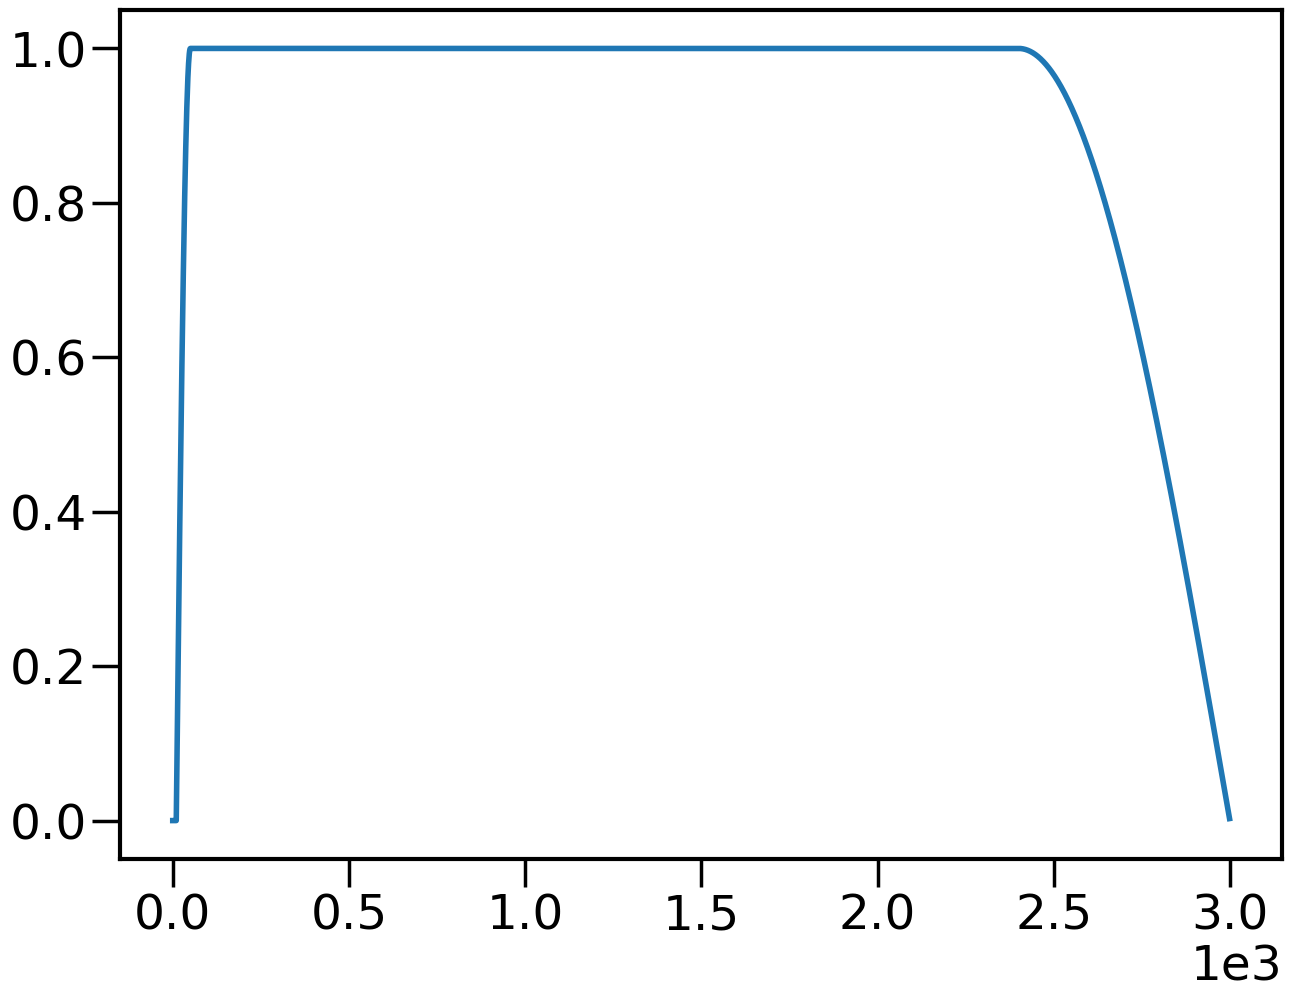

In [15]:
plot(l0,tf['taper_f'])
# xscale('log')

In [16]:
wth

array([ 6.17682247e+05,  6.17682227e+05,  6.17682207e+05, ...,
       -3.55951000e-02,  1.88960537e-01,  4.24201417e-01])

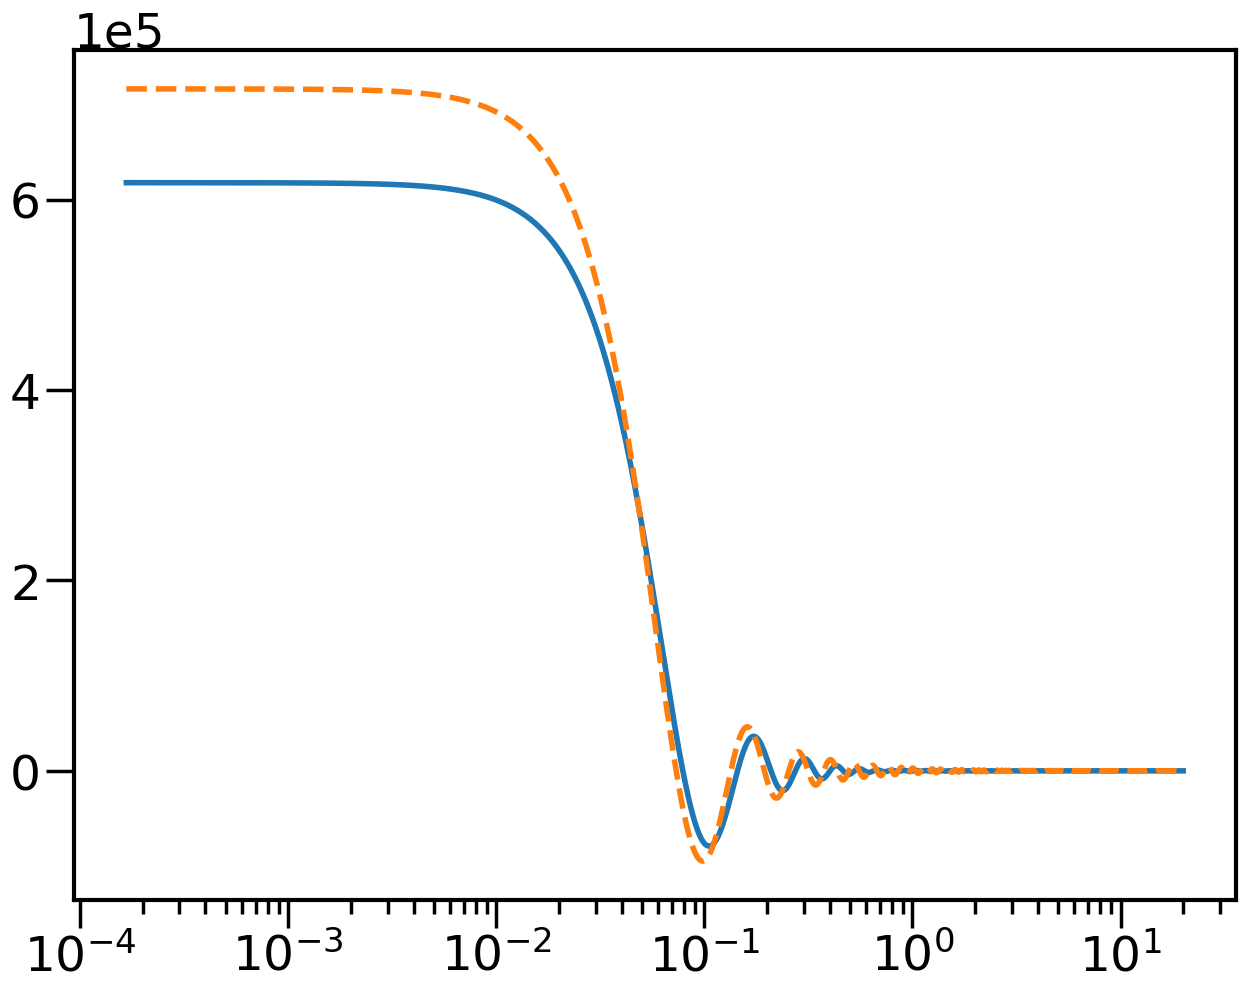

In [17]:
f=1#WT.theta_deg[s]**2
plot(WT.theta_deg[s],f*wth)
plot(WT.theta_deg[s],f*wth2,'--')

xscale('log')

In [18]:
theta_d=np.abs(th[:,None]-th)
wtheta_intp=interp1d(th,wth,bounds_error=False,kind='nearest')
wtheta_d=wtheta_intp(theta_d)

(0.0, 1.0)

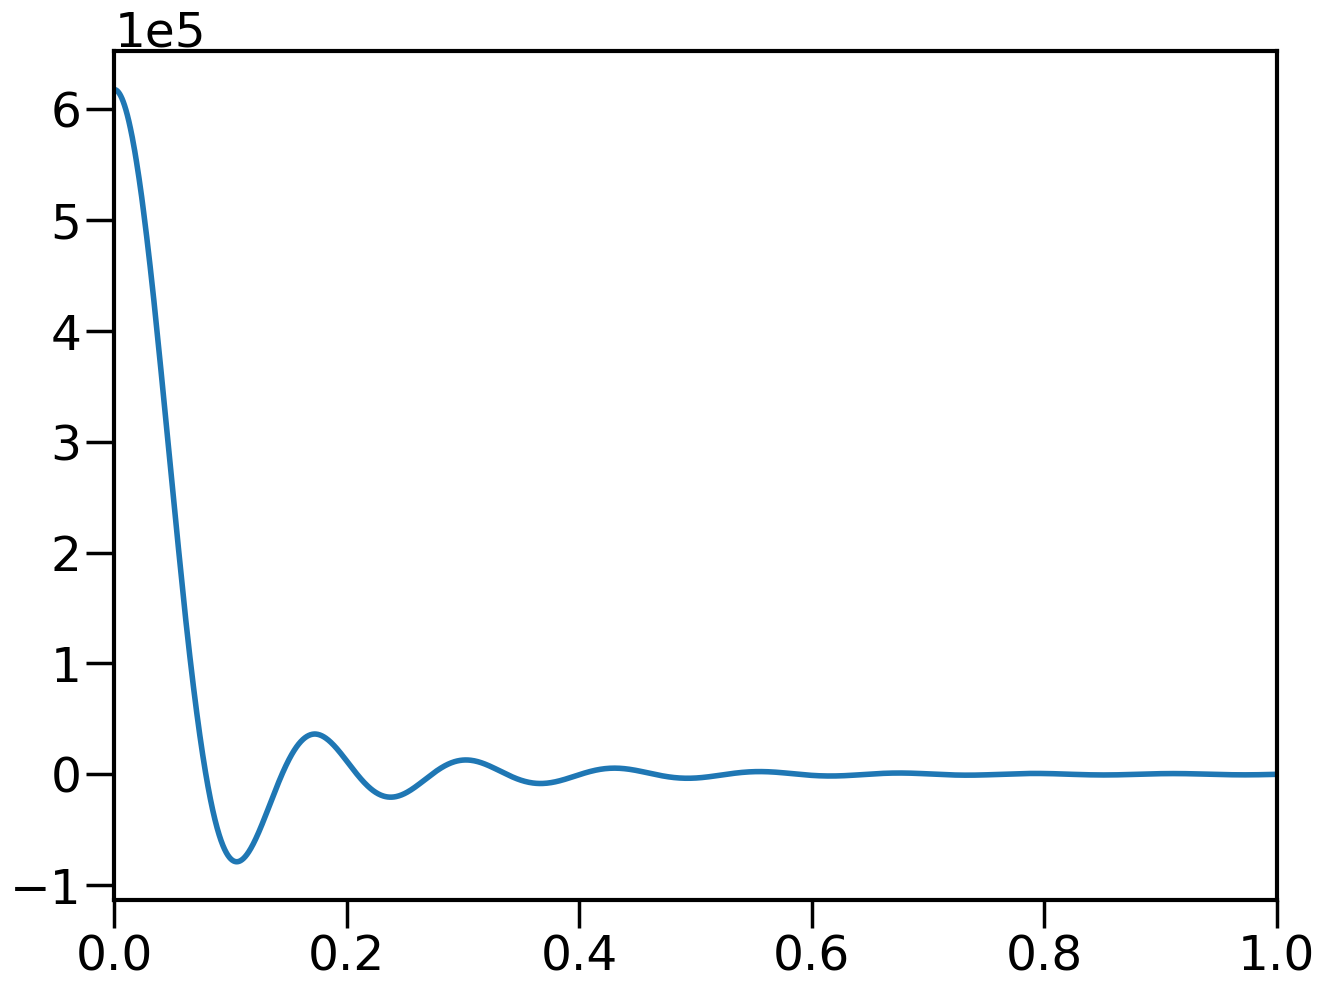

In [19]:
plot(theta_d[0,:],wtheta_d[0,:])
# plot(WT.theta_deg[(2,2)],wth)
# xscale('log')
xlim(0,1)

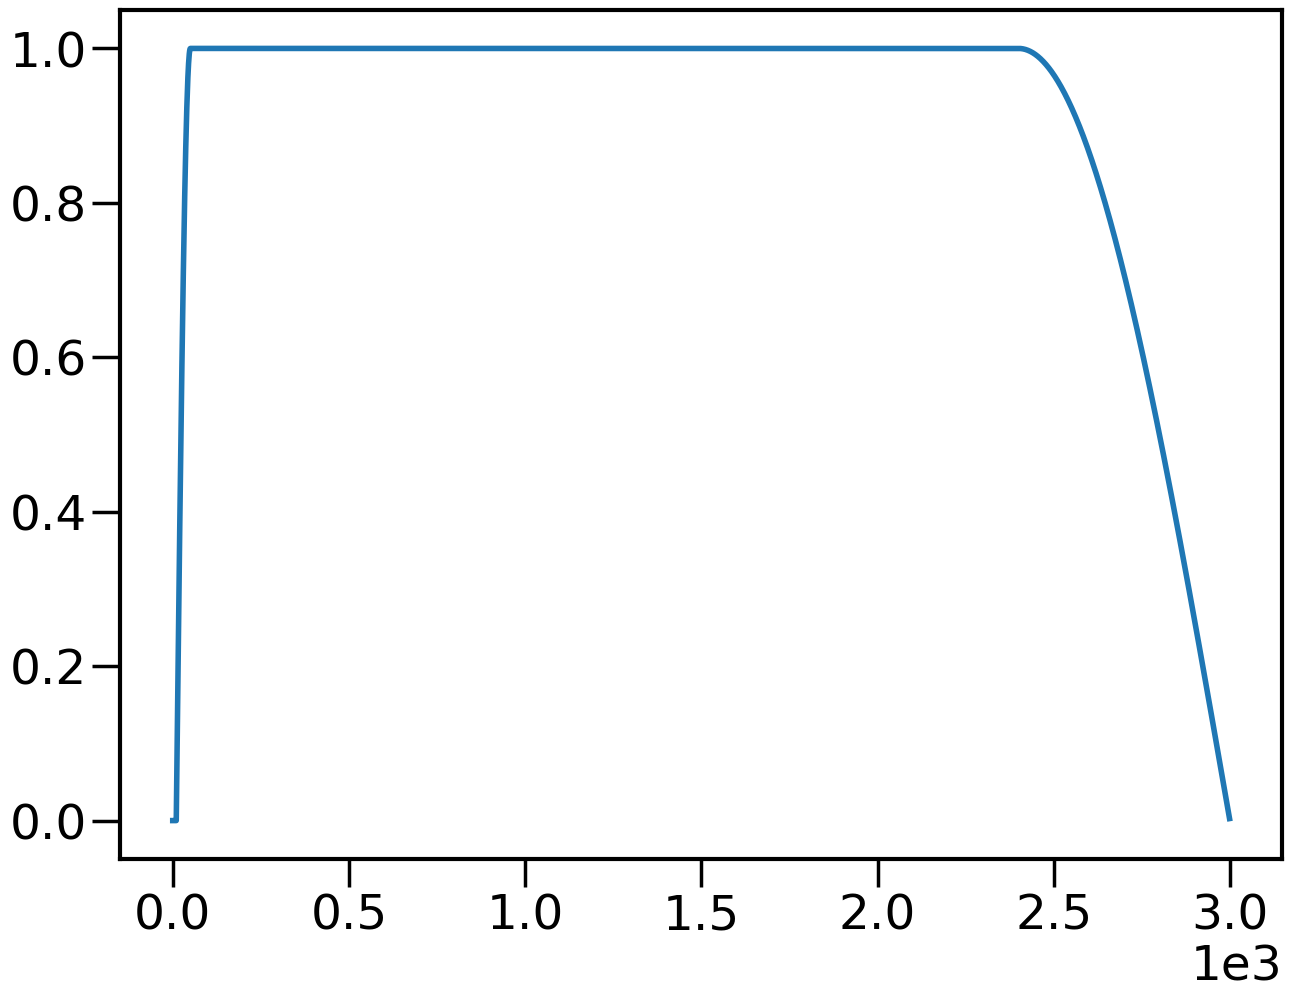

In [20]:
plot(l0,tf['taper_f'])

In [21]:
Skylens_kwargs=parse_dict(locals())
Skylens_kwargs_ub=copy.deepcopy(Skylens_kwargs)
Skylens_kwargs_ub['bin_xi']=False
Skylens_kwargs_ub['bin_cl']=False
Skylens_kwargs_ub['theta_bins']=th

In [22]:
kappa_xi0_ub=Skylens(**Skylens_kwargs_ub)
kappa_xi0=Skylens(**Skylens_kwargs)


Tracer utils has tracers:  ['shear', 'galaxy']


/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/cov_utils.py:92: RuntimeWarning: invalid value encountered in true_divide
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/angular_power_spectra.py:23: RuntimeWarning: divide by zero encountered in true_divide


pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 4.005
power spectra camb_pk_too_many_z
Win gen: step size 17 3000 513.0 2
Window done. Size: 0.0
Tracer utils has tracers:  ['shear', 'galaxy']
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 4.005
power spectra camb_pk_too_many_z
Win gen: step size 17 3000 513.0 2
Window done. Size: 0.0


In [23]:
cl_bu=client.gather(kappa_xi0.cl_bin_utils)
xi_bu=client.gather(kappa_xi0.xi_bin_utils)

In [24]:
%time xiHG_ub=kappa_xi0_ub.xi_tomo()
# %time xiH_ub=xiHG_ub['stack'].compute() #FIXME: bug in unbinned stacking
%time xi0ub=client.compute(xiHG_ub['xi']).result()
%time clG_ub=kappa_xi0_ub.cl_tomo()
# %time xiH_ub=xiHG_ub['stack'].compute() #FIXME: bug in unbinned stacking
%time cl0ub=client.compute(clG_ub['cl']).result()

/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/angular_power_spectra.py:115: RuntimeWarning: divide by zero encountered in true_divide


scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
Done xi graph 0.000847 437.329
CPU times: user 25.6 s, sys: 2.58 s, total: 28.2 s
Wall time: 12.8 s
CPU times: user 59.1 ms, sys: 247 ms, total: 306 ms
Wall time: 544 ms
scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
CPU times: user 116 ms, sys: 530 ms, total: 646 ms
Wall time: 1.23 s
CPU times: user 15.7 ms, sys: 3.71 ms, total: 19.4 ms
Wall time: 33.5 ms


In [25]:
l_bins_center=kappa_xi0.binning.bin_1d(xi=cl0ub[corr][bi]*kappa_xi0_ub.l,bin_utils=cl_bu)
l_bins_center/=kappa_xi0.binning.bin_1d(xi=cl0ub[corr][bi],bin_utils=cl_bu)

theta_bins_center=kappa_xi0.binning.bin_1d(xi=xi0ub[corr][s][bi]*WT.theta_deg[s],bin_utils=xi_bu[s])
theta_bins_center/=kappa_xi0.binning.bin_1d(xi=xi0ub[corr][s][bi],bin_utils=xi_bu[s])

In [26]:
Skylens_kwargs=parse_dict(locals())
Skylens_kwargs_b=copy.deepcopy(Skylens_kwargs)
Skylens_kwargs_b['use_binned_l']=True
Skylens_kwargs_b['use_binned_theta']=True
Skylens_kwargs_b['WT']=WT_b

In [27]:
kappa_xi0=Skylens(**Skylens_kwargs)
kappa_xi0b=Skylens(**Skylens_kwargs_b)

Tracer utils has tracers:  ['shear', 'galaxy']
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 4.005
power spectra camb_pk_too_many_z
Win gen: step size 17 3000 513.0 2
Window done. Size: 0.0
Tracer utils has tracers:  ['shear', 'galaxy']
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 4.005
power spectra camb_pk_too_many_z
Win gen: step size 17 3000 513.0 2
Window done. Size: 0.0
Tracer utils has tracers:  ['shear', 'galaxy']
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 4.005
power spectra camb_pk_too_many_z
Win gen: step size 21 43 513.0 2
Window done. Size: 0.0
Tracer utils has tracers:  ['shear', 'galaxy']
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpo

In [28]:
cl_bu=client.gather(kappa_xi0.cl_bin_utils)
xi_bu=client.gather(kappa_xi0.xi_bin_utils)

In [29]:
%time xiHG0=kappa_xi0.xi_tomo()
%time xiH0=xiHG0['stack'].compute()
%time xi0=client.compute(xiHG0['xi']).result()

scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
Done xi graph 0.000847 437.331
CPU times: user 24.4 s, sys: 2.4 s, total: 26.8 s
Wall time: 4.48 s
CPU times: user 163 ms, sys: 753 ms, total: 916 ms
Wall time: 1.37 s
CPU times: user 55.5 ms, sys: 246 ms, total: 301 ms
Wall time: 536 ms


In [30]:
%time xiHG_b=kappa_xi0b.xi_tomo()
%time xiH_b=xiHG_b['stack'].compute()
%time xi0b=client.compute(xiHG_b['xi']).result()

scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
Done xi graph 0.000847 437.284
CPU times: user 24.4 s, sys: 2.52 s, total: 26.9 s
Wall time: 4.95 s
CPU times: user 411 ms, sys: 2.26 s, total: 2.67 s
Wall time: 4 s
CPU times: user 22.4 ms, sys: 79.8 ms, total: 102 ms
Wall time: 119 ms


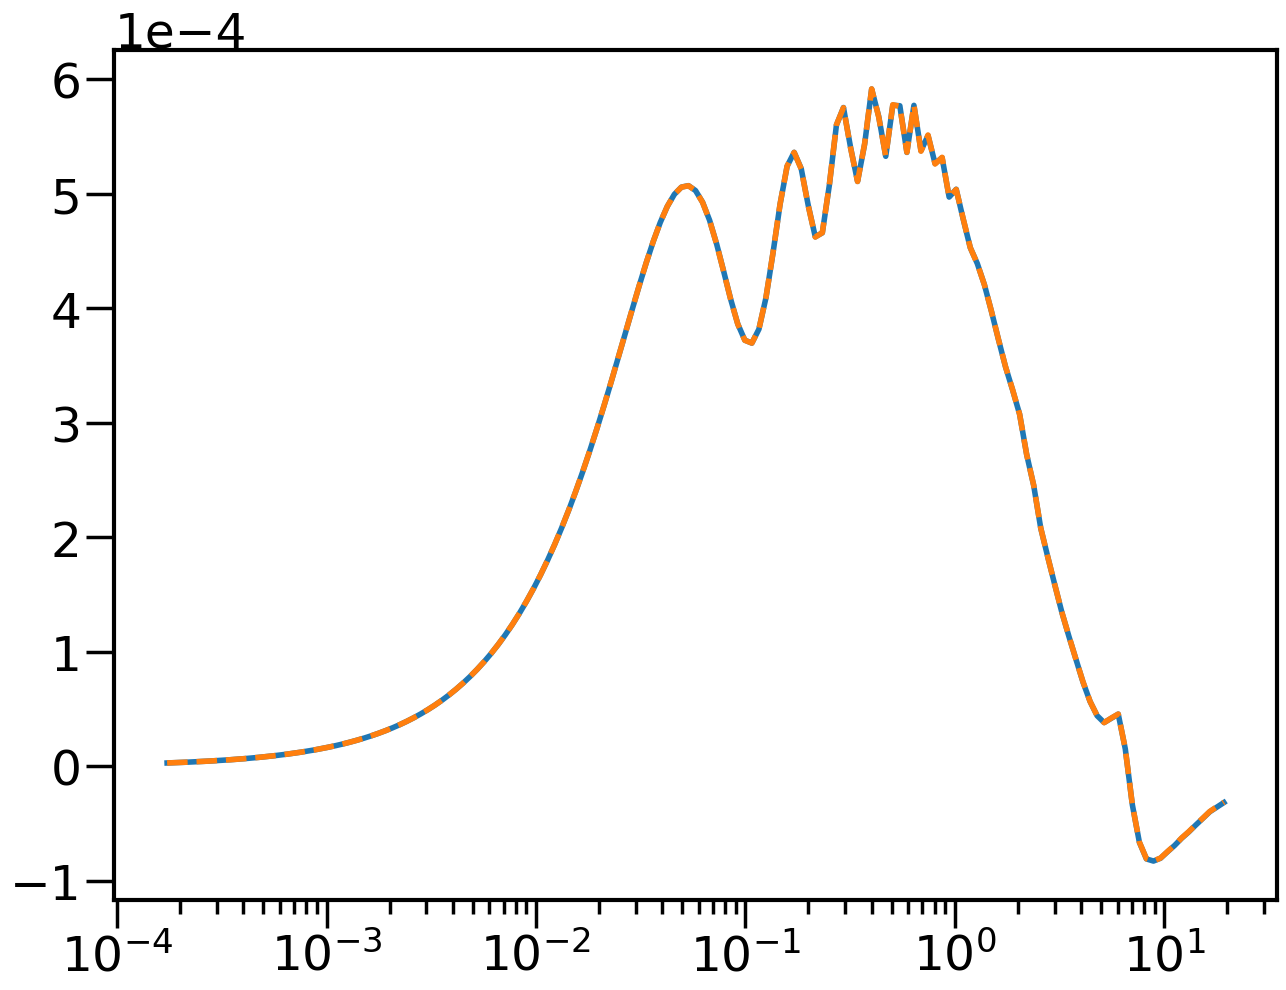

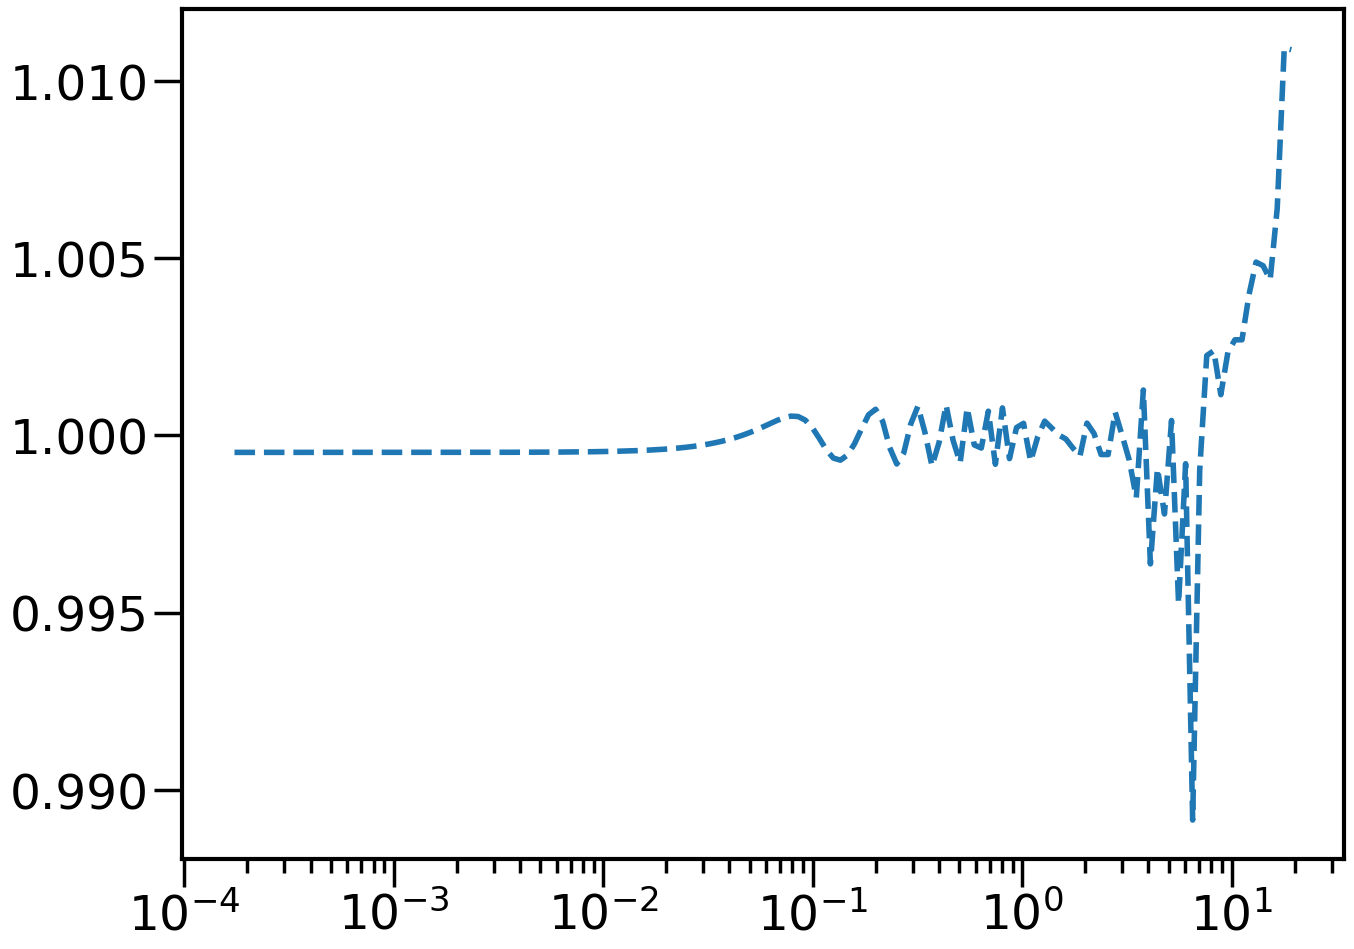

In [31]:
plot(thb,thb*xi0b[corr][s][bi])
plot(thb,thb*xi0[corr][s][bi],'--')
xscale('log')
show()
plot(thb,xi0b[corr][s][bi]/xi0[corr][s][bi],'--')
xscale('log')

In [32]:
def bin_2d_WT_inv(wig_mat=[],wig_norm=None,bin_utils_xi=None,bin_utils_cl=None,
                wt_b=None,wt0=None,use_binned_l=False,win_xi=None):

        wig_mat=wig_mat*wig_norm
#         wig_mat=wig_mat.T
        if bin_utils_xi is not None:
            binning_mat_xi=bin_utils_xi['binning_mat']
            if wt_b is None:
                wt_b=bin_utils_xi['wt_b']
            if wt0 is None:
                wt0=bin_utils_xi['wt0']
            if len(wt0.shape)==1:
                binning_mat_xi2=wt0[:,None]*binning_mat_xi*wt_b
            else:
                binning_mat_xi2=wt0@binning_mat_xi@wt_b #FIXME: Test this.
            print(wig_mat.shape,binning_mat_xi2.shape)
            wm=wig_mat@binning_mat_xi2
            
        else:
            wm=wig_mat
        
        wig_mat_b=wm
        if bin_utils_cl is not None and use_binned_l:
            bin_mat_cl=bin_utils_cl['binning_mat']
            
            rdr=bin_utils_cl['r_dr']
            bin_mat_cl=bin_mat_cl*rdr[:,None]/bin_utils_cl['norm'][None,:]
            
            wig_mat_b=bin_mat_cl.T@wm
        return wig_mat_b

In [33]:
%time clG0b=kappa_xi0b.cl_tomo()
%time cl0b=client.compute(clG0b['cl_b']).result()

%time clG0=kappa_xi0.cl_tomo()
%time cl0=client.compute(clG0['cl_b']).result()

%time cl0_0=client.compute(clG0['cl']).result()

scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
CPU times: user 139 ms, sys: 554 ms, total: 692 ms
Wall time: 1.5 s
CPU times: user 16.5 ms, sys: 3.15 ms, total: 19.7 ms
Wall time: 34.9 ms
scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
CPU times: user 148 ms, sys: 644 ms, total: 793 ms
Wall time: 1.76 s
CPU times: user 19.6 ms, sys: 2.14 ms, total: 21.7 ms
Wall time: 39.3 ms
CPU times: user 17.8 ms, sys: 2.88 ms, total: 20.7 ms
Wall time: 43.7 ms


In [34]:
wd_b=kappa_xi0b.WT_binned[corr][s][bi].result()
wd_bi=numpy.linalg.pinv(wd_b)

In [35]:
wd_bi2=kappa_xi0b.inv_WT_binned[corr][s][bi].result()

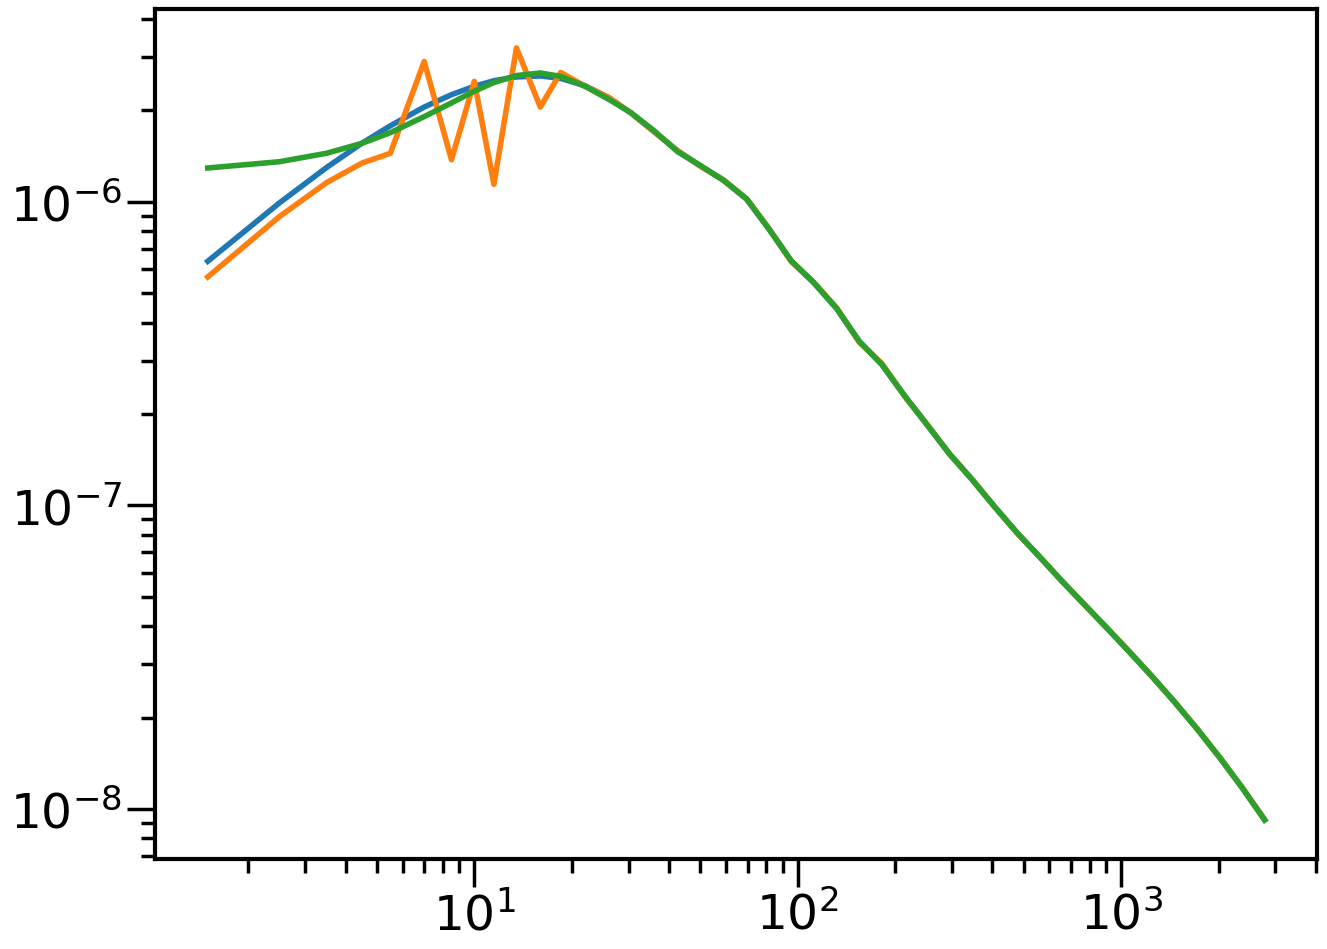

(0.9, 1.21)

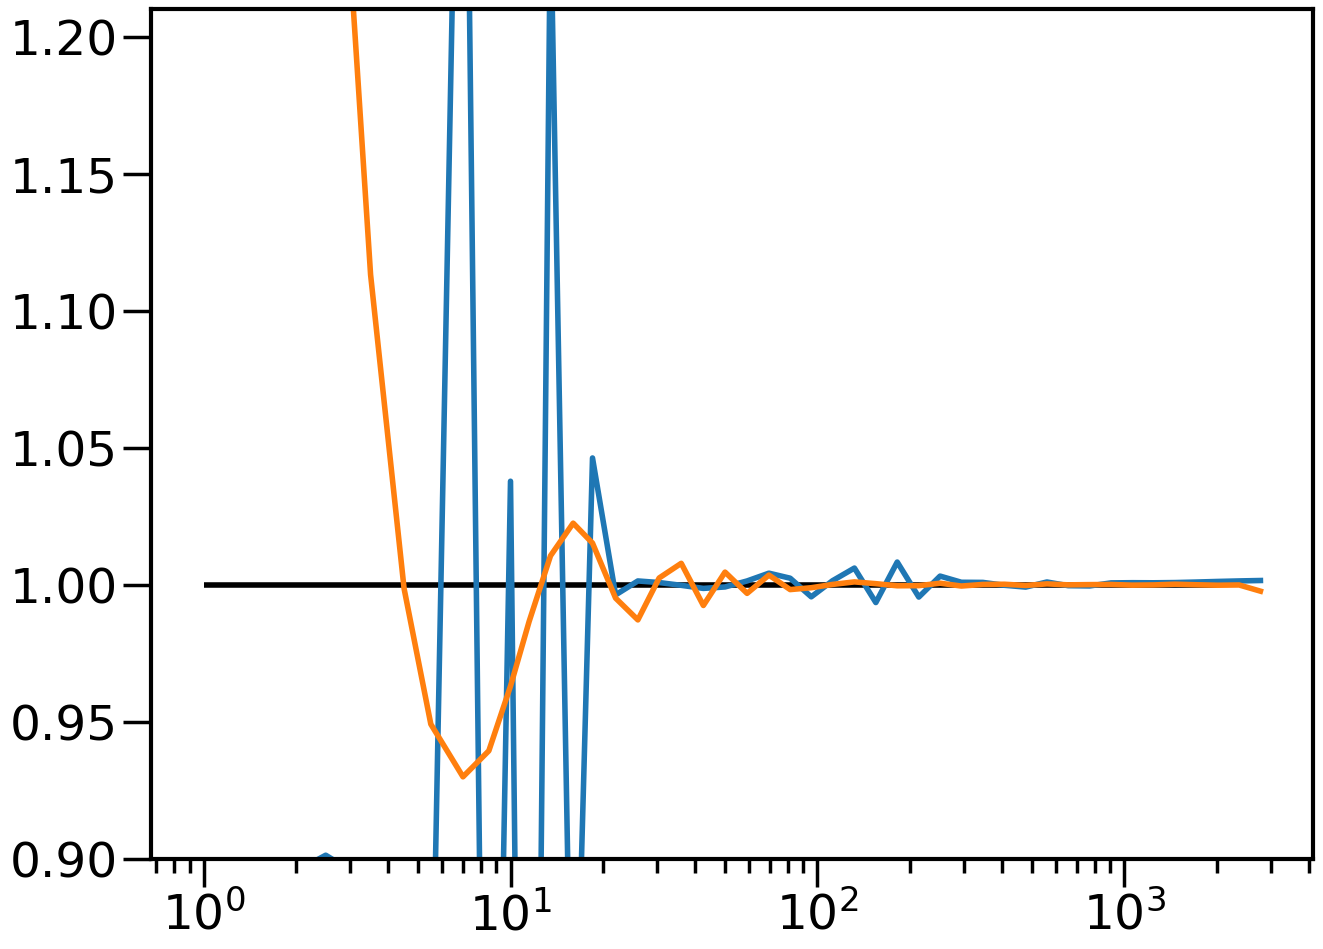

In [36]:
#reconstructing power spectra. Large scales are biased due to missing large theta values.
plot(lb,cl0[corr][(0,0)])
plot(lb,wd_bi@xi0b[corr][s][bi])
plot(lb,(wd_bi2@xi0b[corr][s][bi]))
loglog()
show()
plot(lb,wd_bi@xi0b[corr][s][bi]/cl0[corr][bi])
plot(lb,wd_bi2@xi0b[corr][s][bi]/cl0[corr][bi])
hlines(1,1,2000,color='k')
xscale('log')
ylim(0.9,1.21)

(10, 2000)

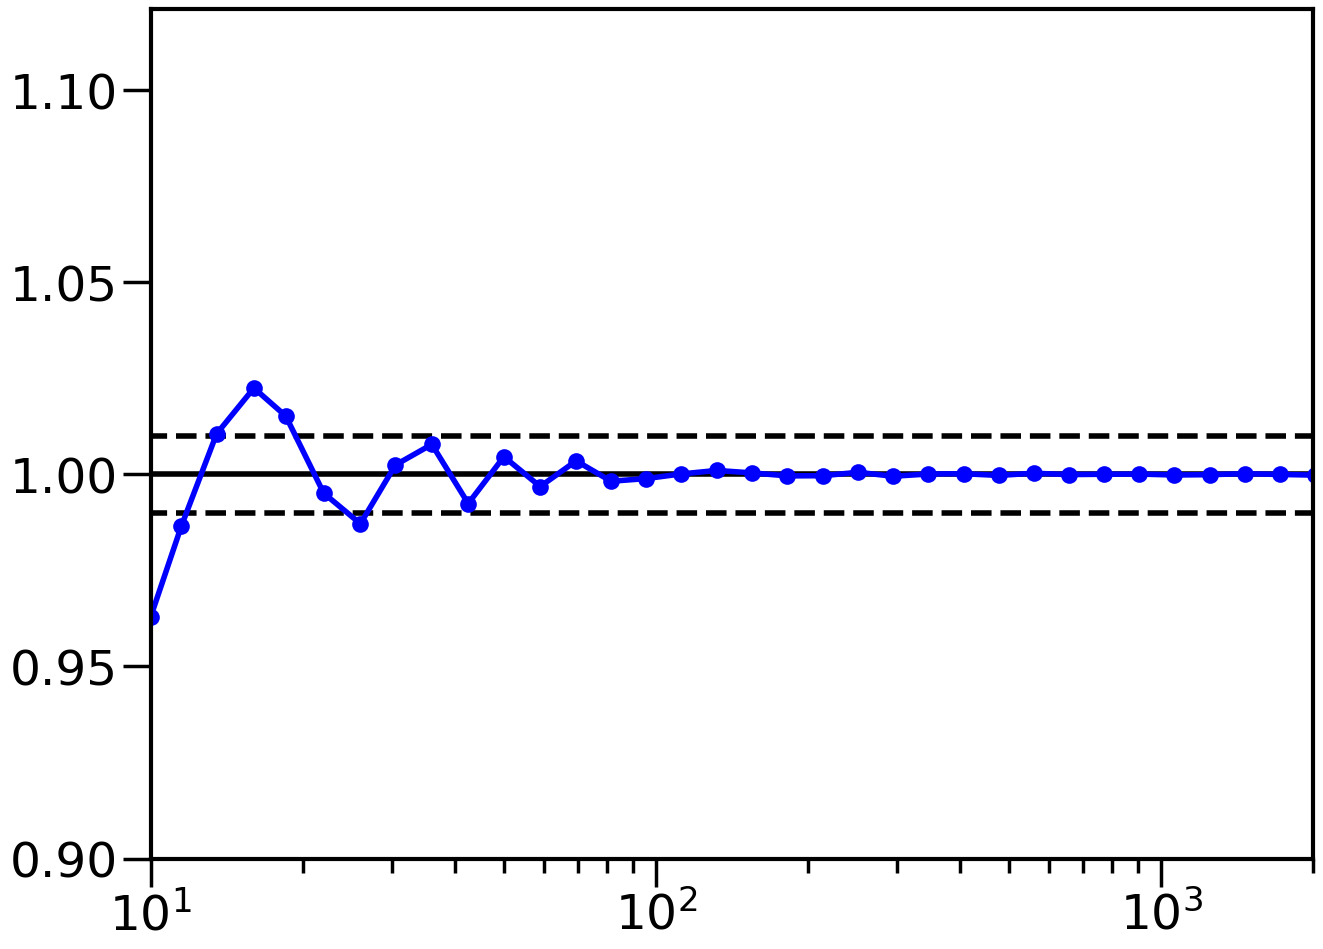

In [37]:
plot(lb,wd_bi2@xi0b[corr][s][bi]/cl0[corr][bi],'bo-')
hlines(1,1,2000,color='k')
hlines(1.01,1,2000,color='k',ls='--')
hlines(.99,1,2000,color='k',ls='--')
xscale('log')
ylim(0.9,1.121)
xlim(10,2000)

<ipython-input-38-804550b56a6a>:33: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  pR.set_yscale('symlog',linthreshy=0.01)


saved to  ./figures/WT_inv_th_min_comp_gg.pdf


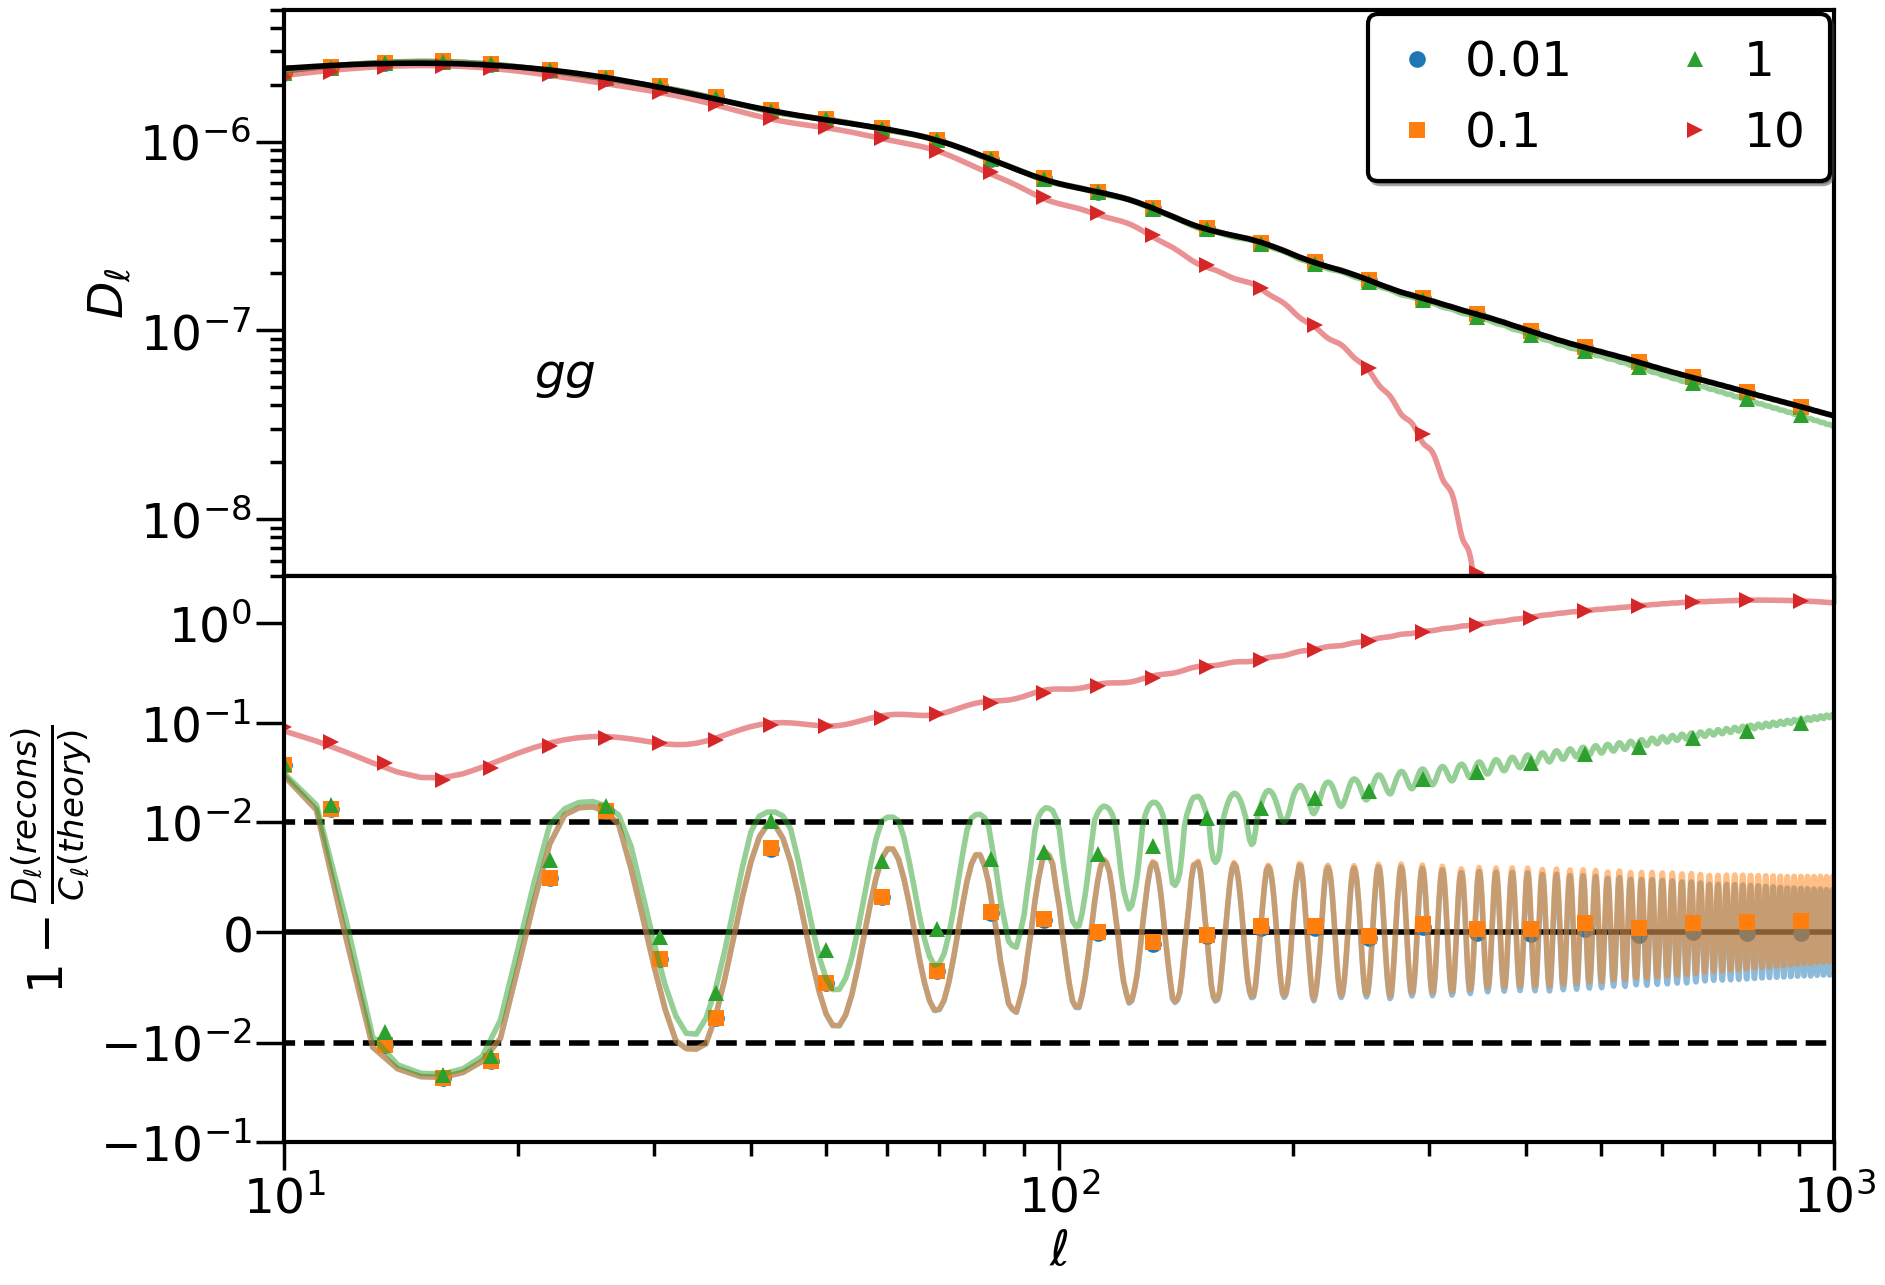

In [38]:
fig, ax =subplots(2,1,figsize=(20,15),sharex='col',sharey='row')
pS=ax[0]
pR=ax[1]
l_inv,cl_inv=WT.inv_projected_correlation(theta_xi=th*d2r,xi=xi0ub[corr][s][bi],s1_s2=s,wig_d=WT.wig_d[s].T,wig_norm=WT.inv_wig_norm)
pS.plot(l_inv,cl0_0[corr][bi],alpha=1,zorder=10,c='k')
pS.plot(l_inv,cl_inv,c=colors[0],alpha=0.5)
pS.plot(lb,wd_bi2@xi0b[corr][s][bi],c=colors[0],marker=markers[0],label=str(theta_min*60),lw=0)


pR.plot(l_inv,1-cl_inv/cl0_0[corr][bi],c=colors[0],alpha=0.5)
pR.plot(lb,1-wd_bi2@xi0b[corr][s][bi]/cl0[corr][bi],c=colors[0],marker=markers[0],label=str(theta_min*60),lw=0)

thcs=[0.1,1,10]
i=1
for thc in thcs:
    x=thb*60>thc
    xi_x=xi0b[corr][s][bi]*1.
    xi_x[~x]=0
    pS.plot(lb,(wd_bi2@xi_x),c=colors[i],marker=markers[i],label=str(thc),ls=None,lw=0)
    pR.plot(lb,1-(wd_bi2@xi_x)/cl0[corr][bi],c=colors[i],marker=markers[i],label=str(thc),ls=None,lw=0)
    x=th*60>thc
    l_inv,cl_inv=WT.inv_projected_correlation(theta_xi=th[x]*d2r,wig_theta=th[x]*d2r,xi=xi0ub[corr][s][bi][x],
                                              s1_s2=s,wig_d=WT.wig_d[s][x,:].T,wig_norm=WT.inv_wig_norm[x])
    pR.plot(l_inv,1-cl_inv/cl0_0[corr][bi],c=colors[i],alpha=0.5)#,label=r'$\theta_{min}=$'+str(thc))
    pS.plot(l_inv,cl_inv,c=colors[i],alpha=0.5)#,label=r'$\theta_{min}=$'+str(thc))

    i+=1
pR.hlines(0,1,2000,color='k')
pR.hlines(.01,1,2000,color='k',ls='--')
pR.hlines(-0.01,1,2000,color='k',ls='--')
pR.set_xscale('log')
pS.set_yscale('log')
pR.set_yscale('symlog',linthreshy=0.01)
# ylim(0.9,1.121)
pR.set_ylim(-0.1,3)
pS.set_ylim(5.e-9,5.e-6)
pR.set_xlim(10,1000)
pR.set_xlabel('$\ell$')
pR.set_ylabel(r'$1-\frac{D_\ell(recons)}{C_\ell (theory)}$')
pS.set_ylabel(r'$D_\ell$')
pS.text(x=21,y=5e-8,s=corr_labels[corr][s])
pS.legend(loc='upper right',ncol=2)
fname='WT_inv_th_min_comp_'+corr_fnames[corr][s]
fname=fig_home+fname
fname+='.pdf'
fig.savefig(fname,bbox_inches='tight',format='pdf')
print('saved to ',fname)    
show()

In [39]:
lmax_cl

3000

In [40]:
l0c=np.arange(lmax_cl)
window_l_test=np.arange(lmax_cl)
wl0c=window_l_test
wu=window_utils(l=l0c,window_l=window_l_test,use_window=True,s1_s2s={corr:s},
                corrs=corrs,wigner_step=100,wigner_files=wigner_files,bin_window=False)
wu.set_wig3j()
# wj2=client.compute(wu.wig_3j_2).result()
# wj2=wj2[0]['00']

Win gen: step size 100 3000 3000.0 10
wigner_files: {0: '/verafs/scratch/phy200040p/sukhdeep/physics2/skylens/temp/dask_wig3j_l5000_w5000_0_reorder.zarr', 2: '/verafs/scratch/phy200040p/sukhdeep/physics2/skylens/temp//dask_wig3j_l2200_w4400_2_reorder.zarr'}
wigner done dict_keys([])


In [41]:
xi_t=np.ones_like(xi0ub[corr][s][bi])
l_inv,wl_inv=WT.inv_projected_correlation(theta_xi=th*d2r,wig_theta=th*d2r,xi=xi_t,
                                          s1_s2=s,wig_d=WT.wig_d[s].T,wig_norm=WT.inv_wig_norm)


In [42]:
M_lm={}
Mw_lm={}

nl=len(l0c)
nlw=len(wl0c)
M=np.zeros((nl,nl))
Mw=np.zeros((nl,nlw))

# M_lm2={}
# M2=np.zeros((nl,nl))

for lm in wu.lms:
    wj2i=client.compute(wu.wig_3j_2[lm]).result()
    wj2i=wj2i['00']
    start_i=lm
    end_i=lm+wu.step
    l0ci=wl0c
    M_lm[lm]=wj2i@(wl_inv[l0ci]*(2*l0ci+1))
    M[start_i:end_i,:]+=M_lm[lm]

    wj2i=wj2i.transpose(0,2,1)
    l0ci=l0c
    Mw_lm[lm]=wj2i@(cl0_0[corr][bi][l0ci]*(2*l0ci+1))
    Mw[start_i:end_i,:]+=Mw_lm[lm]

    print(lm,'done')
M/=4.*np.pi
M*=(2*l0c+1)
Mw/=4.*np.pi
Mw*=(2*wl0c+1)

0 done
100 done
200 done
300 done
400 done
500 done
600 done
700 done
800 done
900 done
1000 done
1100 done
1200 done
1300 done
1400 done
1500 done
1600 done
1700 done
1800 done
1900 done
2000 done
2100 done
2200 done
2300 done
2400 done
2500 done
2600 done
2700 done
2800 done
2900 done


<ipython-input-43-13bea37cfabe>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolor(l0c,l0c,M,norm=LogNorm(),cmap='Reds',rasterized=True)


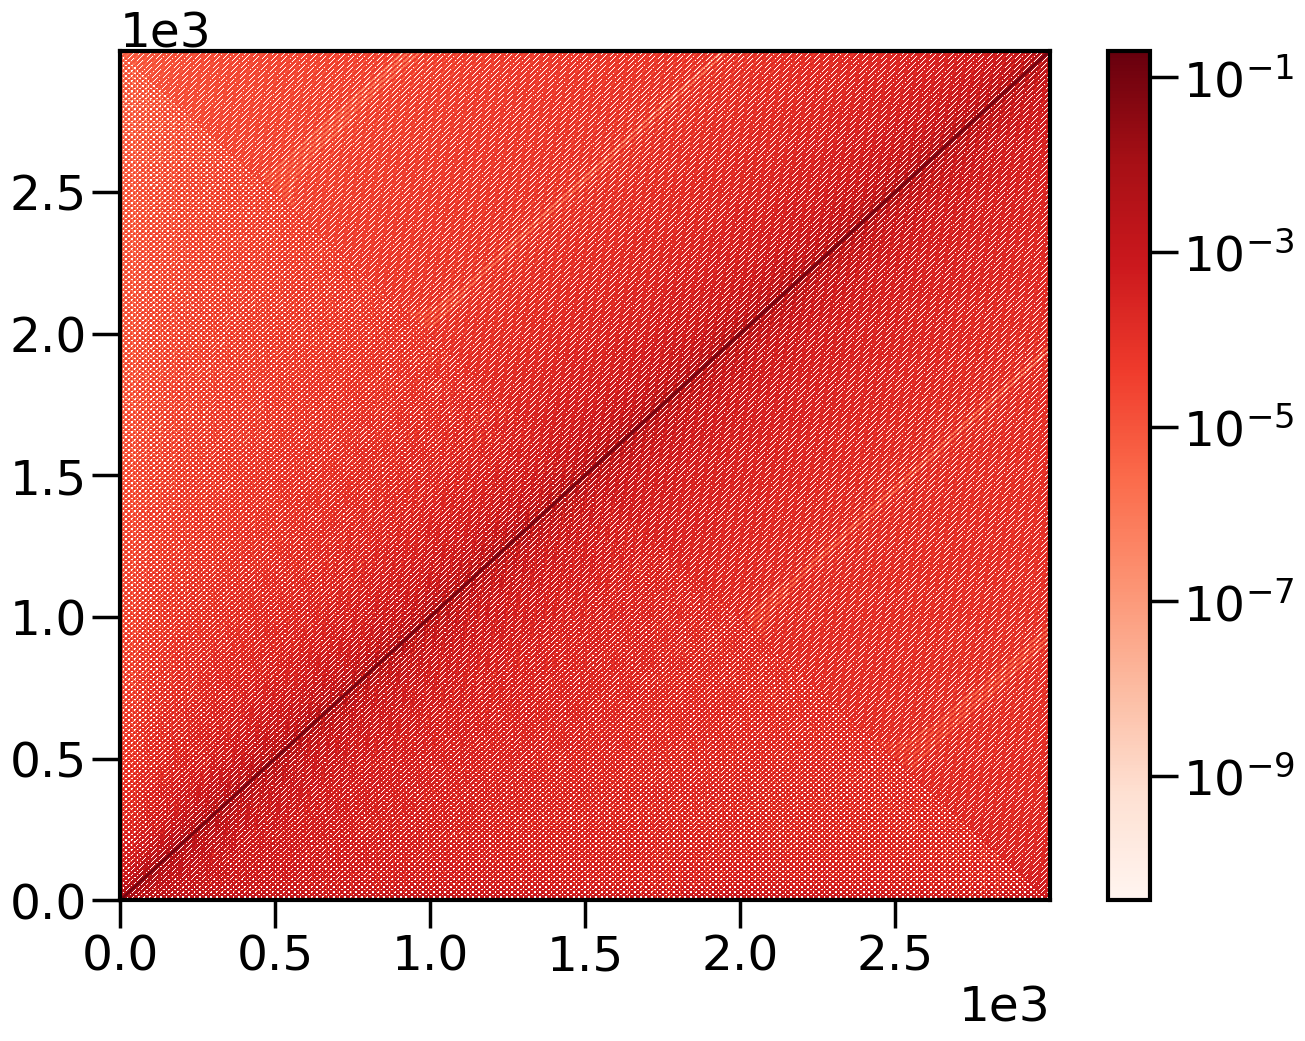

[]

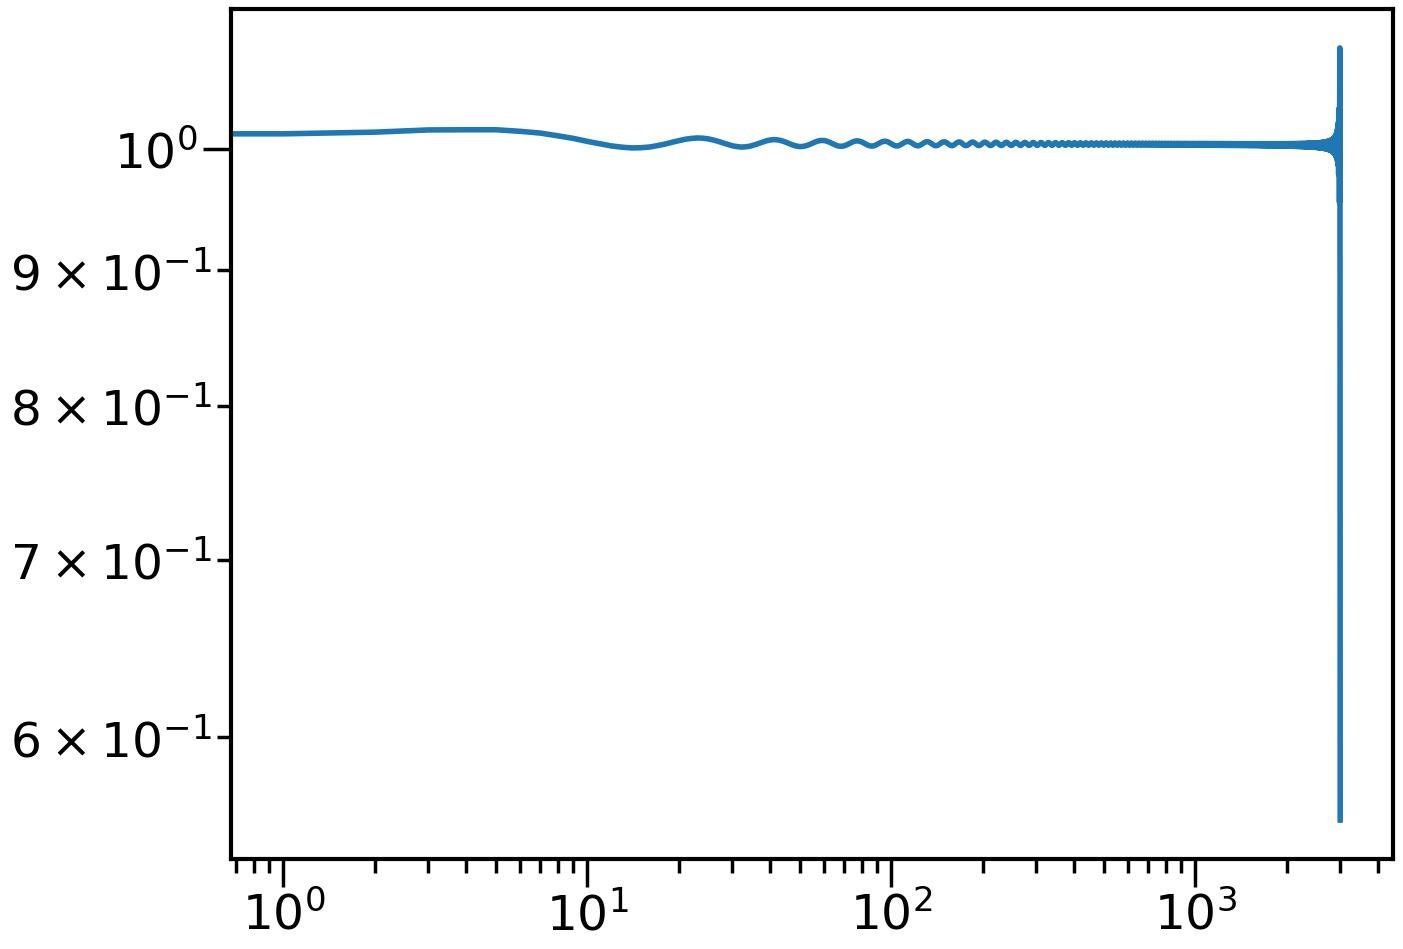

In [43]:
pcolor(l0c,l0c,M,norm=LogNorm(),cmap='Reds',rasterized=True)
colorbar()
# loglog()
# xlim(1,l0c.max())
# ylim(1,l0c.max())
show()
plot(M@np.ones_like(l0c))
loglog()

<ipython-input-44-1582150a6d3c>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolor(l0c,wl0c,Mw,norm=LogNorm(),cmap='Reds',rasterized=True)


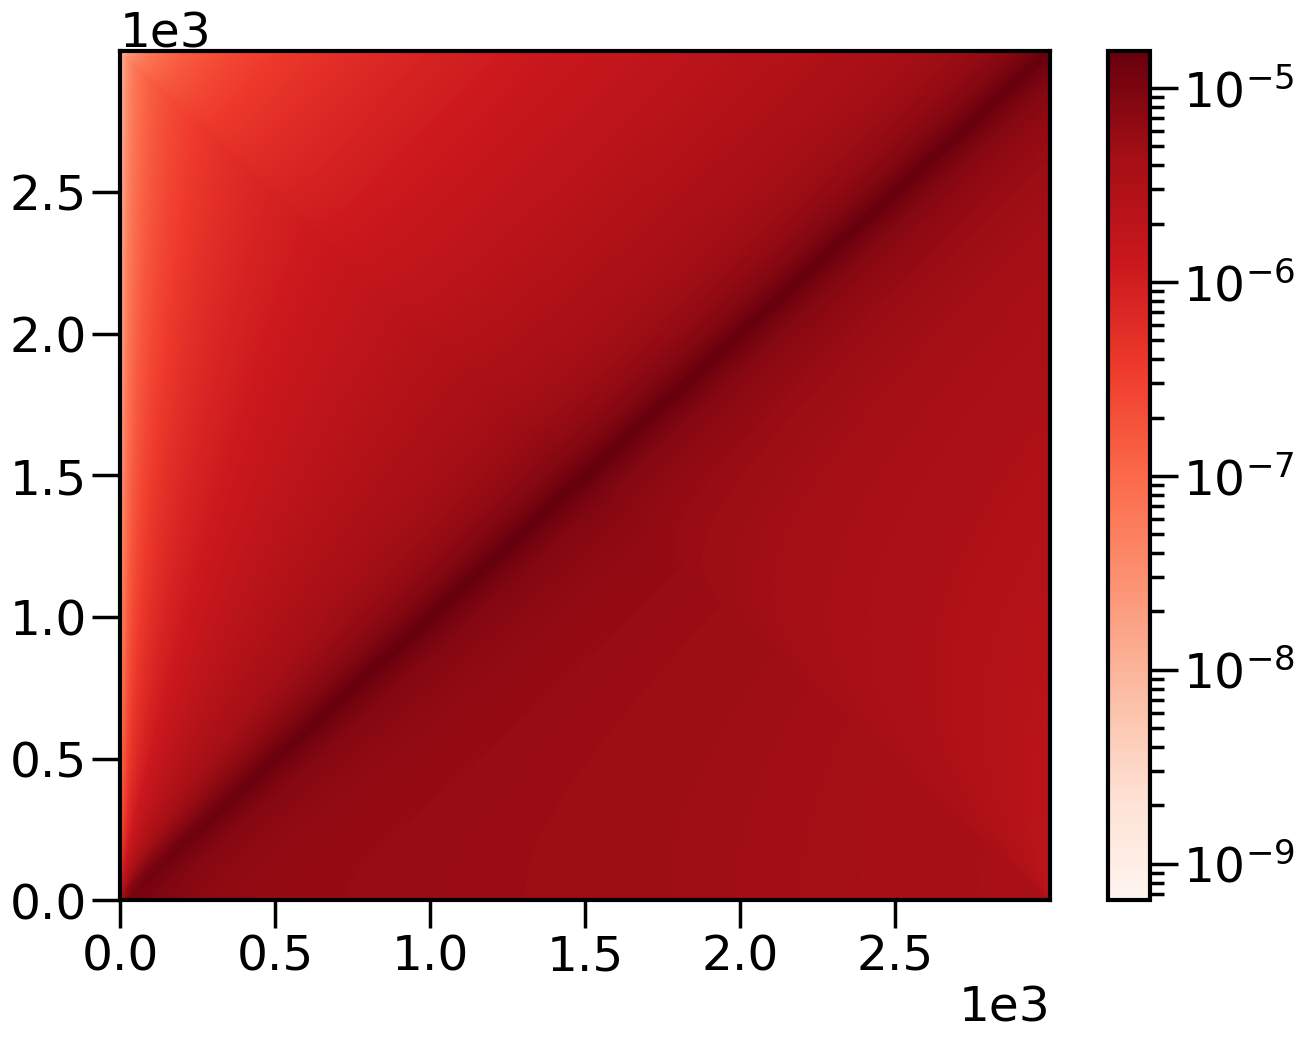

[]

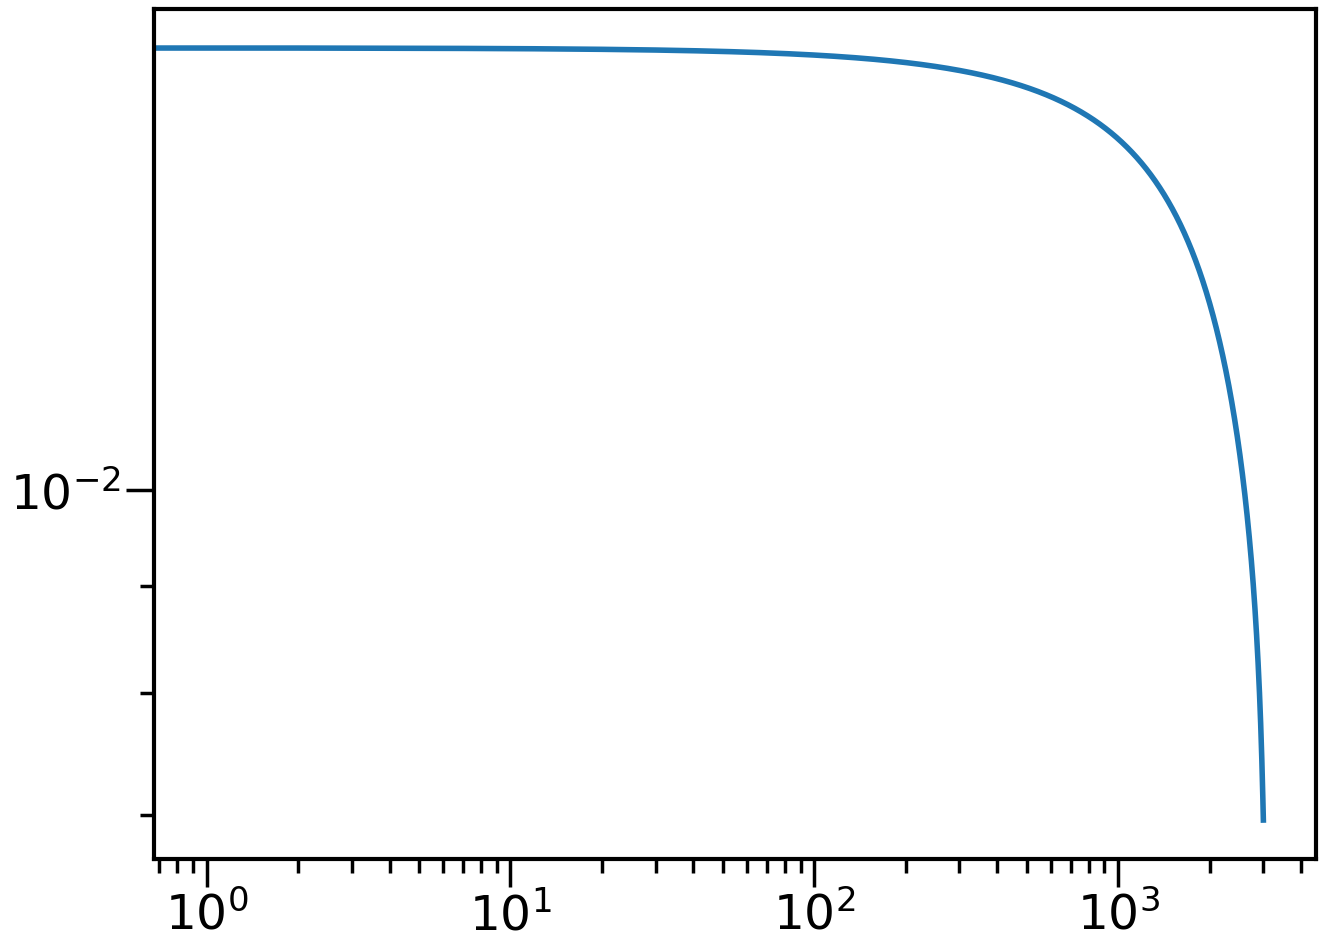

In [44]:
pcolor(l0c,wl0c,Mw,norm=LogNorm(),cmap='Reds',rasterized=True)
colorbar()
# loglog()
# xlim(1,l0c.max())
# ylim(1,l0c.max())
show()
plot(Mw@np.ones_like(wl0c))
loglog()

In [45]:
theta_min

0.00016666666666666666

In [46]:
th[x].min()

0.1666945984892118

In [47]:
??WT.taper

In [48]:
x=th*60>10
taper_f=np.cos((th[~x]-th[x].min())/(th[x].min()-theta_min)*np.pi/2.)**2

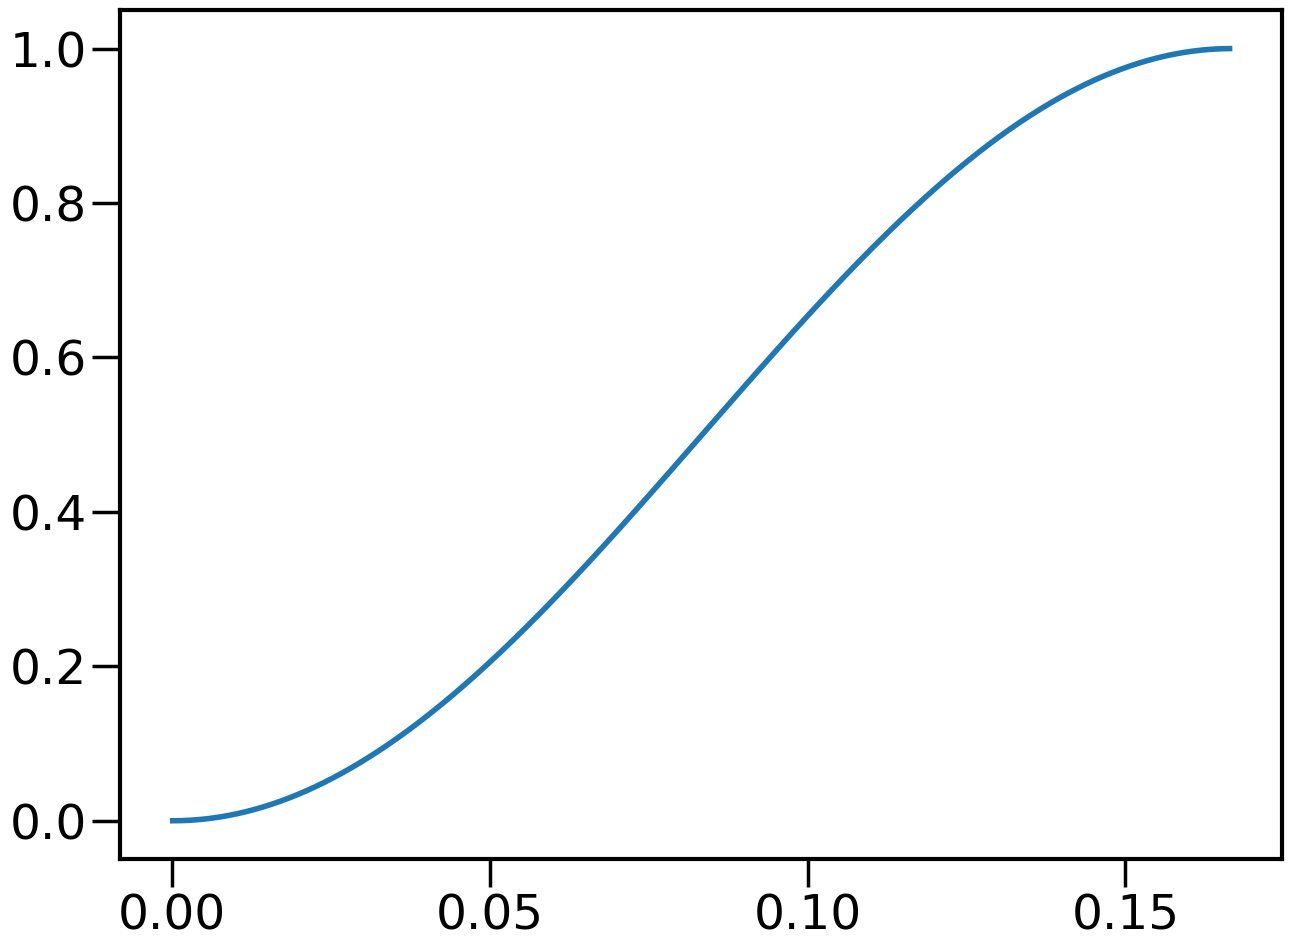

In [49]:
plot(th[~x],taper_f)

In [50]:
l_smooth_min=50
l_smooth_max=1000

saved to  ./figures/WT_inv_th_min_comp_convolve_unbinned_gg.pdf


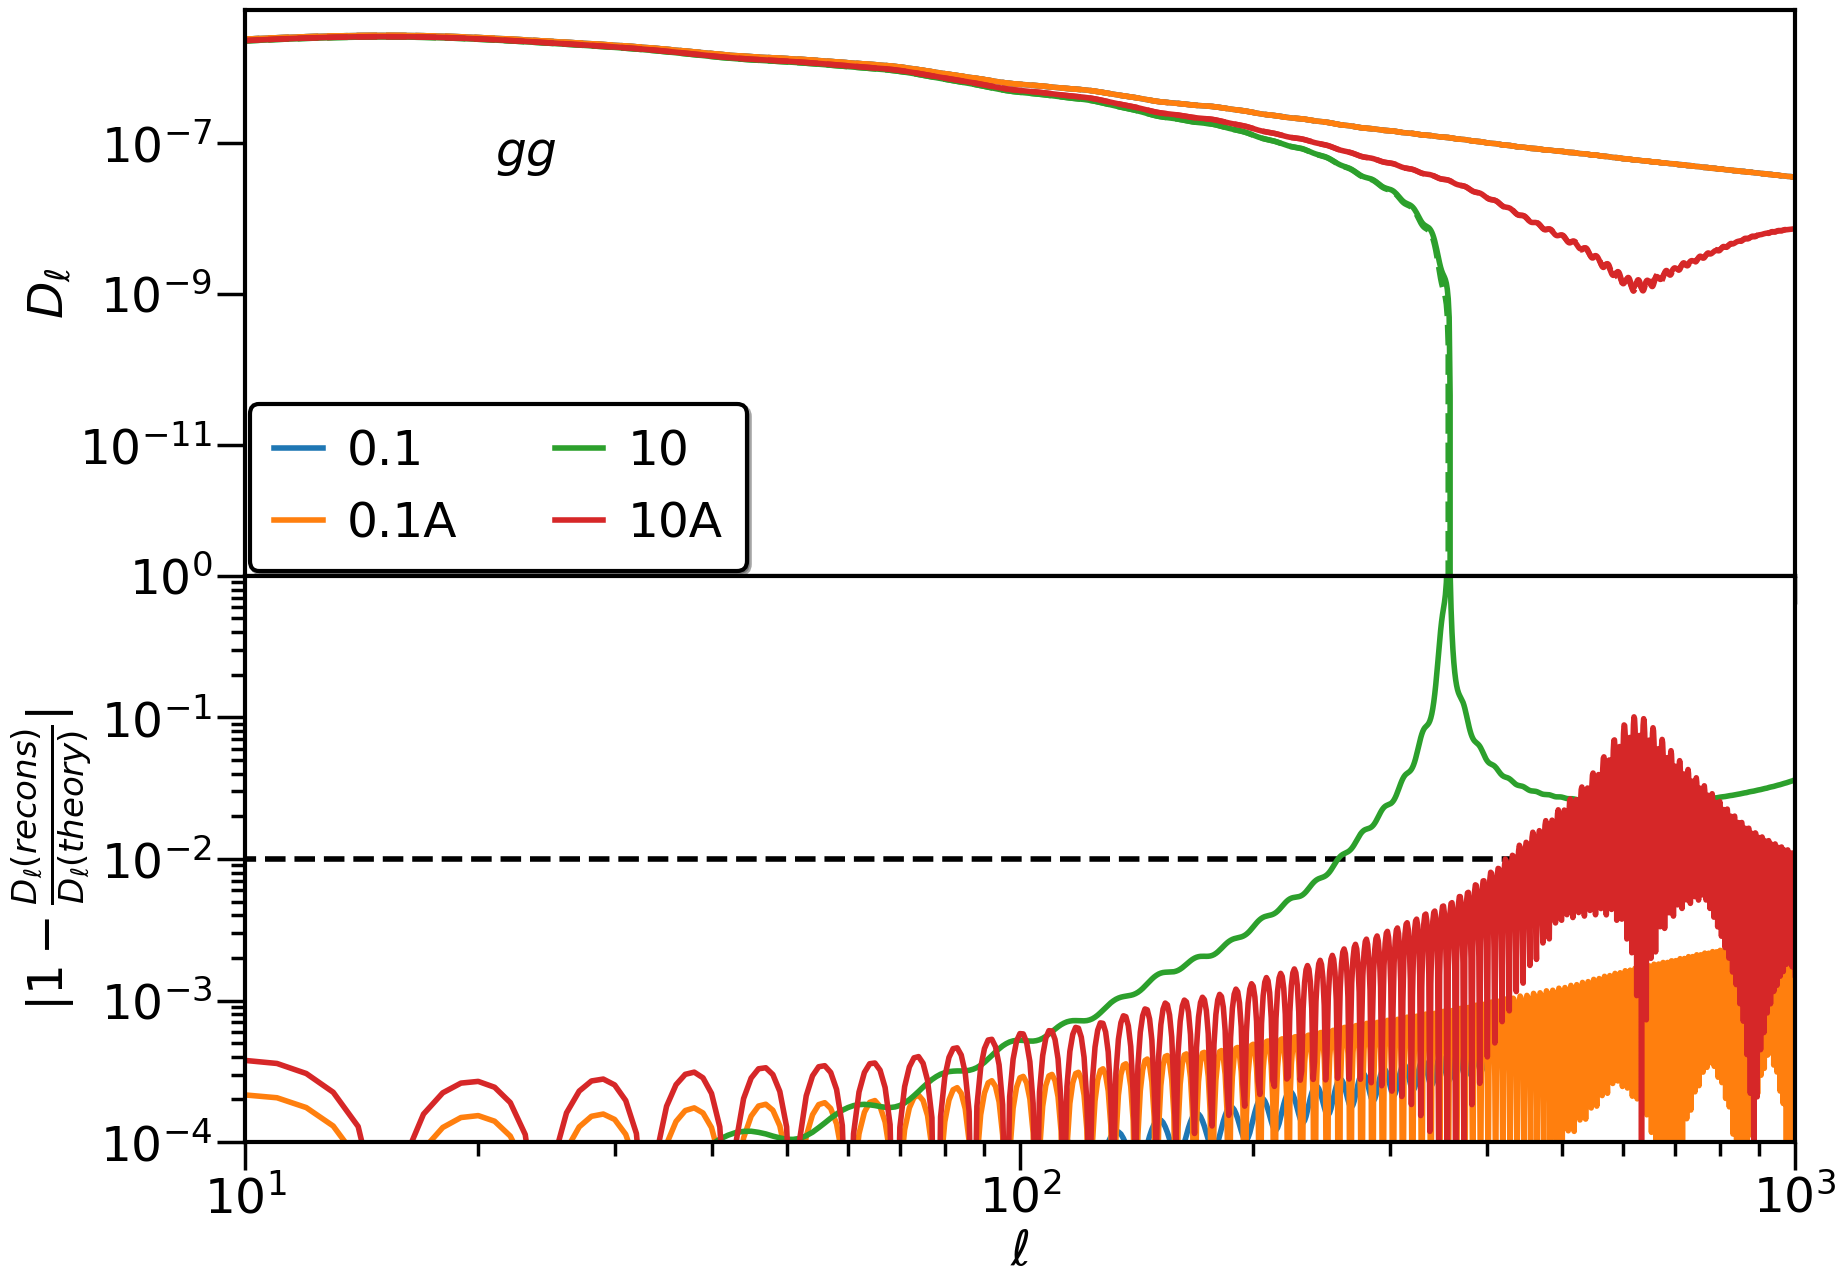

In [51]:
fig, ax =subplots(2,1,figsize=(20,15),sharex='col',sharey='row')
pS=ax[0]
pR=ax[1]
# l_inv,cl_inv=WT.inv_projected_correlation(theta_xi=th*d2r,xi=xi0ub[corr][s][bi],s1_s2=s,wig_d=WT.wig_d[s].T,wig_norm=WT.inv_wig_norm)
# pS.plot(l_inv,cl0_0[corr][bi],alpha=1,zorder=10,c='k')
# pS.plot(l_inv,cl_inv,c=colors[0],alpha=0.5)
# pS.plot(lb,wd_bi2@xi0b[corr][s][bi],c=colors[0],marker=markers[0],label=str(theta_min*60),lw=0)



# pR.plot(l_inv,1-cl_inv/cl0_0[corr][bi],c=colors[0],alpha=0.5)
# pR.plot(lb,1-wd_bi2@xi0b[corr][s][bi]/cl0[corr][bi],c=colors[0],marker=markers[0],label=str(theta_min*60),lw=0)

thcs=[.1,10]
th_max=600
i=0
for thc in thcs:
    x=th*60>thc
    xi_t=np.ones_like(xi0ub[corr][s][bi])
#     xi_t[~x]=np.cos((th[~x]-th[x].min())/(th[x].min()-theta_min)*np.pi/2.)
    xi_t[~x]=0
    
    l_inv,cl_inv=WT.inv_projected_correlation(theta_xi=th*d2r,wig_theta=th*d2r,xi=xi0ub[corr][s][bi]*xi_t,
                                              s1_s2=s,wig_d=WT.wig_d[s].T,wig_norm=WT.inv_wig_norm)
    cl_inv0=cl0_0[corr][bi][l0c]
    
    
    l_inv,wl_inv=WT.inv_projected_correlation(theta_xi=th*d2r,wig_theta=th*d2r,xi=xi_t,
                                              s1_s2=s,wig_d=WT.wig_d[s].T,wig_norm=WT.inv_wig_norm)
    
    cl_inv2=Mw@wl_inv[wl0c]#*(2*wl0c+1))
    pR.plot(l_inv[l0c],np.absolute(cl_inv2/cl_inv[l0c]-1),c=colors[i])#,label=r'$\theta_{min}=$'+str(thc))
    pS.plot(l_inv[l0c],cl_inv2,c=colors[i],label=str(thc),)#,label=r'$\theta_{min}=$'+str(thc))
    pS.plot(l_inv[l0c],cl_inv,c=colors[i],ls='--',)#,label=r'$\theta_{min}=$'+str(thc))
    
    i+=1

    x=l_inv<l_smooth_min/thc
    x2=l_inv<l_smooth_max
    x=x*x2
    wl_inv[~x]*=np.cos((l_inv[~x]-l_inv[x].max())/(l_smooth_max-l_inv[x].max())*np.pi/2.)
    wl_inv[~x2]*=0
    
    tht,xi_t2=WT.projected_correlation(l_cl=l_inv,cl=wl_inv,s1_s2=s,wig_d=WT.wig_d[s],wig_norm=WT.wig_norm)
#     xi_t/=xi_t.max()
    l_inv,cl_inv=WT.inv_projected_correlation(theta_xi=th*d2r,wig_theta=th*d2r,xi=xi0ub[corr][s][bi]*xi_t2,
                                              s1_s2=s,wig_d=WT.wig_d[s].T,wig_norm=WT.inv_wig_norm)
    cl_inv2=Mw@wl_inv[wl0c]
    
    pR.plot(l_inv[l0c],np.absolute(cl_inv2/cl_inv[l0c]-1),c=colors[i])#,label=r'$\theta_{min}=$'+str(thc))
    pS.plot(l_inv[l0c],cl_inv2,c=colors[i],label=str(thc)+'A',)#,label=r'$\theta_{min}=$'+str(thc))
    pS.plot(l_inv[l0c],cl_inv,c=colors[i],ls='--',)

    i+=1
    
pR.hlines(0,1,2000,color='k')
pR.hlines(.01,1,2000,color='k',ls='--')
pR.hlines(-0.01,1,2000,color='k',ls='--')
pR.set_xscale('log')
pS.set_yscale('log')
pR.set_yscale('log')
# pR.set_yscale('symlog',linthreshy=0.01)
pR.set_ylim(1.e-4,1)
# pS.set_ylim(5.e-9,5.e-6)
pR.set_xlim(10,1000)
pR.set_xlabel('$\ell$')
pR.set_ylabel(r'$|1-\frac{D_\ell(recons)}{D_\ell (theory)}|$')
pS.set_ylabel(r'$D_\ell$')
pS.text(x=21,y=5e-8,s=corr_labels[corr][s])
pS.legend(loc='lower left',ncol=2)
fname='WT_inv_th_min_comp_convolve_unbinned_'+corr_fnames[corr][s]
fname=fig_home+fname
fname+='.pdf'
fig.savefig(fname,bbox_inches='tight',format='pdf')
print('saved to ',fname)    
show()

[]

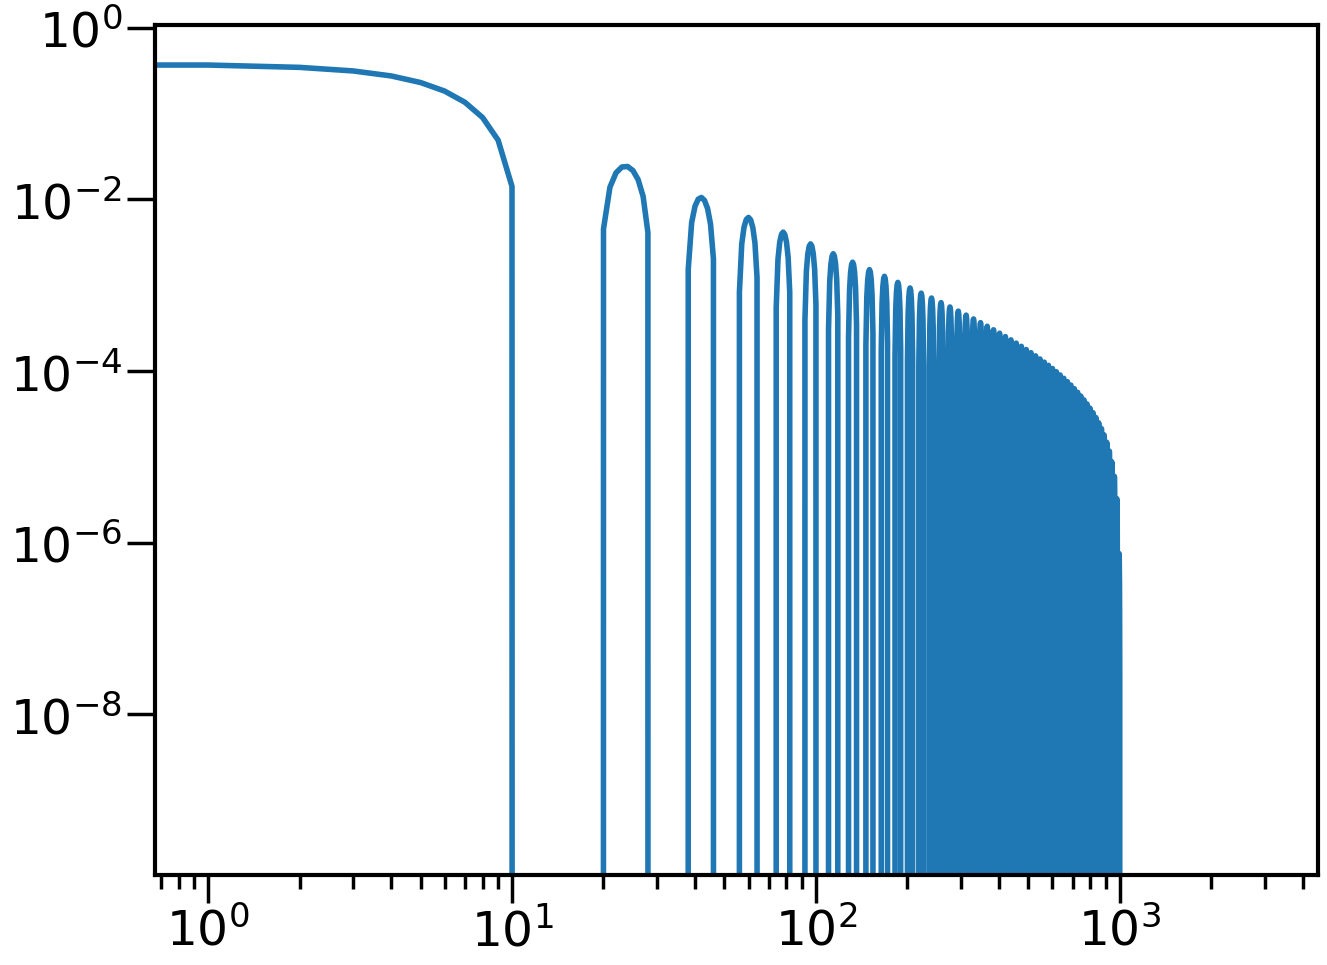

In [52]:
plot(l,wl_inv)
loglog()

saved to  ./figures/correlation_apodized_scale_cut.pdf


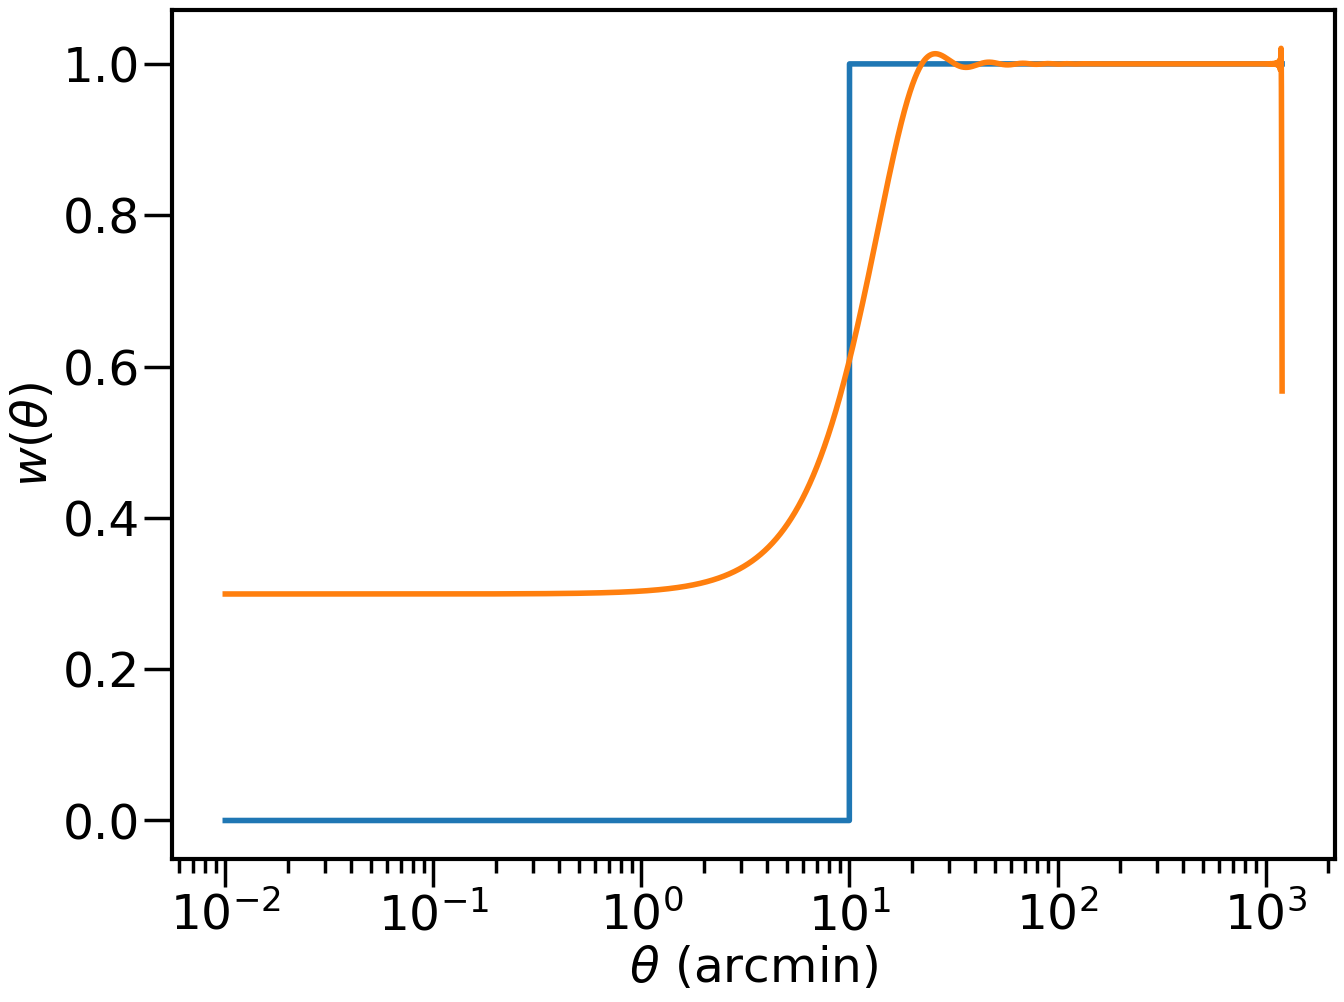

In [53]:
plot(th*60,xi_t,label='top hat')
plot(th*60,xi_t2,label='Apodized')
xscale('log')
xlabel(r'$\theta$ (arcmin)')
ylabel(r'$w(\theta)$')
fname='correlation_apodized_scale_cut'
fname=fig_home+fname
fname+='.pdf'
savefig(fname,bbox_inches='tight',format='pdf')
print('saved to ',fname)    


In [54]:
Mwb=kappa_xi0_ub.binning.bin_1d(xi=Mw.T,bin_utils=cl_bu)
Mwb=Mwb.T

In [55]:
Mb=kappa_xi0_ub.binning.bin_2d_coupling(M=M,bin_utils=cl_bu,wt0=cl0_0[corr][bi],wt_b=1./cl0[corr][bi])

<ipython-input-56-d5ea3281fc11>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolor(lb,lb,Mb*-1,cmap='Blues',rasterized=True,norm=LogNorm(),vmax=1,vmin=1.e-6)
<ipython-input-56-d5ea3281fc11>:1: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  pcolor(lb,lb,Mb*-1,cmap='Blues',rasterized=True,norm=LogNorm(),vmax=1,vmin=1.e-6)
<ipython-input-56-d5ea3281fc11>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='a

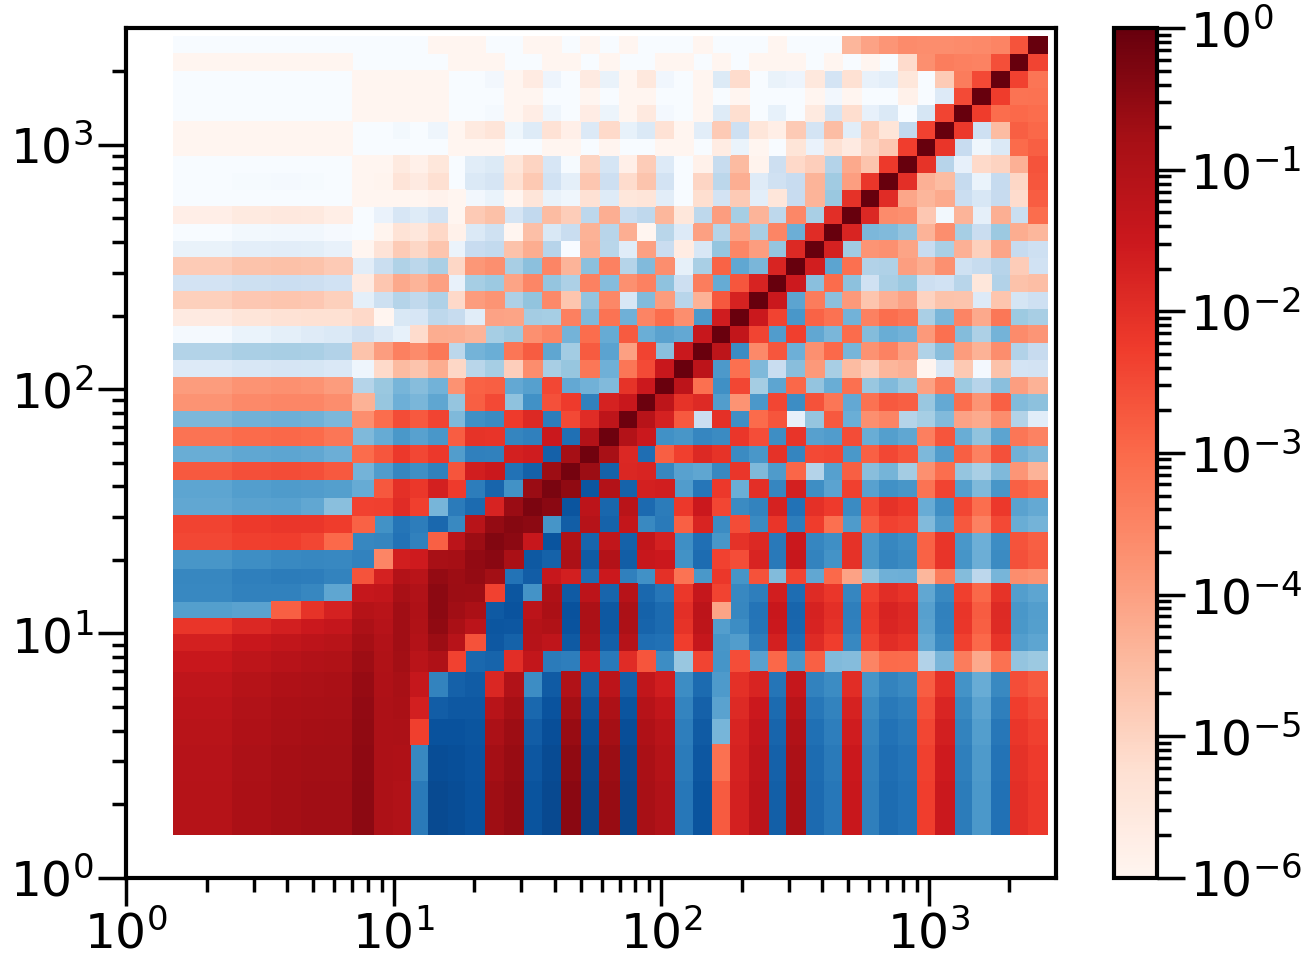

In [56]:
pcolor(lb,lb,Mb*-1,cmap='Blues',rasterized=True,norm=LogNorm(),vmax=1,vmin=1.e-6)
pcolor(lb,lb,Mb,cmap='Reds',rasterized=True,norm=LogNorm(),vmax=1,vmin=1.e-6)
colorbar()
loglog()
xlim(1,l0c.max())
ylim(1,l0c.max())
show()

saved to  ./figures/WT_inv_th_min_comp_convolve_binned_gg.pdf


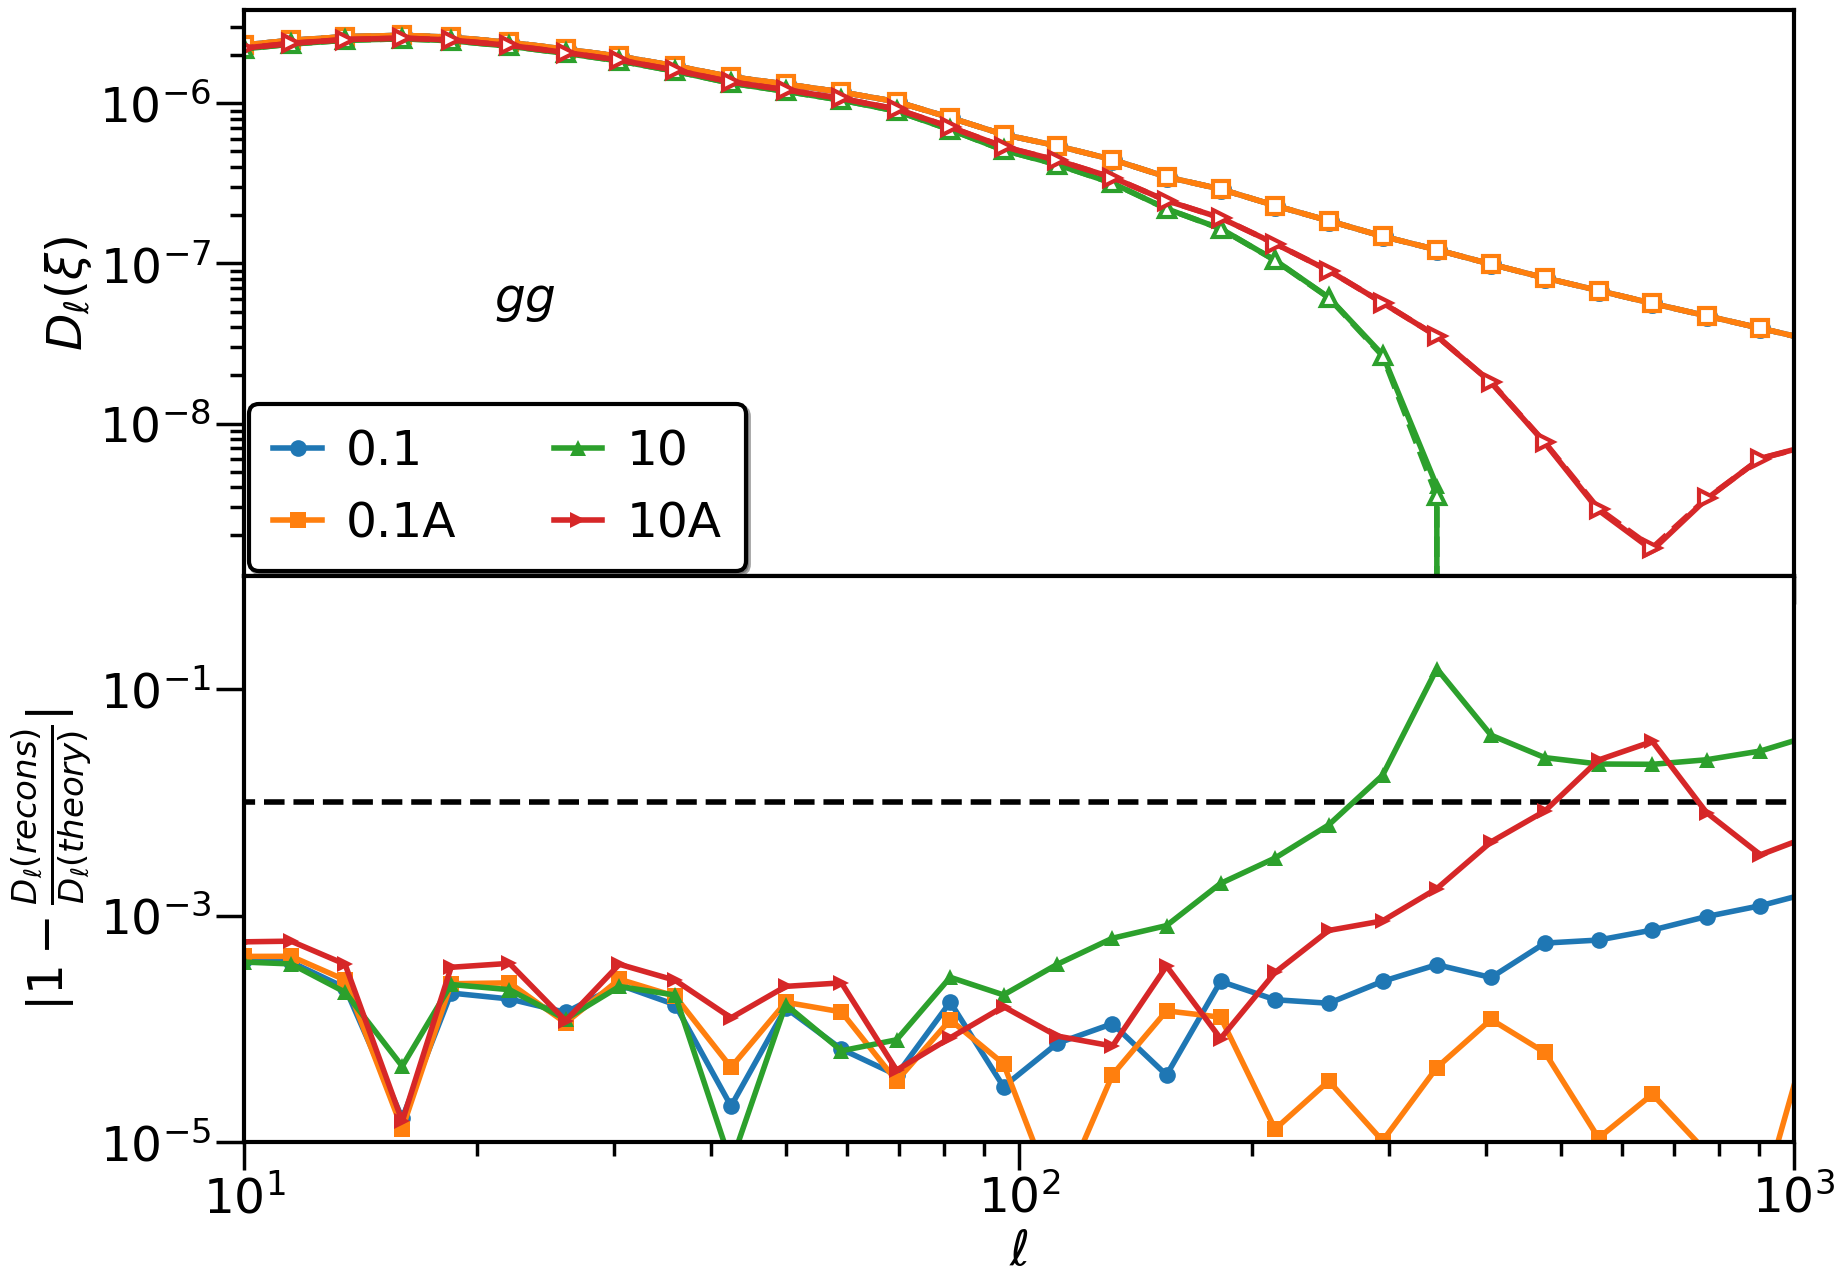

In [57]:
fig, ax =subplots(2,1,figsize=(20,15),sharex='col',sharey='row')
pS=ax[0]
pR=ax[1]
# l_inv,cl_inv=WT.inv_projected_correlation(theta_xi=th*d2r,xi=xi0ub[corr][s][bi],s1_s2=s,wig_d=WT.wig_d[s].T,wig_norm=WT.inv_wig_norm)
# pS.plot(l_inv,cl0_0[corr][bi],alpha=1,zorder=10,c='k')
# pS.plot(l_inv,cl_inv,c=colors[0],alpha=0.5)
# pS.plot(lb,wd_bi2@xi0b[corr][s][bi],c=colors[0],marker=markers[0],label=str(theta_min*60),lw=0)



# pR.plot(l_inv,1-cl_inv/cl0_0[corr][bi],c=colors[0],alpha=0.5)
# pR.plot(lb,1-wd_bi2@xi0b[corr][s][bi]/cl0[corr][bi],c=colors[0],marker=markers[0],label=str(theta_min*60),lw=0)

thcs=[.1,10]
th_max=600
i=0
for thc in thcs:
    x=th*60>thc
    xi_t=np.ones_like(xi0ub[corr][s][bi])
#     xi_t[~x]=np.cos((th[~x]-th[x].min())/(th[x].min()-theta_min)*np.pi/2.)
    xi_t[~x]=0

    xi_tb=kappa_xi0_ub.binning.bin_1d(xi=xi_t,bin_utils=xi_bu[s])
#     x=thb*60>thc
#     xi_tb=np.ones_like(xi0[corr][s][bi])
#     xi_tb[~x]=0
    cl_inv_b=wd_bi2@(xi0[corr][s][bi]*xi_tb)
    
    l_inv,wl_inv=WT.inv_projected_correlation(theta_xi=th*d2r,wig_theta=th*d2r,xi=xi_t,
                                              s1_s2=s,wig_d=WT.wig_d[s].T,wig_norm=WT.inv_wig_norm)
    
#     cl_inv2=Mwb@wl_inv[wl0c]#*(2*wl0c+1))
    cl_inv2=Mw@wl_inv[wl0c]#*(2*wl0c+1))
    cl_inv2=kappa_xi0_ub.binning.bin_1d(xi=cl_inv2,bin_utils=cl_bu)
    pR.plot(lb,np.absolute(cl_inv2/cl_inv_b-1),c=colors[i],marker=markers[i])#,label=r'$\theta_{min}=$'+str(thc))
    pS.plot(lb,cl_inv2,c=colors[i],label=str(thc),marker=markers[i])
    pS.plot(lb,cl_inv_b,c=colors[i],ls='--',marker=markers[i],mfc='white',mew=3)
    
    i+=1

    
    x=l_inv<l_smooth_min/thc
    x2=l_inv<l_smooth_max
    x=x*x2
    wl_inv[~x]*=np.cos((l_inv[~x]-l_inv[x].max())/(l_smooth_max-l_inv[x].max())*np.pi/2.)
    wl_inv[~x2]*=0

    tht,xi_t2=WT.projected_correlation(l_cl=l_inv,cl=wl_inv,s1_s2=s,wig_d=WT.wig_d[s],wig_norm=WT.wig_norm)
    
    xi_tb2=kappa_xi0_ub.binning.bin_1d(xi=xi_t2,bin_utils=xi_bu[s])
    cl_inv_b=wd_bi2@(xi0[corr][s][bi]*xi_tb2)
    
    l_inv,cl_inv=WT.inv_projected_correlation(theta_xi=th*d2r,wig_theta=th*d2r,xi=xi0ub[corr][s][bi]*xi_t2,
                                              s1_s2=s,wig_d=WT.wig_d[s].T,wig_norm=WT.inv_wig_norm)
    
    cl_inv2=Mwb@wl_inv[wl0c]#*(2*wl0c+1))
    pS.plot(lb,cl_inv2,c=colors[i],label=str(thc)+'A',marker=markers[i])
    pS.plot(lb,cl_inv_b,c=colors[i],ls='--',marker=markers[i],mfc='white',mew=3)

    pR.plot(lb,np.absolute(cl_inv2/cl_inv_b-1),c=colors[i],ls='-',marker=markers[i])#,label=r'$\theta_{min}=$'+str(thc))
    i+=1
    
pR.hlines(0,1,2000,color='k')
pR.hlines(.01,1,2000,color='k',ls='--')
pR.hlines(-0.01,1,2000,color='k',ls='--')
pR.set_xscale('log')
pS.set_yscale('log')
pR.set_yscale('log')
# pR.set_yscale('symlog',linthreshy=0.01)
pR.set_ylim(1.e-5,1)
# pS.set_ylim(5.e-9,5.e-6)
pR.set_xlim(10,1000)
pR.set_xlabel('$\ell$')
pR.set_ylabel(r'$|1-\frac{D_\ell(recons)}{D_\ell (theory)}|$')
pS.set_ylabel(r'$D_\ell (\xi)$')
pS.text(x=21,y=5e-8,s=corr_labels[corr][s])
pS.legend(loc='lower left',ncol=2)
fname='WT_inv_th_min_comp_convolve_binned_'+corr_fnames[corr][s]
fname=fig_home+fname
fname+='.pdf'
fig.savefig(fname,bbox_inches='tight',format='pdf')
print('saved to ',fname)    
show()

In [58]:
plot(thb,xi_tb)
plot(thb,xi_tb2)
xscale('log')

In [59]:
fig, ax =subplots(2,1,figsize=(20,15),sharex='col',sharey='row')
pS=ax[0]
pR=ax[1]
pS.plot(l0,cl0_0[corr][bi],alpha=1,zorder=10,c='k')



# pR.plot(l_inv,1-cl_inv/cl0_0[corr][bi],c=colors[0],alpha=0.5)
# pR.plot(lb,1-wd_bi2@xi0b[corr][s][bi]/cl0[corr][bi],c=colors[0],marker=markers[0],label=str(theta_min*60),lw=0)

thcs=[0]
th_max=600
i=0
for thc in thcs:
    x=th*60>thc
    xi_t=np.ones_like(xi0ub[corr][s][bi])
    xi_t[~x]=0

    l_inv,wl_inv=WT.inv_projected_correlation(theta_xi=th*d2r,wig_theta=th*d2r,xi=xi_t,
                                              s1_s2=s,wig_d=WT.wig_d[s].T,wig_norm=WT.inv_wig_norm)
        
    x=l_inv<l_smooth_min
    x2=l_inv<l_smooth_max
    x=x*x2
    wl_inv[~x]*=np.cos((l_inv[~x]-l_inv[x].max())/(l_smooth_max-l_inv[x].max())*np.pi/2.)
    wl_inv[~x2]*=0

    tht,xi_t2=WT.projected_correlation(l_cl=l_inv,cl=wl_inv,s1_s2=s,wig_d=WT.wig_d[s],wig_norm=WT.wig_norm)
    
    xi_tb2=kappa_xi0_ub.binning.bin_1d(xi=xi_t2,bin_utils=xi_bu[s])
    cl_inv_b=wd_bi2@(xi0[corr][s][bi]*xi_tb2)
    
    Mi=np.linalg.inv(Mb)
    cl2=(Mi@wd_bi2)@(xi0[corr][s][bi]*xi_tb2)
#     cl2=Mi@cl_inv_b
#     cl2=M@cl0_0[corr][bi]
#     cl2=Mb@cl0[corr][bi]
    pS.plot(lb,cl2,c=colors[i],label=str(thc)+'A',marker=markers[i])
#     pS.plot(l0c,cl2,c=colors[i],label=str(thc)+'A',marker=markers[i])

    pR.plot(lb,np.absolute(cl2/cl0[corr][bi]-1),c=colors[i],ls='-',marker=markers[i])#,label=r'$\theta_{min}=$'+str(thc))
    i+=1
    
pR.hlines(0,1,2000,color='k')
pR.hlines(.01,1,2000,color='k',ls='--')
pR.hlines(-0.01,1,2000,color='k',ls='--')
pR.set_xscale('log')
pS.set_yscale('log')
pR.set_yscale('log')
# pR.set_yscale('symlog',linthreshy=0.01)
pR.set_ylim(1.e-4,1)
# pS.set_ylim(5.e-9,5.e-6)
pR.set_xlim(10,1000)
pR.set_xlabel('$\ell$')
pR.set_ylabel(r'$|1-\frac{C_\ell(recons)}{D_\ell (theory)}|$')
pS.set_ylabel(r'$C_\ell (\xi)$')
pS.text(x=21,y=5e-8,s=corr_labels[corr][s])
pS.legend(loc='upper right',ncol=2)
fname='WT_inv_th_min_comp_convolve_binned_imaster_'+corr_fnames[corr][s]
fname=fig_home+fname
fname+='.pdf'
# fig.savefig(fname,bbox_inches='tight',format='pdf')
print('saved to ',fname)    
show()

saved to  ./figures/WT_inv_th_min_comp_convolve_binned_imaster_gg.pdf


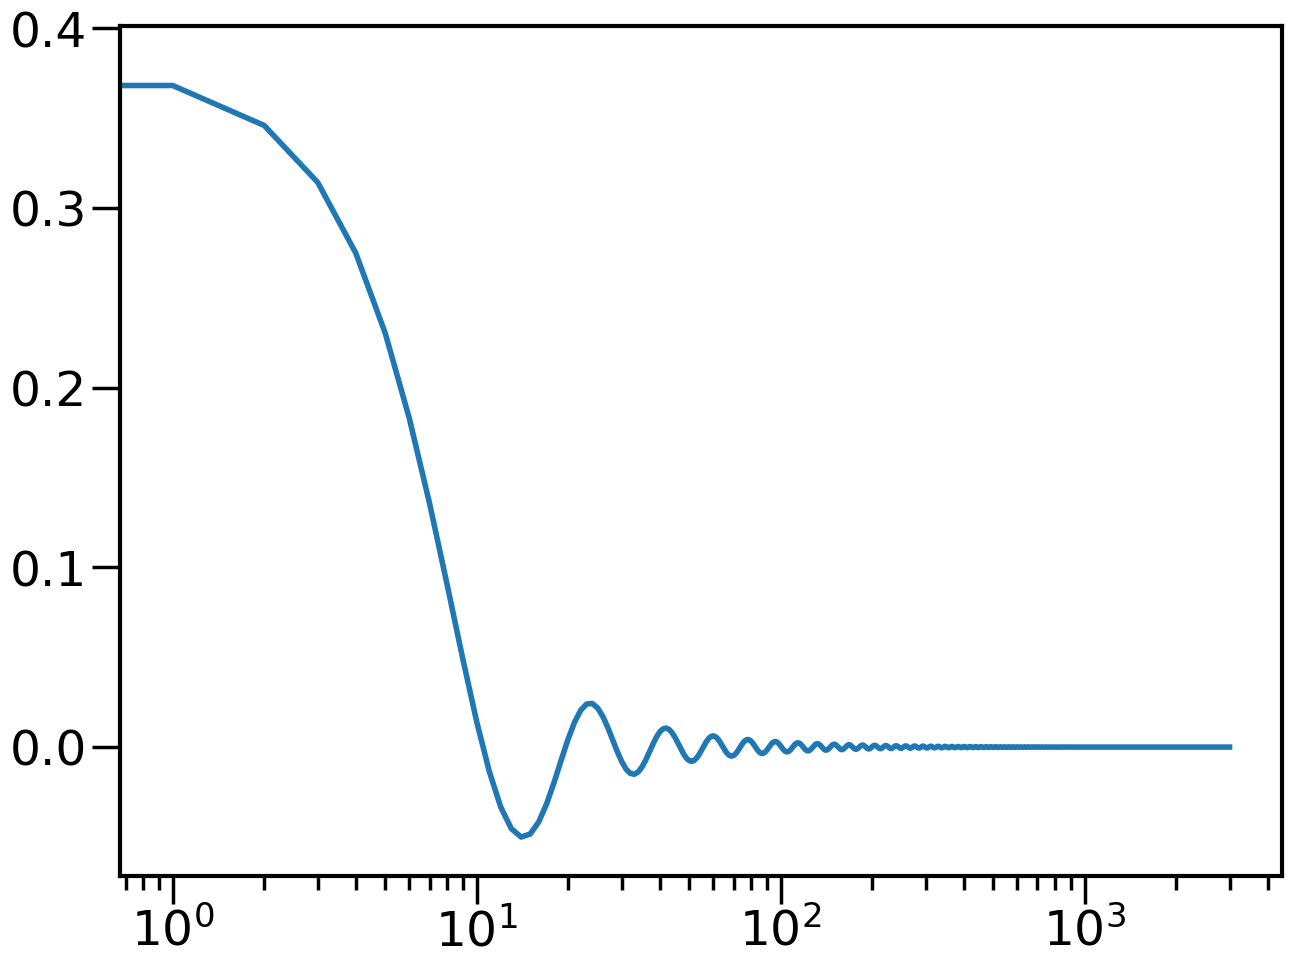

In [60]:
plot(l_inv,wl_inv)
xscale('log')

In [61]:
fig, ax =subplots(2,1,figsize=(20,15),sharex='col',sharey='row')
pS=ax[0]
pR=ax[1]
# l_inv,cl_inv=WT.inv_projected_correlation(theta_xi=th*d2r,xi=xi0ub[corr][s][bi],s1_s2=s,wig_d=WT.wig_d[s].T,wig_norm=WT.inv_wig_norm)
# pS.plot(l_inv,cl0_0[corr][bi],alpha=1,zorder=10,c='k')
# pS.plot(l_inv,cl_inv,c=colors[0],alpha=0.5)
# pS.plot(lb,wd_bi2@xi0b[corr][s][bi],c=colors[0],marker=markers[0],label=str(theta_min*60),lw=0)



# pR.plot(l_inv,1-cl_inv/cl0_0[corr][bi],c=colors[0],alpha=0.5)
# pR.plot(lb,1-wd_bi2@xi0b[corr][s][bi]/cl0[corr][bi],c=colors[0],marker=markers[0],label=str(theta_min*60),lw=0)

thcs=[0,.1,10]
th_max=600
i=1
for thc in thcs:
    x=th*60>thc
    xi_t=np.ones_like(xi0ub[corr][s][bi])
    xi_t[~x]=np.cos((th[~x]-th[x].min())/(th[x].min()-theta_min)*np.pi/2.)
#     xi_t[~x]=0

    x=th*60<th_max
    xi_t[~x]=np.cos((th[~x]-th[x].max())/(theta_max-th[x].max())*np.pi/2.)

    
    l_inv,cl_inv=WT.inv_projected_correlation(theta_xi=th*d2r,wig_theta=th*d2r,xi=xi0ub[corr][s][bi]*xi_t,
                                              s1_s2=s,wig_d=WT.wig_d[s].T,wig_norm=WT.inv_wig_norm)
    cl_inv0=cl0_0[corr][bi][l0c]
    
    
    l_inv,wl_inv=WT.inv_projected_correlation(theta_xi=th*d2r,wig_theta=th*d2r,xi=xi_t,
                                              s1_s2=s,wig_d=WT.wig_d[s].T,wig_norm=WT.inv_wig_norm)
    
    cl_inv2=Mw@wl_inv[wl0c]#*(2*wl0c+1))
    pR.plot(l_inv[l0c],cl_inv2-cl_inv[l0c],c=colors[i])#,label=r'$\theta_{min}=$'+str(thc))
    pS.plot(l_inv[l0c],cl_inv2,c=colors[i],label=str(thc),)#,label=r'$\theta_{min}=$'+str(thc))
    
#     i+=1
#     cl_inv3=M@(cl0_0[corr][bi][l0c])#*(2*l0c+1))
#     pR.plot(l_inv[l0c],cl_inv3/cl_inv[l0c]-1,c=colors[i])#,label=r'$\theta_{min}=$'+str(thc))
#     pS.plot(l_inv[l0c],cl_inv3,c=colors[i],ls='--')#,label=r'$\theta_{min}=$'+str(thc))

    i+=1
    pS.plot(l_inv[l0c],cl_inv0,c=colors[i],zorder=-1)#,label=r'$\theta_{min}=$'+str(thc))
    pS.plot(l_inv[l0c],cl_inv[l0c],c=colors[i],ls=':')#,label=r'$\theta_{min}=$'+str(thc))
    i+=1
pR.set_xscale('log')
pS.set_yscale('log')
# pR.set_yscale('log')
# pR.set_yscale('symlog',linthreshy=0.01)
# pR.set_ylim(0.001,1)
# pS.set_ylim(5.e-9,5.e-6)
pR.set_xlim(10,1000)
pR.set_xlabel('$\ell$')
pR.set_ylabel(r'$1-\frac{C_\ell(recons)}{C_\ell (theory)}$')
pS.set_ylabel(r'$C_\ell$')
pS.text(x=21,y=5e-8,s=corr_labels[corr][s])
pS.legend(loc='upper right',ncol=2)
fname='WT_inv_th_min_comp_convolve_'+corr_fnames[corr][s]
fname=fig_home+fname
fname+='.pdf'
# fig.savefig(fname,bbox_inches='tight',format='pdf')
print('saved to ',fname)    
show()

saved to  ./figures/WT_inv_th_min_comp_convolve_gg.pdf


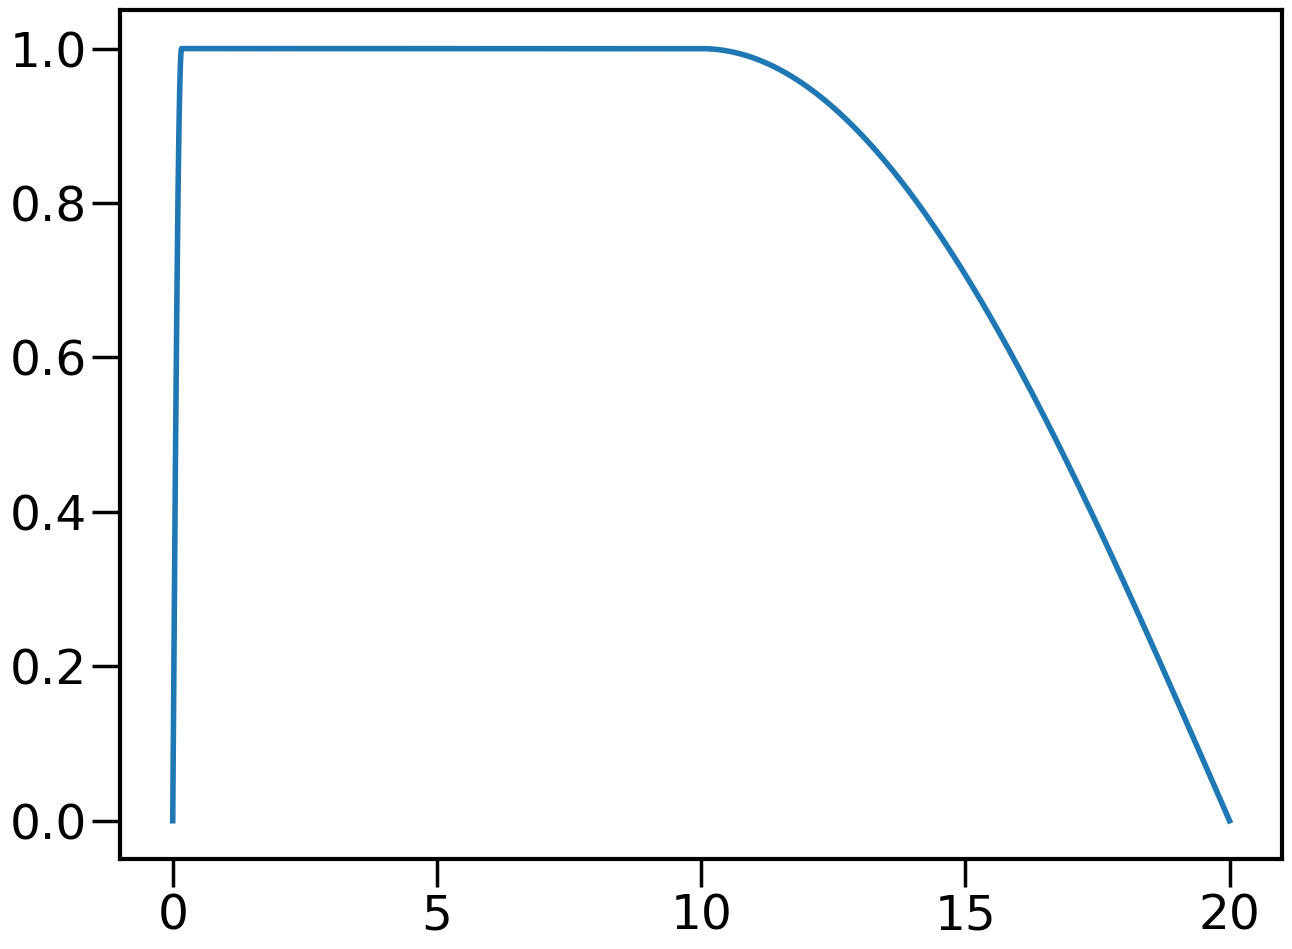

In [62]:
plot(th,xi_t)
# loglog()

[]

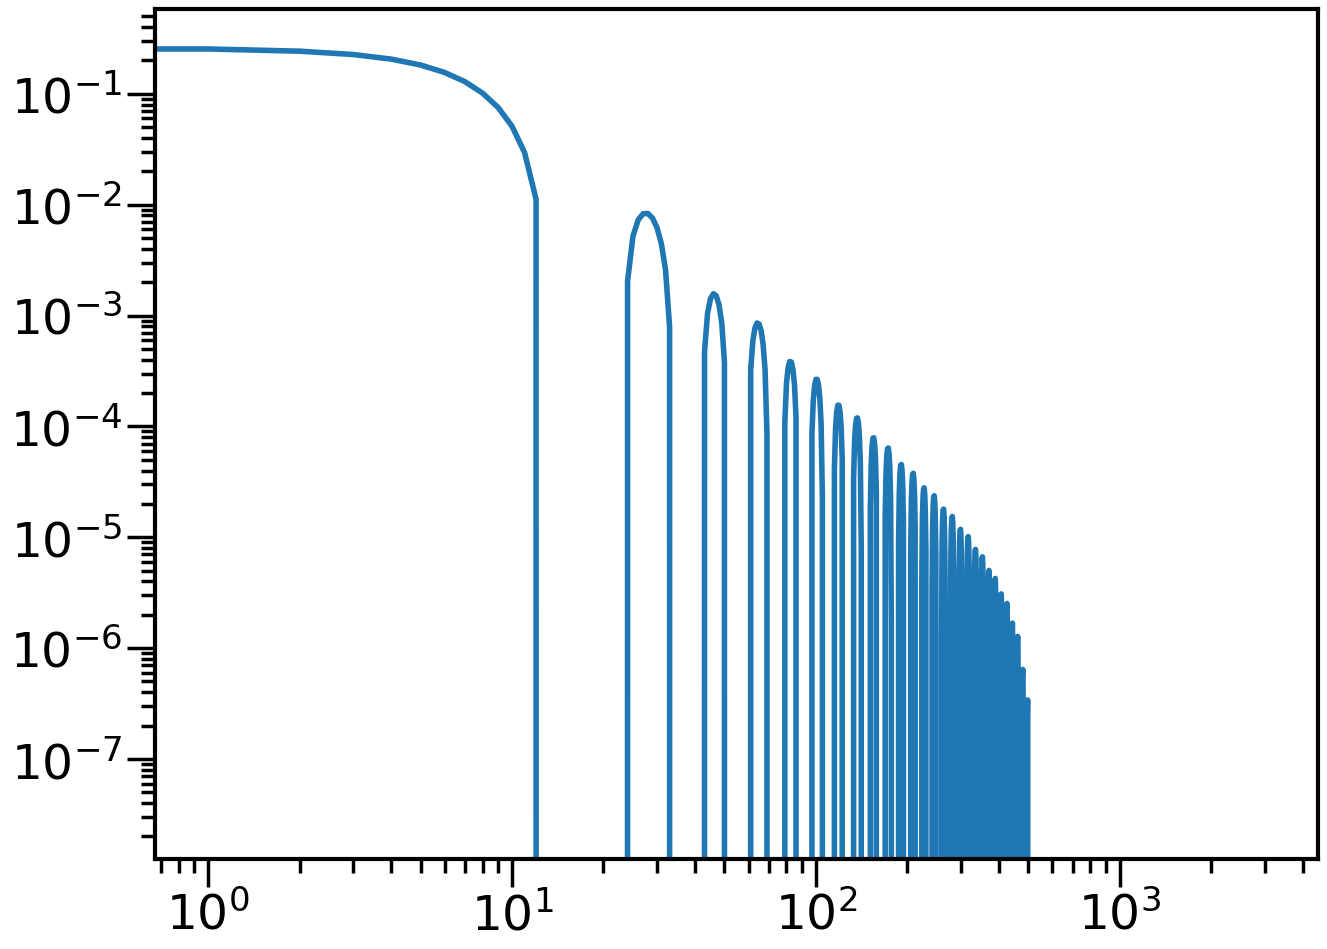

In [63]:
plot(l_inv,wl_inv)
loglog()

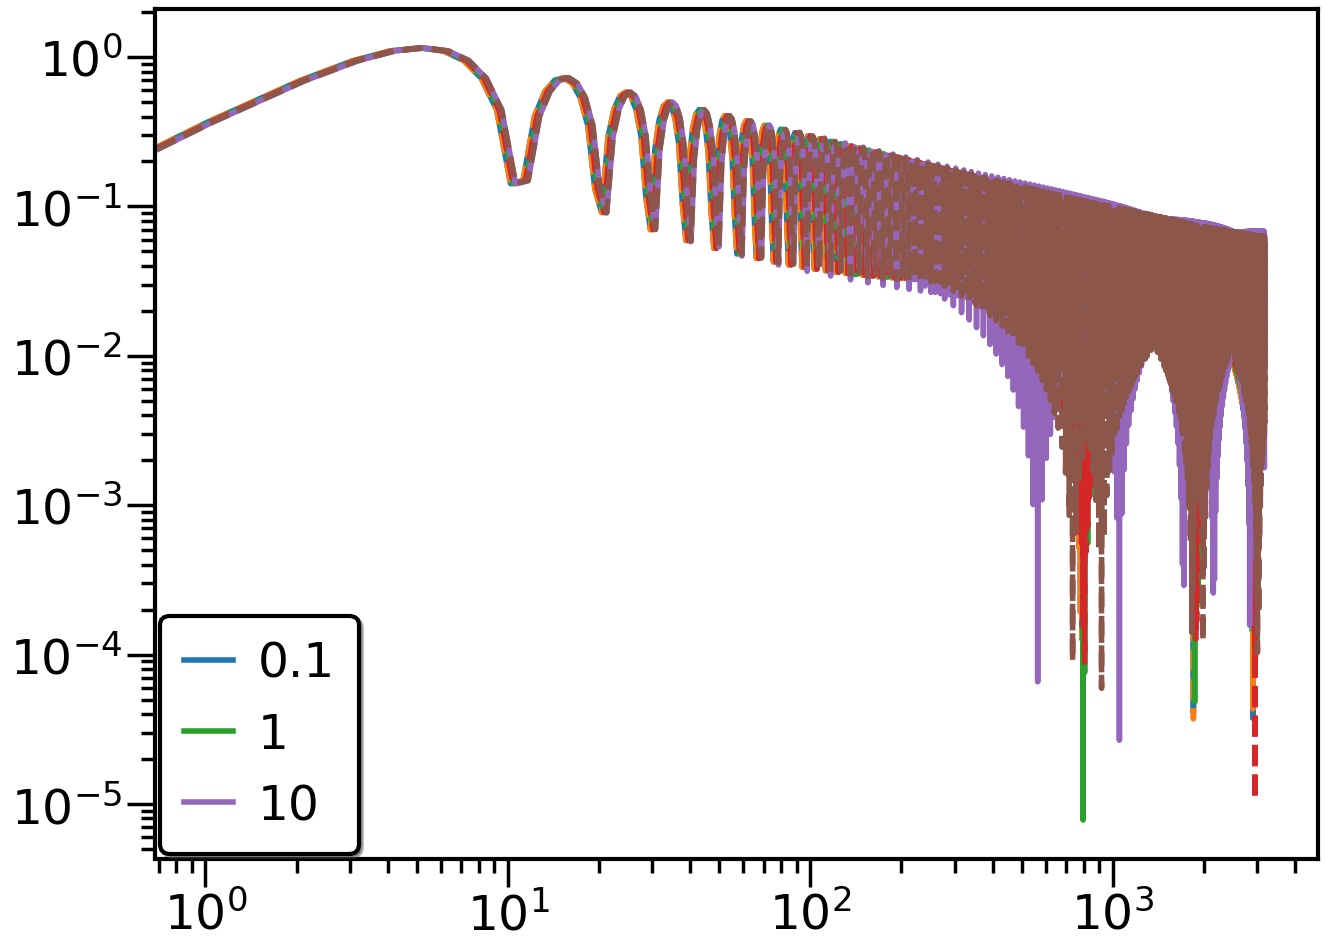

In [64]:
thcs=[0.1,1,10]
i=1
for thc in thcs:
    x=th*60>thc
    xi_t=np.ones_like(xi0ub[corr][s][bi])
    xi_t[~x]=0
    l_inv,wl_inv=WT.inv_projected_correlation(theta_xi=th*d2r,wig_theta=th*d2r,xi=xi_t,
                                              s1_s2=s,wig_d=WT.wig_d[s].T,wig_norm=WT.inv_wig_norm)
    wl_inv=np.absolute(wl_inv)
    plot(l_inv*(1.+i*.02),l_inv**1*wl_inv,label=thc)
    
    xi_t=np.ones_like(xi0ub[corr][s][bi])
    xi_t[~x]=np.cos((th[~x]-th[x].min())/(th[x].min()-theta_min)*np.pi/2.)
#     xi_t[~x]=0

#     x=th*60<th_max
#     xi_t[~x]=np.cos((th[~x]-th[x].max())/(theta_max-th[x].max())*np.pi/2.)
    
    l_inv,wl_inv=WT.inv_projected_correlation(theta_xi=th*d2r,wig_theta=th*d2r,xi=xi_t,
                                              s1_s2=s,wig_d=WT.wig_d[s].T,wig_norm=WT.inv_wig_norm)
    wl_inv=np.absolute(wl_inv)
    plot(l_inv*(1.+i*.02),l_inv**1*wl_inv,'--')

    
    xscale('log')
    yscale('log')
#     yscale('symlog',linthreshy=0.01)
    i+=1
legend()

In [65]:
thcs=[0.1]
i=1
for thc in thcs:
    x=th*60>thc
    l_inv,cl_inv=WT.inv_projected_correlation(theta_xi=th[x]*d2r,wig_theta=th[x]*d2r,xi=xi0ub[corr][s][bi][x],
                                              s1_s2=s,wig_d=WT.wig_d[s][x,:].T,wig_norm=WT.inv_wig_norm[x])
    
    xi_t=np.ones_like(xi0ub[corr][s][bi])
    xi_t[~x]=0
    l_inv,wl_inv=WT.inv_projected_correlation(theta_xi=th*d2r,wig_theta=th*d2r,xi=xi_t,
                                              s1_s2=s,wig_d=WT.wig_d[s].T,wig_norm=WT.inv_wig_norm)
    M=wj2@(wl_inv[wl0c]*(2*wl0c+1))
    M/=4.*np.pi
    M*=wu.MF
    cl_inv2=cl0_0[corr][bi][l0c]@M
    plot(l_inv[l0c],cl_inv2/cl_inv[l0c]-1,c=colors[i],alpha=0.5)#,label=r'$\theta_{min}=$'+str(thc))
    i+=1
    cl_inv2=M@cl0_0[corr][bi][l0c]
    plot(l_inv[l0c],cl_inv2/cl_inv[l0c]-1,c=colors[i],alpha=0.5)#,label=r'$\theta_{min}=$'+str(thc))

#     plot(l_inv[l0c],cl_inv2,c=colors[i])#,label=r'$\theta_{min}=$'+str(thc))
#     plot(l_inv[l0c],cl_inv[l0c],c=colors[i],label=str(thc),ls=':')#,label=r'$\theta_{min}=$'+str(thc))

    i+=1
# loglog()
xscale('log')
xlim(1,1000)
yscale('log')
ylim(0.01,2)
hlines(1,10,1000)


NameError: name 'wj2' is not defined

In [ ]:
pcolor(M,cmap='Reds',norm=LogNorm())
colorbar()

In [ ]:
thcs=[0.1,1,10]
i=0
for thc in thcs:
    x=th*60>thc
    l_inv,cl_inv=WT.inv_projected_correlation(theta_xi=th[x]*d2r,wig_theta=th[x]*d2r,xi=xi0ub[corr][s][bi][x],s1_s2=s,wig_d=WT.wig_d[s][x,:].T,wig_norm=WT.inv_wig_norm[x])
    plot(l_inv,cl_inv/cl0_0[corr][bi],c=colors[i],label=r'$\theta_{min}=$'+str(thc))
    i+=1
hlines(1,1,2000,color='k')
hlines(1.01,1,2000,color='k',ls='--')
hlines(.99,1,2000,color='k',ls='--')
xscale('log')
ylim(0.9,1.121)
xlim(10,5000)
legend()

In [ ]:
plot(thb,(wd_b@(wd_bi2@xi0b[corr][s][bi]))/xi0b[corr][s][bi])
# hlines(1,1,2000,color='k')
hlines(1.01,1,2000,color='k',ls='--')
hlines(.99,1,2000,color='k',ls='--')
xscale('log')
ylim(0.95,1.05)

In [ ]:
#bin centers need to be chosen carefully!!
plot(thb,wd_b@cl0[corr][bi]/xi0[corr][s][bi]) #difference is due to effective xi bin centers.
hlines(1,.1,10,color='k')
xscale('log')
# ylim(0.98,1.021)
show()
plot(lb,wd_bi@xi0[corr][s][bi]/cl0[corr][bi]) #difference is due to effective xi bin centers.
hlines(1,1,2000,color='k')
xscale('log')
ylim(0.98,1.021)

In [ ]:
plot(thb,thb*(wd_b@cl0[corr][bi]))
plot(thb,thb*xi0[corr][s][bi])
# hlines(1,.1,10,color='k')
xscale('log')
# ylim(0.98,1.021)

In [ ]:
crash

In [ ]:
bin_xi=True
bin_cl=True
theta_min2=.05/60
# theta_min=hp.nside2resol(512, arcmin = True)/60 #100/nside #1./60
theta_max2=600./60
n_theta_bins=25
# theta_bins,th=get_theta_bins(theta_min=theta_min,theta_max=theta_max,N_bins=n_theta_bins,binning_scheme='log',n_theta_samples=40)#,max_modes=1)
theta_bins2=np.logspace(np.log10(theta_min2),np.log10(theta_max2),n_theta_bins+1)
th2=np.logspace(np.log10(theta_min2),np.log10(theta_max2),n_theta_bins*80)
# th2_2=np.logspace(np.log10(theta_min2*.01),np.log10(theta_min2),40)
# th2_2=np.append([0],th2_2)
# th2=np.sort(np.unique(np.append(th2_2,th2)))
thb2=0.5*(theta_bins2[1:]+theta_bins2[:-1])
n_theta_bins=len(thb2)

l0_2=np.arange(1e4)

#Hankel Transform setup
WT_kwargs2={'l':l0_2,'theta':th2*d2r,'s1_s2':[(2,2),(2,-2),(0,0),(0,2),(2,0)],
           'wig_d_taper_order_low':None,'wig_d_taper_order_high':None}
# if globals().get('WT') is None:
WT2=wigner_transform(**WT_kwargs2 )
WT2.gather_data()

/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/wigner_functions.py:46: RuntimeWarning: invalid value encountered in true_divide


In [15]:
bb=binning()
xi_bu=bb.bin_utils(r=th2,r_bins=theta_bins2,mat_dims=[1,2])

In [16]:
corrs=[corr_gg,corr_ll,corr_ggl]

In [17]:
kappa_xi0_2=Skylens(shear_zbins=shear_zbins,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0_2, galaxy_zbins=galaxy_zbins,corrs=corrs,
                       use_window=use_window,Tri_cov=Tri_cov,
                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=0.35,
                       store_win=store_win,window_lmax=window_lmax,
                      do_xi=do_xi,bin_xi=True,theta_bins=th2,WT=WT2,
                      use_binned_l=False,use_binned_theta=False,
                      nz_PS=10,do_pseudo_cl=False)

Tracer utils has tracers:  ['shear', 'galaxy']
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 4.005
power spectra camb_pk_too_many_z
Win gen: step size 1 10000 513.0 10
Window done. Size: 0.0


/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/cov_utils.py:92: RuntimeWarning: invalid value encountered in true_divide
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/angular_power_spectra.py:23: RuntimeWarning: divide by zero encountered in true_divide


In [18]:
shear_zbins[0].keys()

dict_keys(['z', 'dz', 'nz', 'ns', 'W', 'pz', 'pzdz', 'Norm', 'b1', 'bz1', 'AI', 'AI_z', 'mag_fact', 'shear_m_bias', 'lm', 'k_max'])

In [28]:
wlt0=hp.anafast(shear_zbins[0]['window'])
window0=np.ones_like(shear_zbins[0]['window'])
wlt00=hp.anafast(window0)

In [30]:
wlt0=wlt00

[]

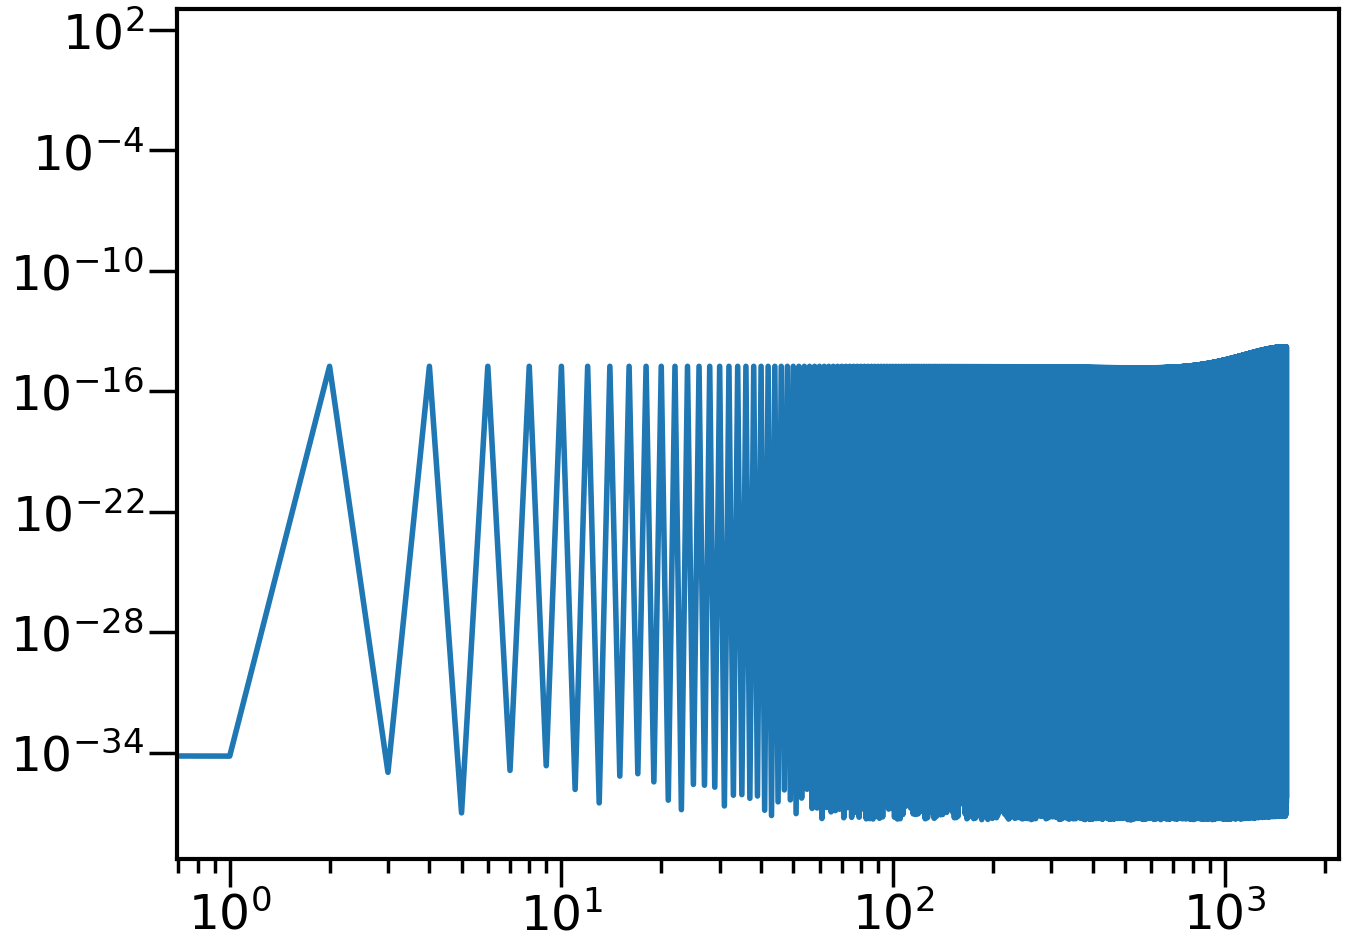

In [31]:
plot(wlt0)
loglog()

In [32]:
tht,xi_00=WT2.projected_correlation(l_cl=np.arange(len(wlt0)),cl=wlt0,s1_s2=(0,0))
tht,xi_02=WT2.projected_correlation(l_cl=np.arange(len(wlt0)),cl=wlt0,s1_s2=(0,2))
tht,xi_22=WT2.projected_correlation(l_cl=np.arange(len(wlt0)),cl=wlt0,s1_s2=(2,2))

[]

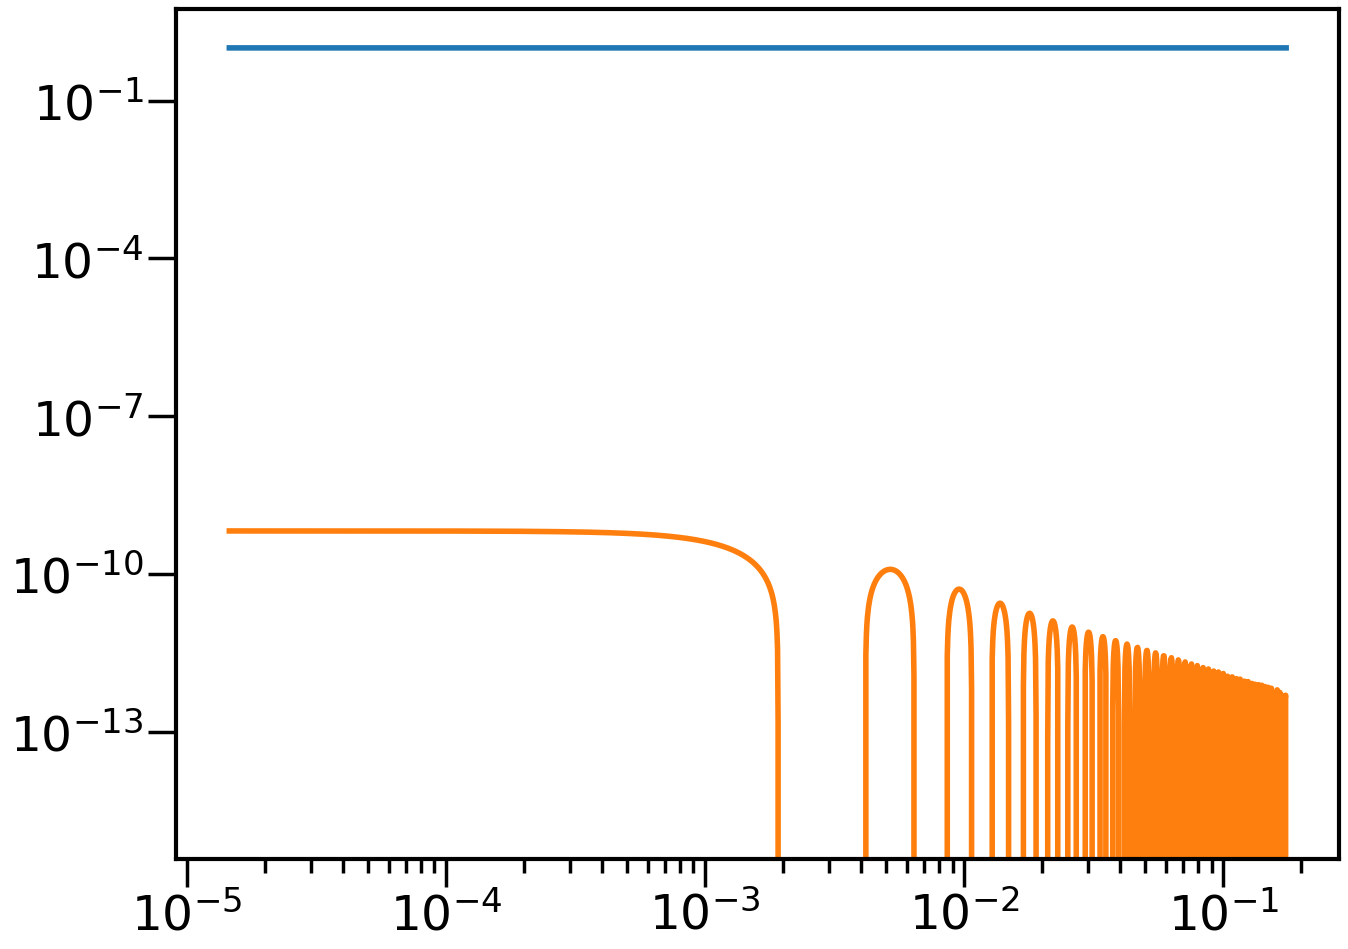

In [33]:
plot(tht,xi_00)
plot(tht,xi_22)
loglog()

In [17]:
xi0_2G=kappa_xi0_2.xi_tomo()
# %time xiH_b2=xiHG_b2['stack'].compute()
%time xi0_2=client.compute(xi0_2G['xi']).result()

/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/angular_power_spectra.py:115: RuntimeWarning: divide by zero encountered in true_divide


scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
Done xi graph 0.002397 960.816
CPU times: user 156 ms, sys: 785 ms, total: 941 ms
Wall time: 1.39 s


In [18]:
clG_2=kappa_xi0_2.cl_tomo()
# %time xiH_b2=xiHG_b2['stack'].compute()
%time cl0_2=client.compute(clG_2['cl']).result()

scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
CPU times: user 35.9 ms, sys: 3.71 ms, total: 39.6 ms
Wall time: 310 ms


In [19]:
l0_2=np.int64(l0_2)

In [133]:
l0.max(),l0_2.max()

(2999, 9999)

In [221]:
def l_cut_coupling2(WT,l_cl=None,theta_out=None,l_cut_weights=None,s1_s2=None,taper=False,**kwargs):
        self=WT
        if l_cut_weights is None:
            l_cl=self.l
            l_cut_weights=self.l_cut_weights
        if s1_s2 is None:
            s1_s2=self.s1_s2s
        theta_coupling={}
        theta_coupling_mat={}
        for (m1,m2) in s1_s2:
            lw=l_cut_weights*1.
            dth=2*np.pi*np.gradient(theta_out)*np.sin(theta_out)
            s=(m1,m2) #(0,0)
            th,theta_coupling[(m1,m2)]=self.projected_correlation(l_cl=l_cl,cl=lw,taper=taper,s1_s2=s,**kwargs)
            th,theta_coupling_mat[(m1,m2)]=self.projected_covariance(l_cl=l_cl,cl_cov=lw,taper=taper,s1_s2=s,**kwargs)
            theta_coupling_mat[(m1,m2)]*=dth
        return theta_coupling,theta_coupling_mat

In [223]:
l_cut_weights=np.ones_like(l0_2,dtype='float64')

l_max_cut=3000#l0.max()
l_min_cut=np.int(l_max_cut*.66)
x=l0_2<l_min_cut
l_cut_weights[~x]=np.cos((l0_2[~x]*1.-l0_2[x].max())/(l_max_cut-l0_2[x].max())*np.pi/2.)

x=l0_2<l_max_cut
l_cut_weights[~x]=0

thc,thc_m=WT2.l_cut_coupling(l_cl=l0_2,l_cut_weights=l_cut_weights,taper=False)

l_cut_coupling: (2000, 2000) (2000,) (2000, 2000)
l_cut_coupling: (2000, 2000) (2000,) (2000, 2000)
l_cut_coupling: (2000, 2000) (2000,) (2000, 2000)
l_cut_coupling: (2000, 2000) (2000,) (2000, 2000)
l_cut_coupling: (2000, 2000) (2000,) (2000, 2000)


In [224]:
thc2,thc_m2=l_cut_coupling2(WT2,theta_out=th2*d2r,l_cl=l0_2,l_cut_weights=l_cut_weights,taper=False)

In [ ]:
corr=corr_ll
s=(2,-2)

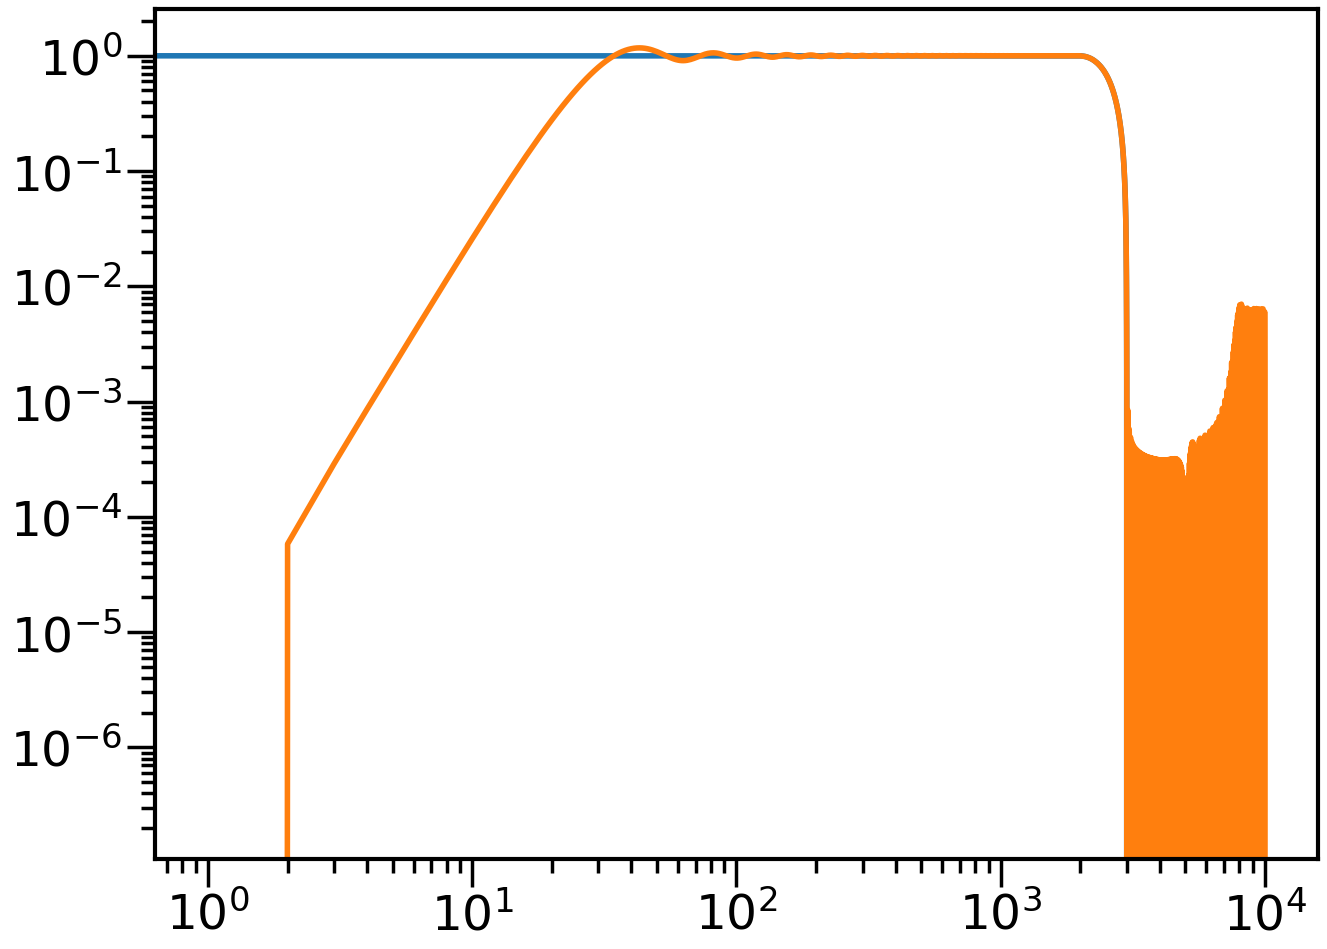

In [141]:
plot(l_cut_weights)
lit,lw2=WT2.inv_projected_correlation(xi=thc2[s],s1_s2=s,theta_xi=th2*d2r)
plot(lw2)
xscale('log')
yscale('log')

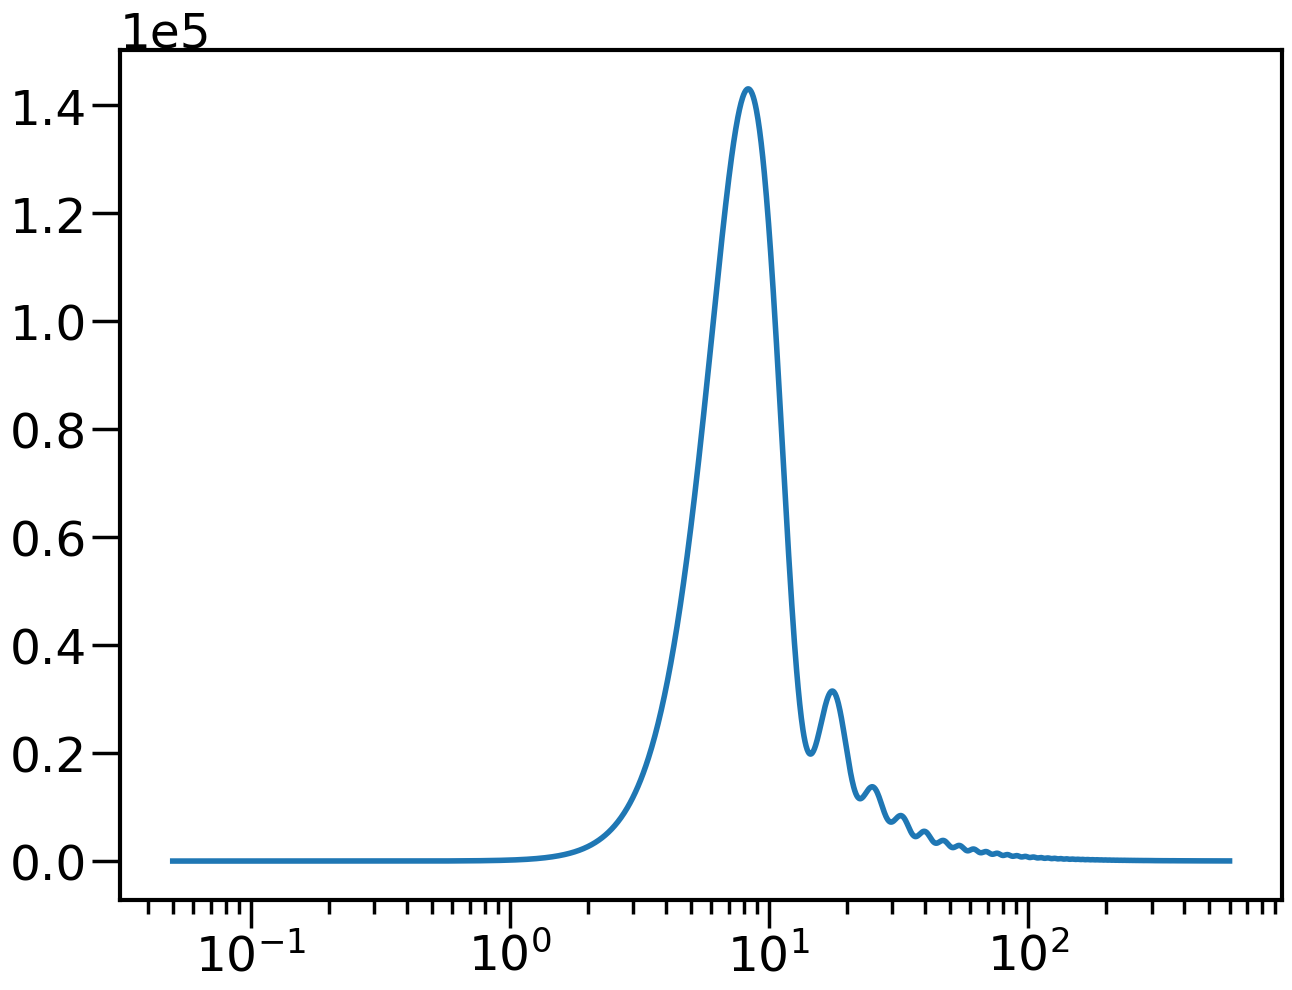

In [142]:
# plot(th2*60,thc[s])
plot(th2*60,thc2[s])
xscale('log')

In [143]:
tt,xi0_2ub=WT2.projected_correlation(l_cl=l0_2,cl=cl0_2[corr][bi],s1_s2=s)
tt,xi0_2ubc=WT2.projected_correlation(l_cl=l0_2,cl=cl0_2[corr][bi]*l_cut_weights,s1_s2=s)

M=thc_m2[s]
xi_c=M@(xi0_2ub)

xi_cb=bb.bin_1d(xi=xi_c,bin_utils=xi_bu)

xi0_2c=bb.bin_1d(xi=xi0_2ubc,bin_utils=xi_bu)
xi0_2=bb.bin_1d(xi=xi0_2ub,bin_utils=xi_bu)

thc_m_b=bb.bin_2d_coupling(M=thc_m2[s],bin_utils=xi_bu,wt_b=1./xi0_2,wt0=xi0_2ub)
xi_cb2=thc_m_b@xi0_2


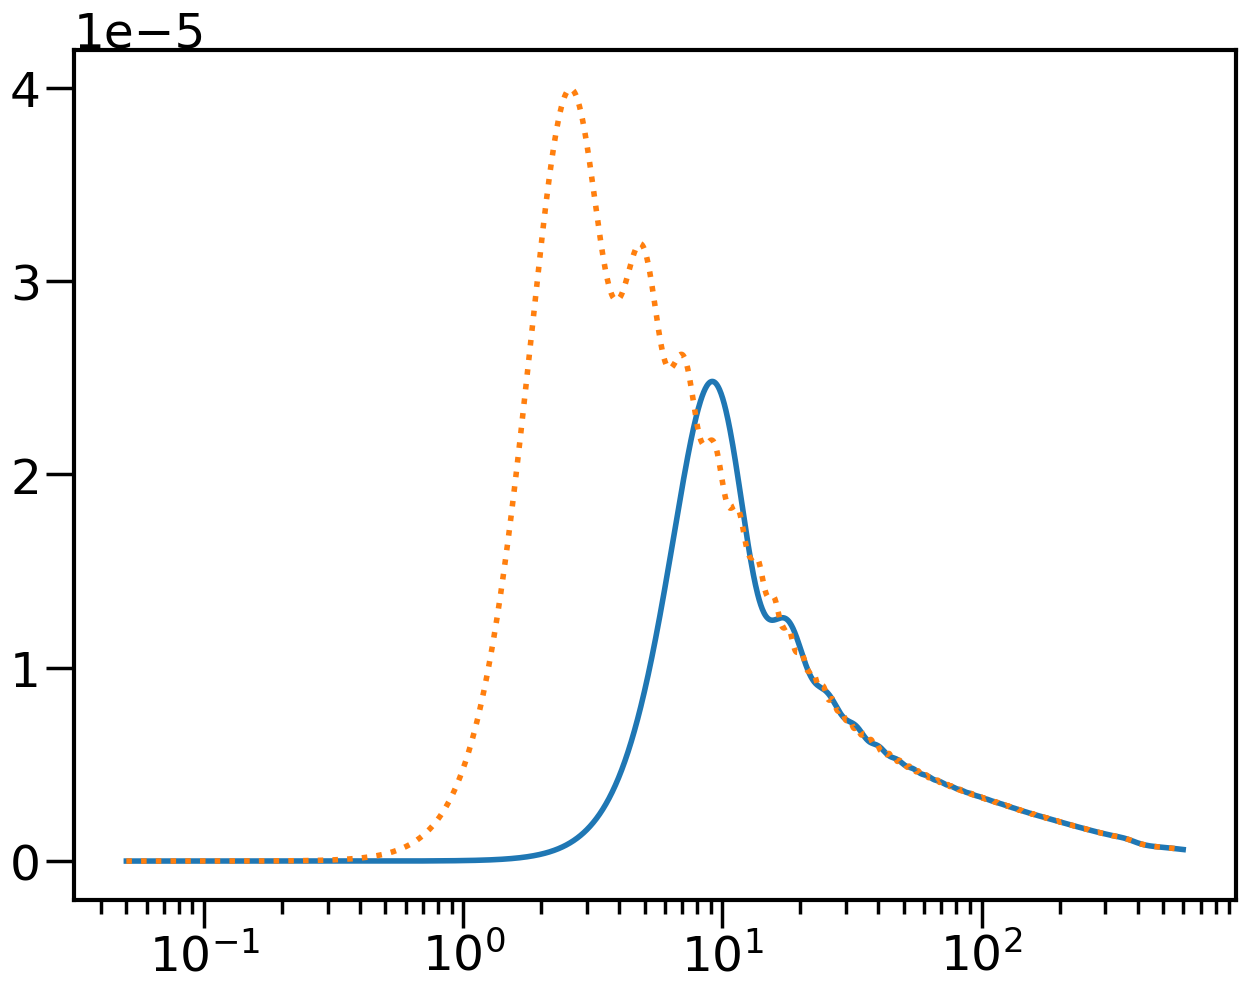

In [144]:
# plot(th2,xi0b2[corr_ll][s][bi]/xi_c0)
# plot(th2,xi0b2[corr][s][bi])
plot(th2*60,xi0_2ubc)

# plot(thb,xi0[corr][s][bi],'--')
plot(th2*60,xi0_2ub,':')

xscale('log')

In [145]:
M=thc_m2[s] #thc_m[s]
# xi_c=M@(xi0_2ub*np.gradient(th2*d2r)*np.sin(th2*d2r))#[corr][s][bi]
xi_c=M@(xi0_2ub)

xi_cb=bb.bin_1d(xi=xi_c,bin_utils=xi_bu)

xi0_2c=bb.bin_1d(xi=xi0_2ubc,bin_utils=xi_bu)
xi0_2=bb.bin_1d(xi=xi0_2ub,bin_utils=xi_bu)

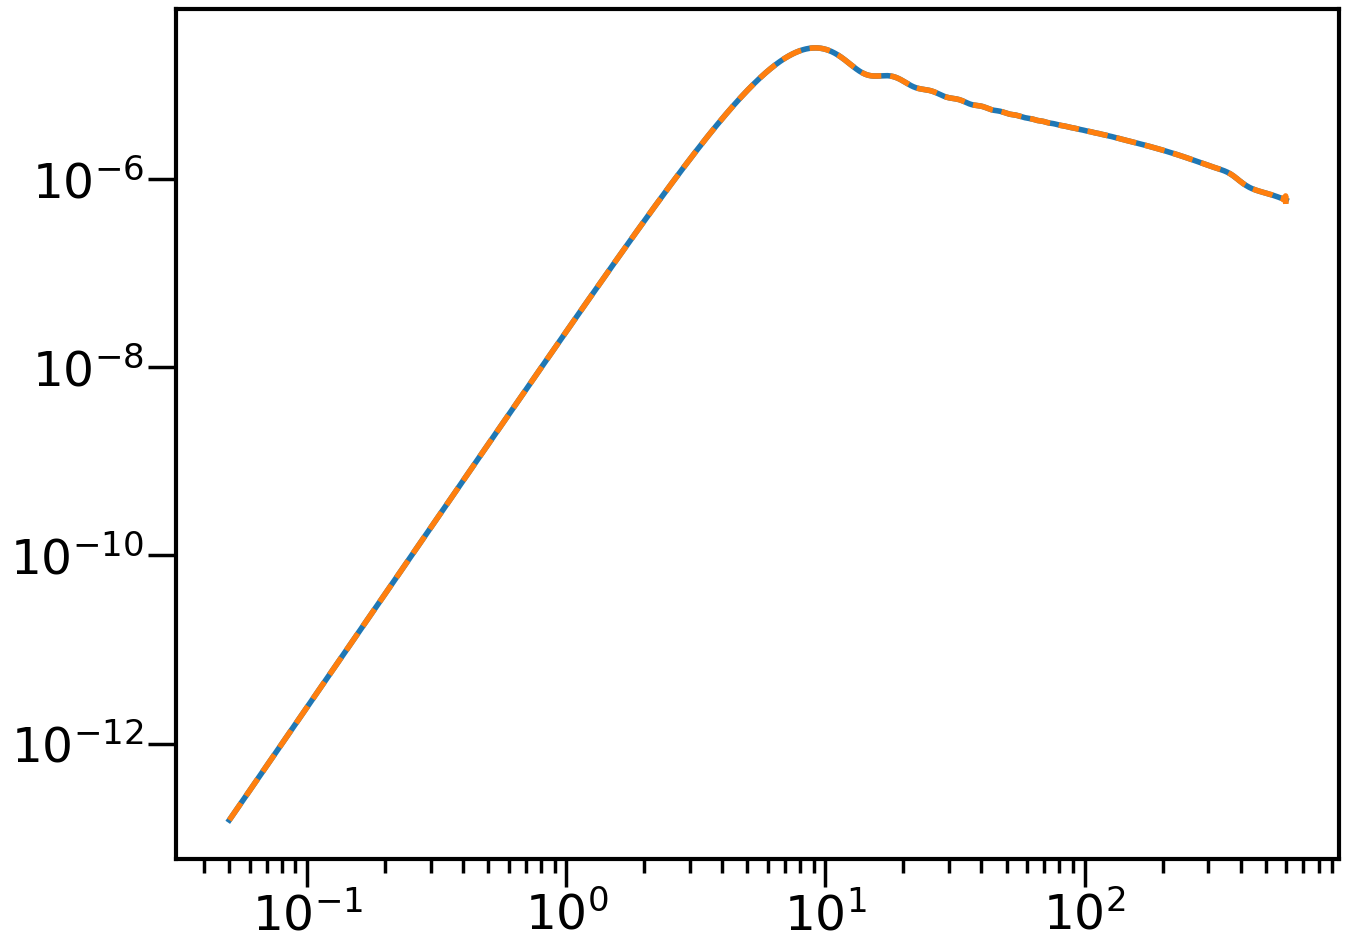

In [146]:
plot(th2*60,xi0_2ubc)
# plot(th2*60,xi0_2ub,':')
plot(th2*60,xi_c,'--')
xscale('log')
yscale('log')

In [147]:
th2*60

array([5.00000000e-02, 5.02354868e-02, 5.04720827e-02, ...,
       5.94387994e+02, 5.97187405e+02, 6.00000000e+02])

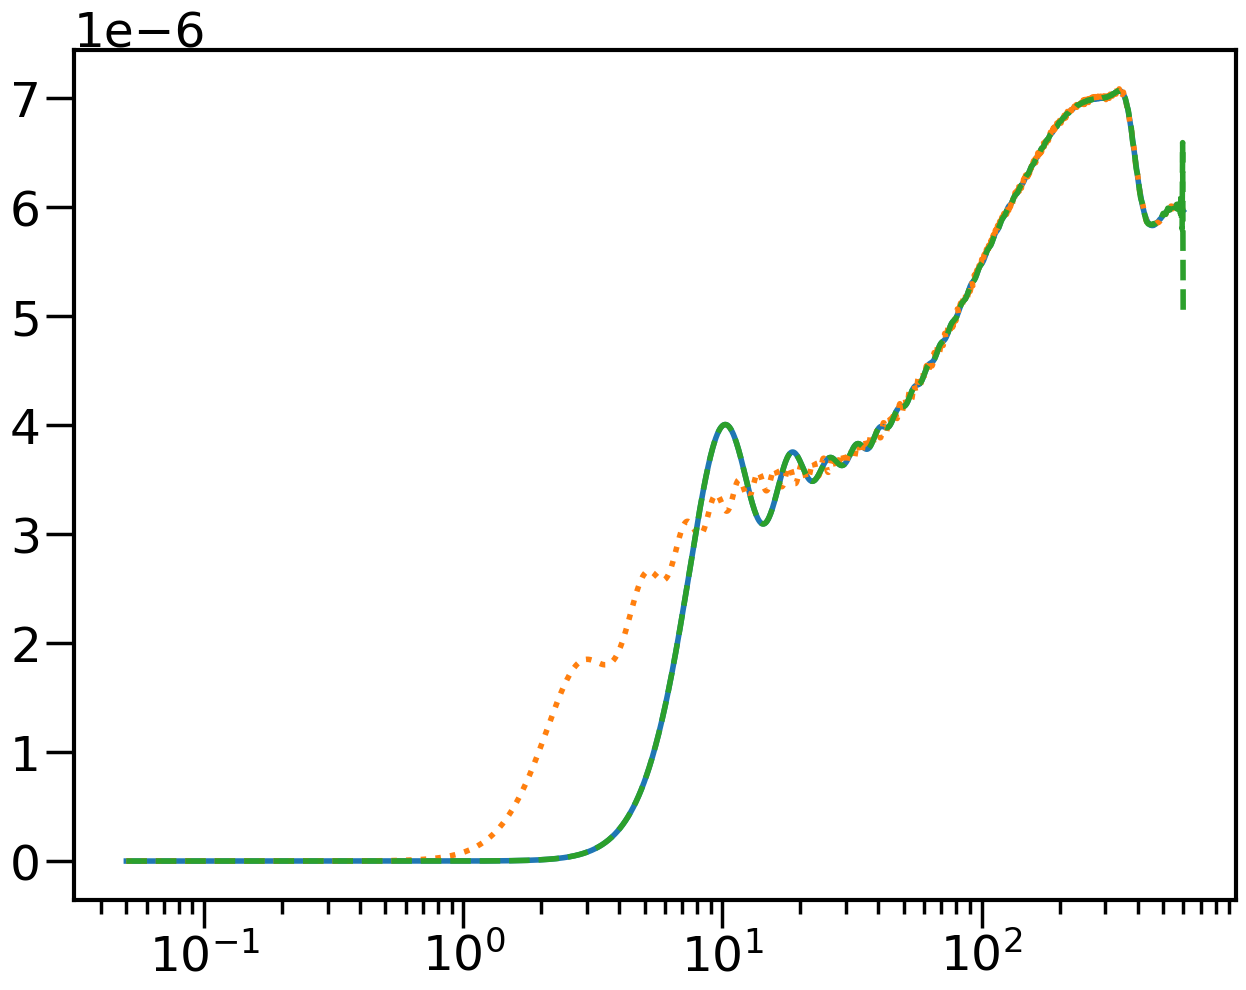

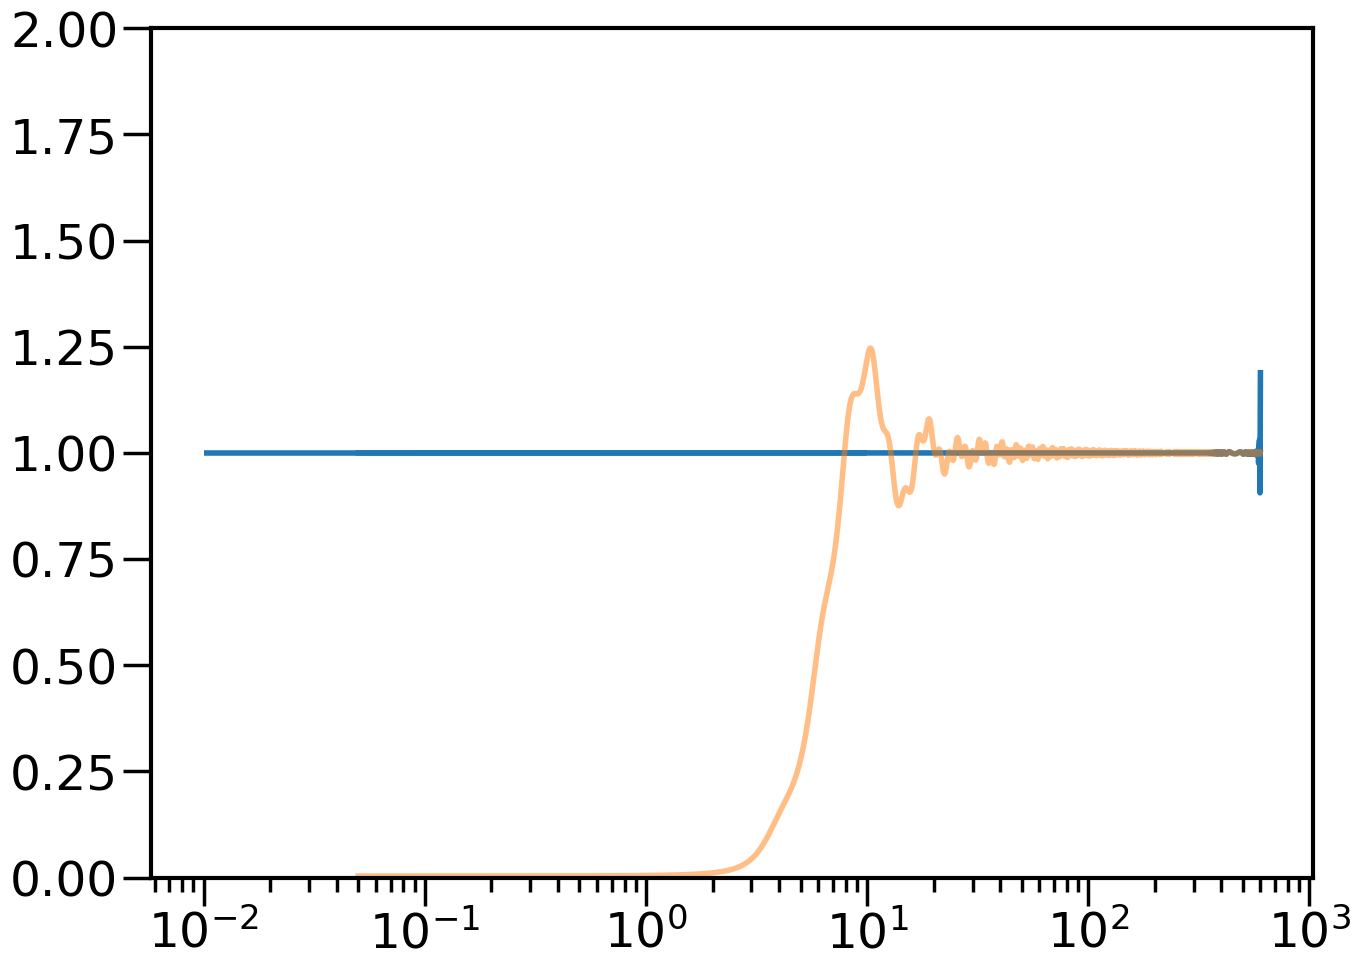

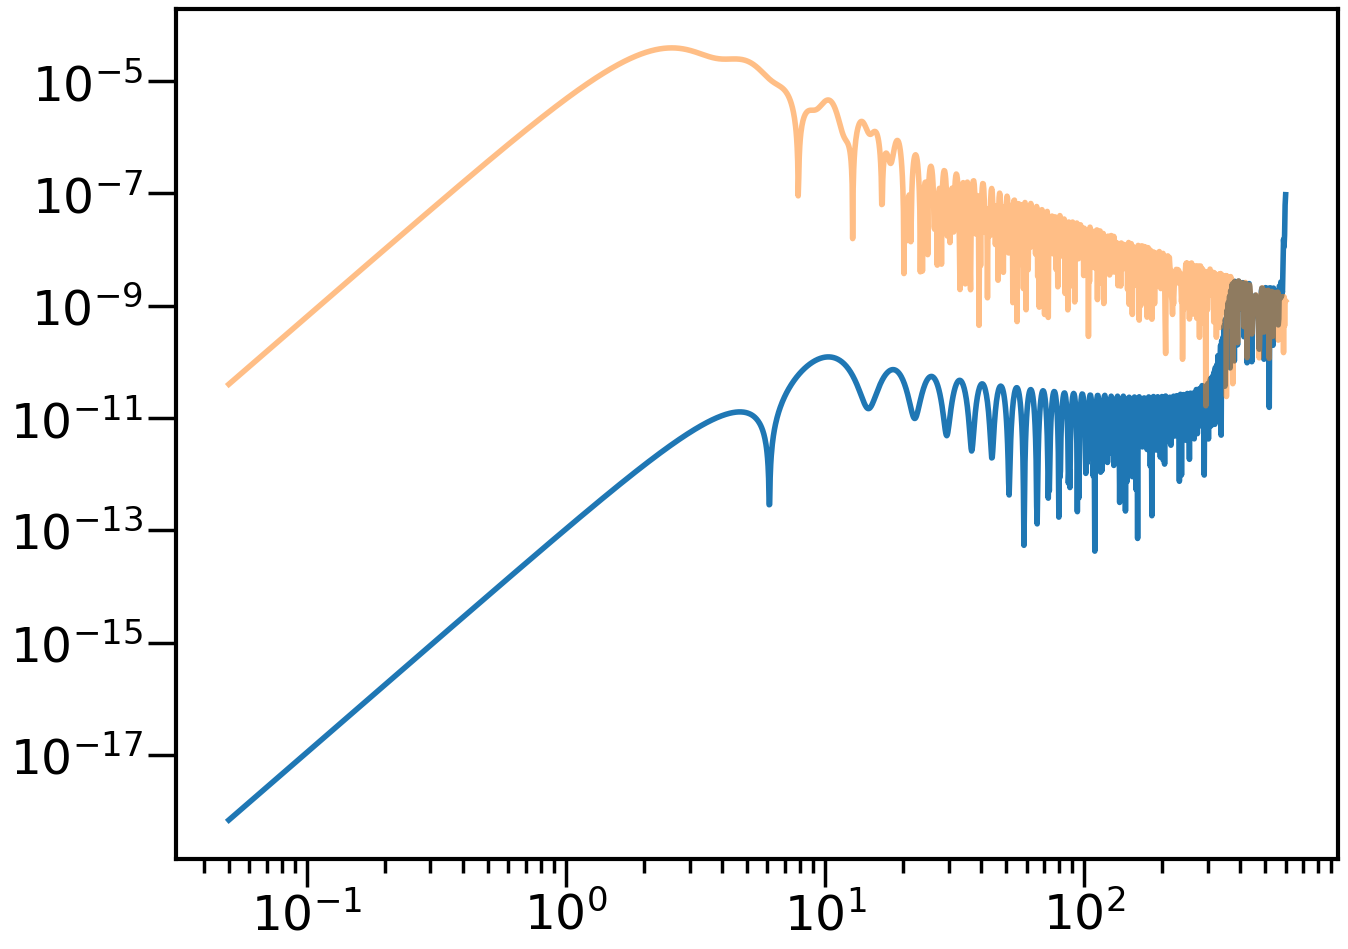

In [148]:
plot(th2*60,th2*xi0_2ubc)
plot(th2*60,th2*xi0_2ub,':')
plot(th2*60,th2*xi_c,'--')
xscale('log')
show()
plot(th2*60,xi0_2ubc/xi_c)
plot(th2*60,xi0_2ubc/xi0_2ub,alpha=0.5)
hlines(1,1.e-2,10)
xscale('log')
ylim(0,2)
show()
plot(th2*60,np.absolute(xi0_2ubc-xi_c))
plot(th2*60,np.absolute(xi0_2ubc-xi0_2ub),alpha=0.5)
# hlines(1,1.e-2,10)
xscale('log')
yscale('log')
# ylim(0,2)

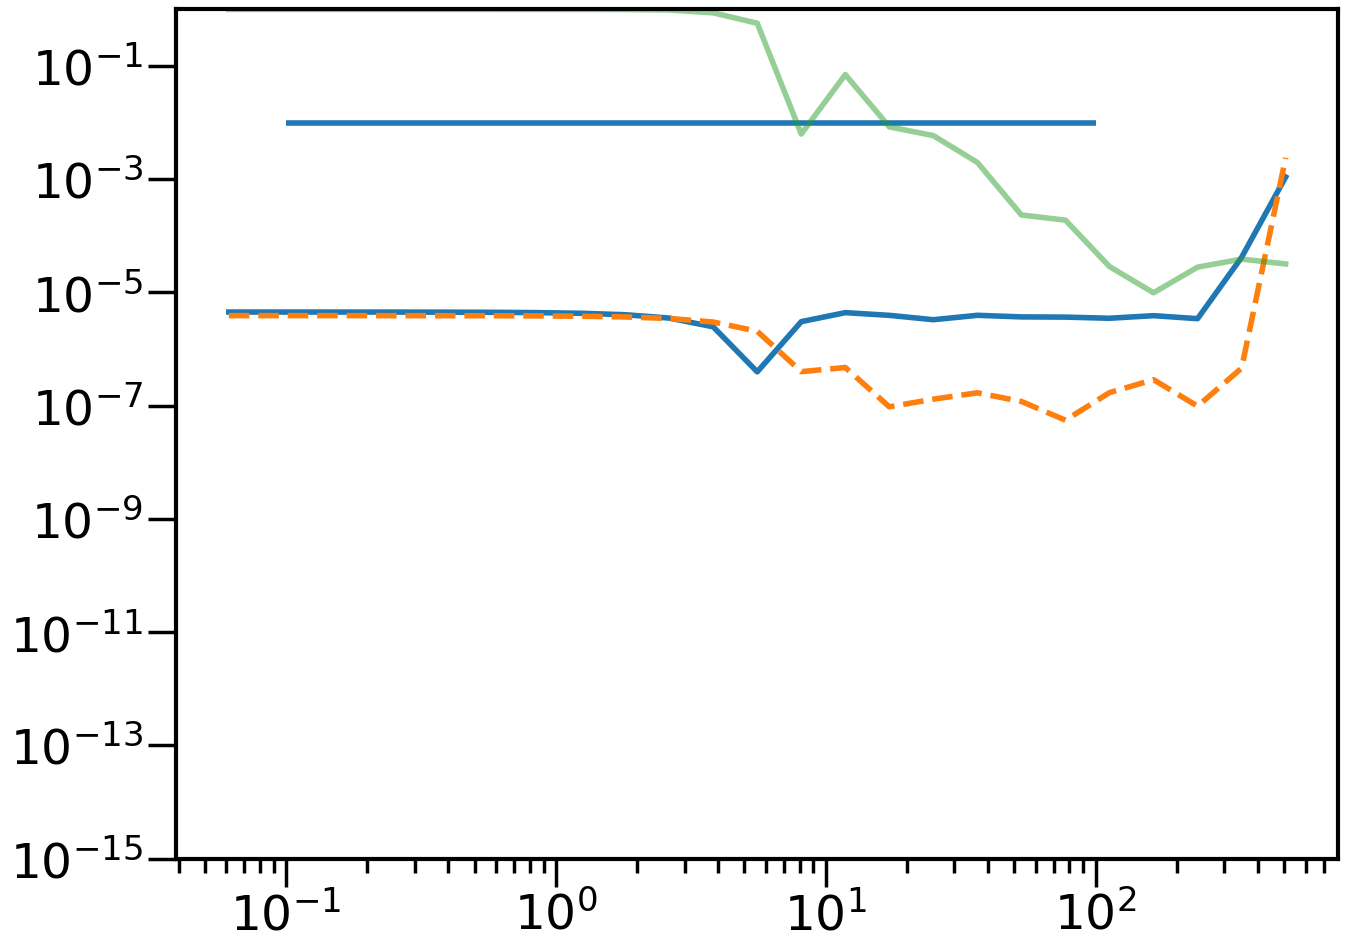

In [153]:
plot(thb2*60,np.absolute(xi0_2c/xi_cb-1))
plot(thb2*60,np.absolute(xi_cb2/xi_cb-1),'--')
plot(thb2*60,np.absolute(xi0_2c/xi0_2-1),alpha=0.5)
hlines(1.e-2,1.e-1,100)
xscale('log')
yscale('log')
ylim(1.e-15,1.e-0)
show()


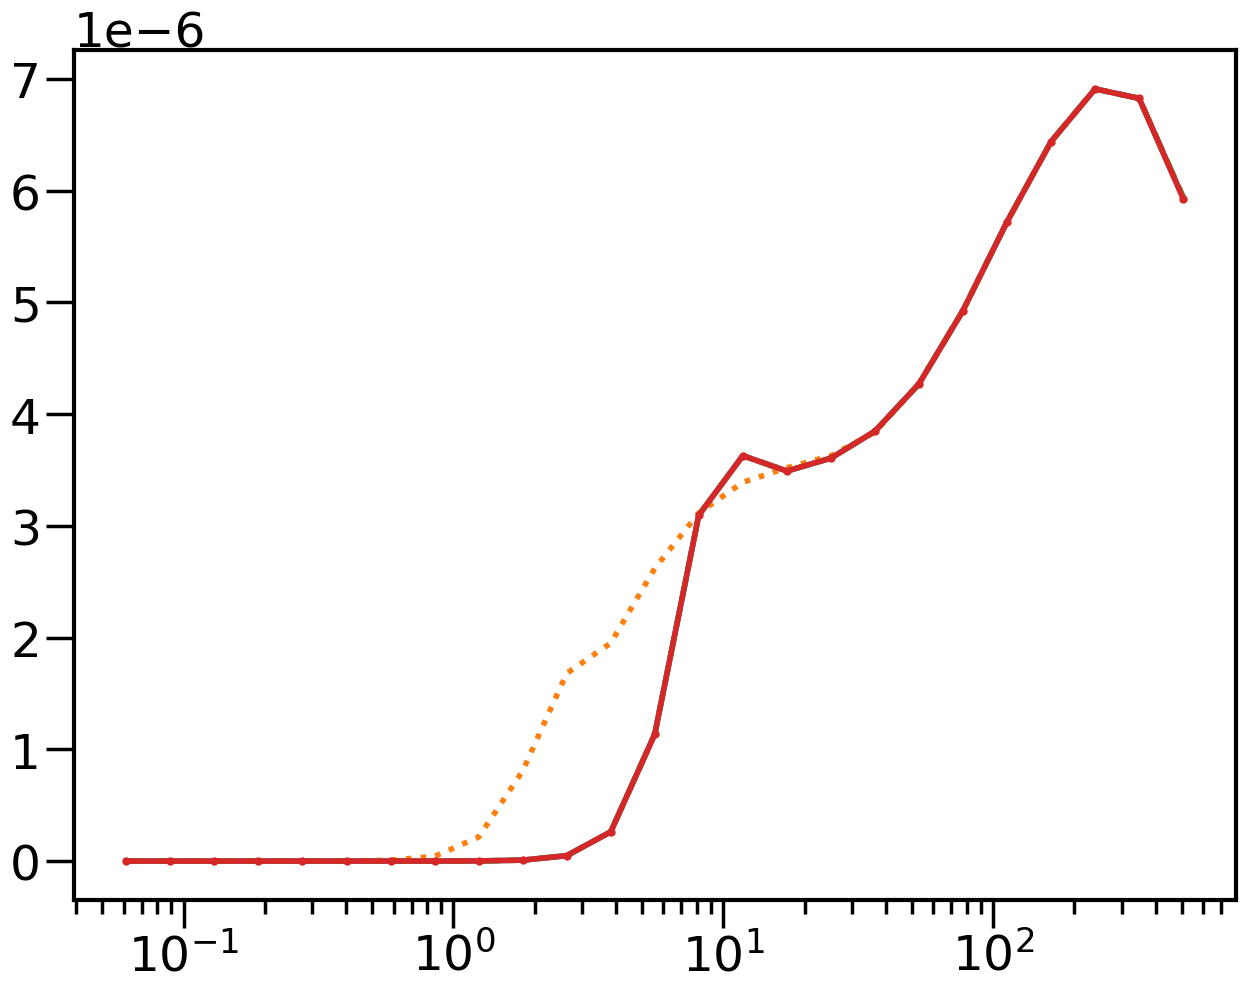

In [154]:
plot(thb2*60,thb2*xi0_2c)
plot(thb2*60,thb2*xi0_2,':')
plot(thb2*60,thb2*xi_cb,'--')
plot(thb2*60,thb2*xi_cb2,'.-')
xscale('log')
show()
# plot(th2,np.absolute(xi0_2ubc-xi_c))
# plot(th2,np.absolute(xi0_2ubc-xi0_2ub),alpha=0.5)
# # hlines(1,1.e-2,10)
# xscale('log')
# yscale('log')
# # ylim(0,2)

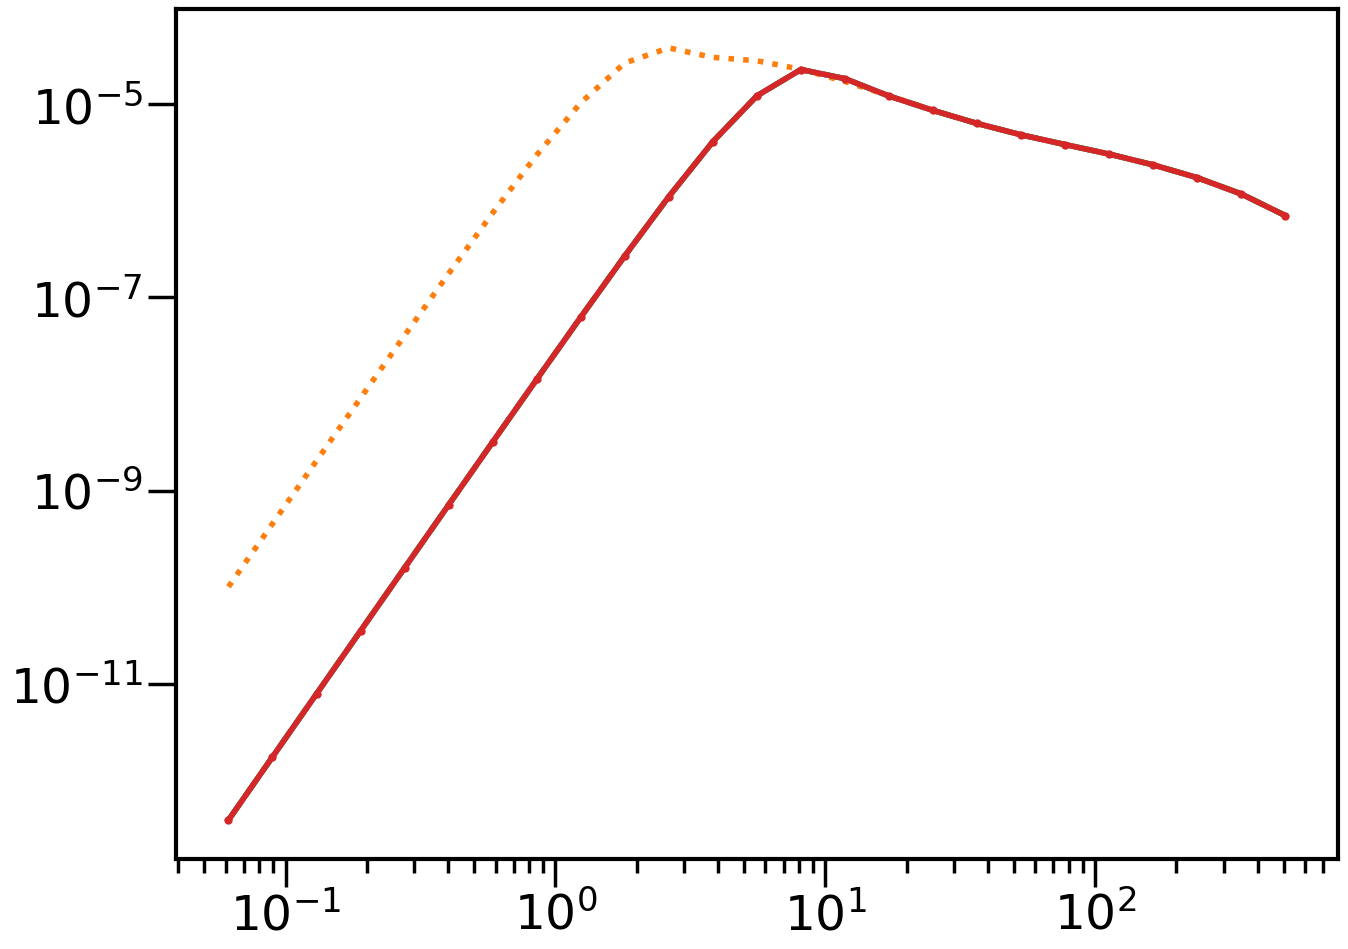

In [155]:
plot(thb2*60,xi0_2c)
plot(thb2*60,xi0_2,':')
plot(thb2*60,xi_cb,'--')
plot(thb2*60,xi_cb2,'.-')
xscale('log')
yscale('log')
show()
# plot(th2,np.absolute(xi0_2ubc-xi_c))
# plot(th2,np.absolute(xi0_2ubc-xi0_2ub),alpha=0.5)
# # hlines(1,1.e-2,10)
# xscale('log')
# yscale('log')
# # ylim(0,2)

In [156]:
thb2.shape

(25,)

In [180]:
corrs

[('galaxy', 'galaxy'), ('shear', 'shear'), ('galaxy', 'shear')]

saved to  ./figures/xi_convolve_all.pdf


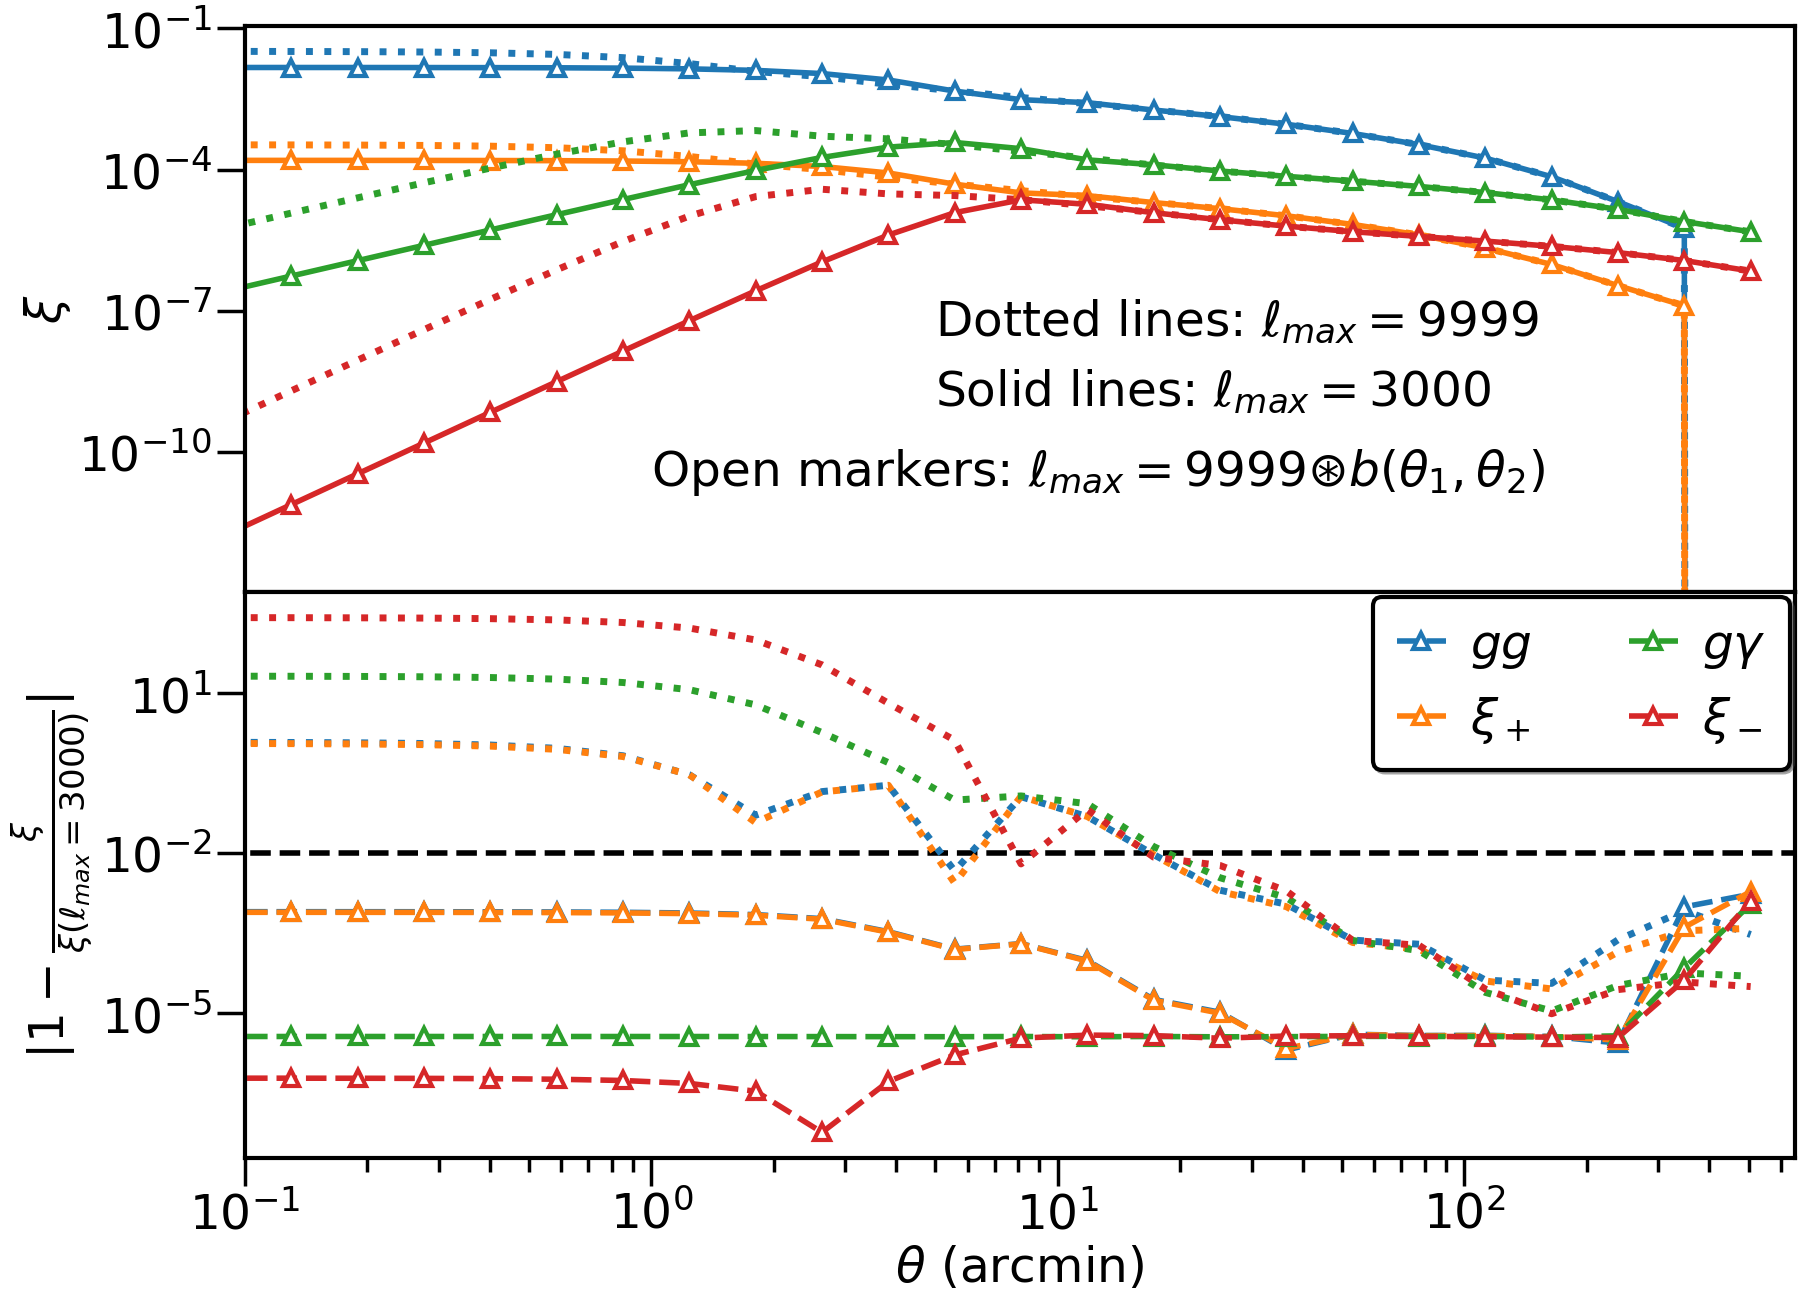

In [225]:
fig, ax =subplots(2,1,figsize=(20,15),sharex='col',sharey='row')
pS=ax[0]
pR=ax[1]
i=0
corrs2=corrs+[corr_ll]
s_pm=0
for corr in corrs2:
    j=0
    s=s1_s2s[corr]
    if corr==corr_ll:
        s=s1_s2s[corr][s_pm]
        s_pm+=1
    tt,xi0_2ub=WT2.projected_correlation(l_cl=l0_2,cl=cl0_2[corr][bi],s1_s2=s)
    tt,xi0_2ubc=WT2.projected_correlation(l_cl=l0_2,cl=cl0_2[corr][bi]*l_cut_weights,s1_s2=s)

    M=thc_m2[s]
    xi_c=M@(xi0_2ub)

    xi_cb=bb.bin_1d(xi=xi_c,bin_utils=xi_bu)

    xi0_2c=bb.bin_1d(xi=xi0_2ubc,bin_utils=xi_bu)
    xi0_2=bb.bin_1d(xi=xi0_2ub,bin_utils=xi_bu)

    M_b=bb.bin_2d_coupling(M=thc_m2[s],bin_utils=xi_bu,wt_b=1./xi0_2,wt0=xi0_2ub)
    xi_cb2=M_b@xi0_2


    pS.plot(thb2*60,xi0_2c,color=colors[i])#,marker=markers[j]) #label=r'$\ell_{max}='+str(l_max_cut)+'$'
    j+=1
    pS.plot(thb2*60,xi0_2,':',color=colors[i],lw=5)#
    pR.plot(thb2*60,np.absolute(xi0_2/xi0_2c-1),alpha=1,color=colors[i],ls=':',lw=5)#,marker=markers[j],ms=12)
    j+=1
    pS.plot(thb2*60*1.0,xi_cb2,'-',color=colors[i],marker=markers[j],mfc='white',mew=3,ms=12,lw=0) #
    pR.plot(thb2*60,np.absolute(xi_cb2/xi0_2c-1),'--',color=colors[i],marker=markers[j],mfc='white',mew=3,ms=12,label=r''+corr_labels[corr][s])

    i+=1


pR.set_xscale('log')
pS.set_yscale('log')
pR.set_yscale('log')
# pR.set_yscale('symlog',linthreshy=0.01)
# pR.set_ylim(0.001,1)
# pS.set_ylim(5.e-9,5.e-6)
pR.hlines(.01,1.e-2,2000,color='k',ls='--')

pR.set_xlim(1.e-1,650)
pR.set_xlabel(r'$\theta$ (arcmin)')
pR.set_ylabel(r'$|1-\frac{\xi}{\xi('+r'\ell_{max}='+str(l_max_cut)+')}|$')
pS.set_ylabel(r'$\xi$')

pS.text(x=5,y=3e-8,s=r'Dotted lines: $\ell_{max}='+str(l0_2.max())+'$')
pS.text(x=5,y=1e-9,s=r'Solid lines: $\ell_{max}='+str(l_max_cut)+'$')
pS.text(x=1,y=2e-11,s=r'Open markers: $\ell_{max}='+str(l0_2.max())+r'\circledast b(\theta_1,\theta_2)$')

pR.legend(loc='upper right',ncol=2)
fname='xi_convolve_all'
fname=fig_home+fname
fname+='.pdf'
fig.savefig(fname,bbox_inches='tight',format='pdf')
print('saved to ',fname)    
show()

<ipython-input-226-c717a9ed3682>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolor(thb2*60,thb2*60,np.absolute(M_b),norm=LogNorm(),cmap='Reds')


[]

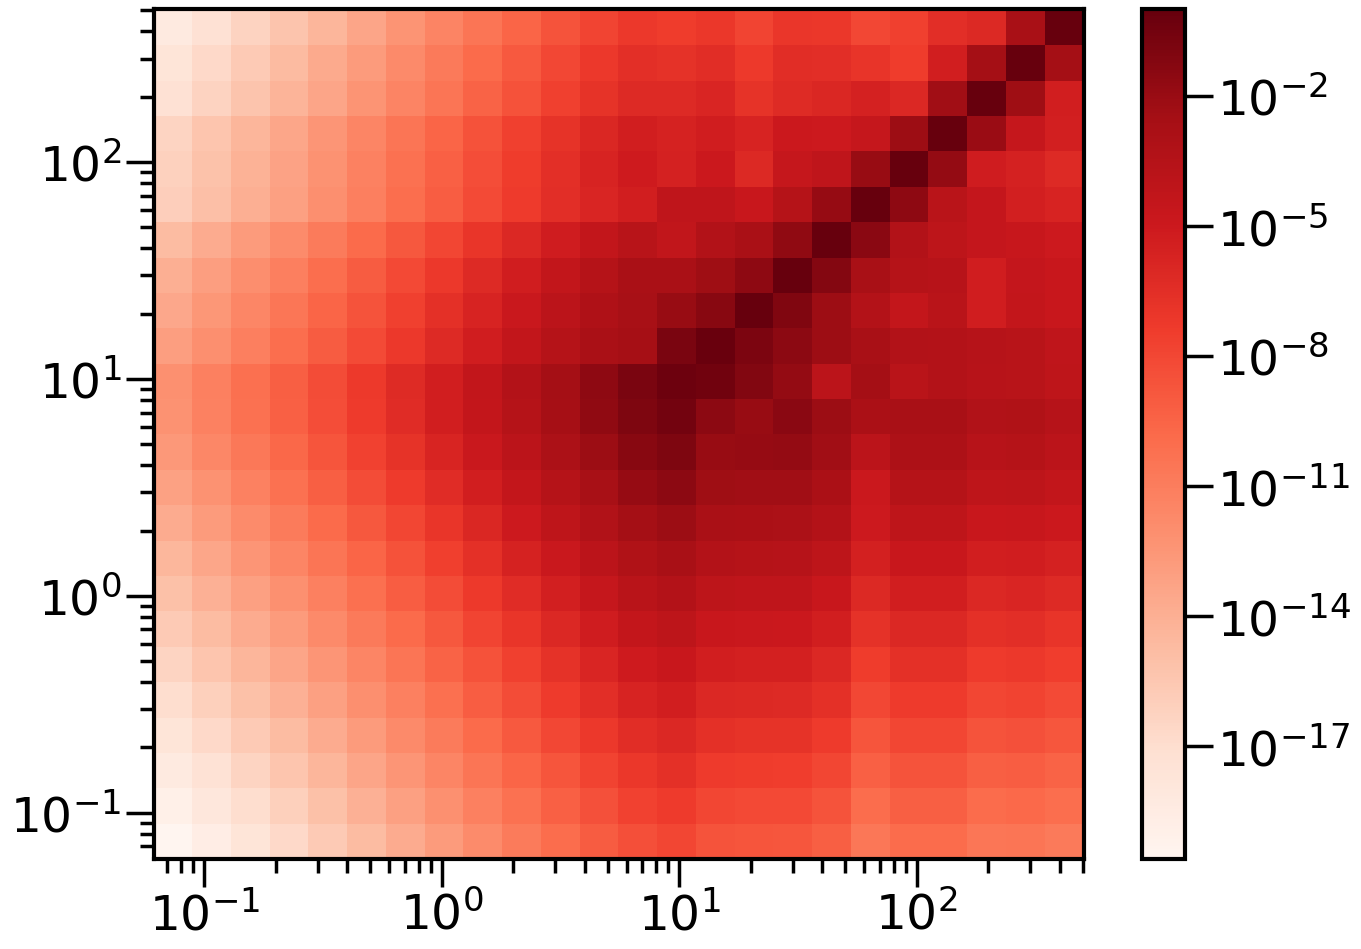

In [226]:
pcolor(thb2*60,thb2*60,np.absolute(M_b),norm=LogNorm(),cmap='Reds')
colorbar()
loglog()